<a href="https://colab.research.google.com/github/masadeghi/dementia_clf_fmri/blob/main/final/fmri_dementia_analysis_jdim_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependencies
xgboost==1.7.6
scikit-learn==1.2.2

In [ ]:
%%capture
!pip install -qU tsai
!pip install -qU tsfresh
!pip install -qU graphviz
!pip install -qU joblib
!pip install -qU dtreeviz
!pip install -qU researchpy
!pip install xgboost==1.7.6

In [ ]:
import os
import gc
import copy
import pprint
import graphviz
import dtreeviz
import joblib
import sys
from tqdm.notebook import tqdm
from google.colab import files, drive
from itertools import combinations

import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import researchpy as rp

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelBinarizer, label_binarize
from sklearn.utils import resample
from sklearn.metrics import average_precision_score, balanced_accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, precision_recall_curve, recall_score, precision_score, f1_score

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

np.set_printoptions(suppress=True) # Prevent numbers from being printed with scientific notation

In [ ]:
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [ ]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.2.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, dtreeviz, fastai, imbalanced-learn, librosa, mlxtend, pyts, qudida, sklearn-pandas, tsai, tsfresh, yellowbrick


In [ ]:
!pip show pandas

Name: pandas
Version: 1.5.3
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, python-dateutil, pytz
Required-by: altair, arviz, bigframes, bokeh, bqplot, cmdstanpy, cufflinks, datascience, db-dtypes, dopamine-rl, dtreeviz, fastai, geemap, geopandas, google-colab, gspread-dataframe, holoviews, ibis-framework, mizani, mlxtend, pandas-datareader, pandas-gbq, panel, plotnine, prophet, pymc, researchpy, seaborn, sklearn-pandas, statsmodels, tsfresh, vega-datasets, xarray, yfinance


In [ ]:
!pip show numpy

Name: numpy
Version: 1.25.2
Summary: Fundamental package for array computing in Python
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: albumentations, altair, arviz, astropy, autograd, blis, bokeh, bqplot, chex, cmdstanpy, contourpy, cufflinks, cupy-cuda12x, cvxpy, datascience, db-dtypes, dopamine-rl, dtreeviz, ecos, flax, folium, geemap, gensim, gym, h5py, holoviews, hyperopt, ibis-framework, imageio, imbalanced-learn, imgaug, jax, jaxlib, librosa, lightgbm, matplotlib, matplotlib-venn, missingno, mizani, ml-dtypes, mlxtend, moviepy, music21, nibabel, numba, numexpr, opencv-contrib-python, opencv-python, opencv-python-headless, opt-einsum, optax, orbax-checkpoint, osqp, pandas, pandas-gbq, patsy, plotnine, prophet, pyarrow, pycocotools, pyerfa, pymc, pytensor, python-louvain, pyts, PyWavelets, qdldl, qudida, researchpy, scikit-image, scikit-learn, scipy, sc

In [ ]:
!pip show matplotlib

Name: matplotlib
Version: 3.7.1
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /usr/local/lib/python3.10/dist-packages
Requires: contourpy, cycler, fonttools, kiwisolver, numpy, packaging, pillow, pyparsing, python-dateutil
Required-by: arviz, bigframes, datascience, dtreeviz, fastai, geemap, imgaug, matplotlib-venn, missingno, mizani, mlxtend, music21, plotnine, prophet, pycocotools, seaborn, wordcloud, yellowbrick


In [ ]:
!pip show scipy

Name: scipy
Version: 1.11.4
Summary: Fundamental algorithms for scientific computing in Python
Home-page: https://scipy.org/
Author: 
Author-email: 
License: Copyright (c) 2001-2002 Enthought, Inc. 2003-2023, SciPy Developers.
        All rights reserved.
        
        Redistribution and use in source and binary forms, with or without
        modification, are permitted provided that the following conditions
        are met:
        
        1. Redistributions of source code must retain the above copyright
           notice, this list of conditions and the following disclaimer.
        
        2. Redistributions in binary form must reproduce the above
           copyright notice, this list of conditions and the following
           disclaimer in the documentation and/or other materials provided
           with the distribution.
        
        3. Neither the name of the copyright holder nor the names of its
           contributors may be used to endorse or promote products derived

In [ ]:
!pip show seaborn

Name: seaborn
Version: 0.13.1
Summary: Statistical data visualization
Home-page: 
Author: 
Author-email: Michael Waskom <mwaskom@gmail.com>
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, numpy, pandas
Required-by: missingno


In [ ]:
!pip show researchpy

Name: researchpy
Version: 0.3.6
Summary: Researchpy produces Pandas DataFrames that contain relevant statistical testing information that is commonly required for academic research.
Home-page: 
Author: 
Author-email: Corey Bryant <CoreyBryant10@gmail.com>
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, pandas, patsy, scipy, statsmodels
Required-by: 


In [ ]:
!pip show dtreeviz

Name: dtreeviz
Version: 2.2.2
Summary: A Python 3 library for sci-kit learn, XGBoost, LightGBM, Spark, and TensorFlow decision tree visualization
Home-page: https://github.com/parrt/dtreeviz
Author: Terence Parr, Tudor Lapusan, and Prince Grover
Author-email: parrt@antlr.org
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: colour, graphviz, matplotlib, numpy, pandas, pytest, scikit-learn
Required-by: 


# Connect to Google Drive and set cd

In [ ]:
# Mount Google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Coding projects/resting_fmri_dementia/

/content/gdrive/MyDrive/Coding projects/resting_fmri_dementia


# Import data

In [ ]:
# Imaging features data
X = np.load('./data_dir_features/features_df_custom_as_array.npy')
feature_names = np.load('./data_dir_features/features_df_custom_column_names.npy', allow_pickle = True)
X.shape

(1084, 75400)

In [ ]:
# Load clinical data
clinical_data = pd.read_csv("./data_dir_clinical/clinical_absolute_final.csv")
clinical_data.drop('class', axis = 1, inplace = True)

clinical_feature_names = list(clinical_data.columns)

clinical_data.head()

age  biological_sex  education  mmse_total_score  cdr_total_score  \
0  73.0             0.0       17.0              23.0              1.0   
1  73.0             0.0       17.0              23.0              1.0   
2  73.0             0.0       17.0              24.0              1.0   
3   NaN             NaN        NaN              22.0              1.0   
4  79.0             0.0       20.0              22.0              0.5   

   boston_naming_test_total  letter_verbal_fluency_test  gds_score  
0                       NaN                         9.0        1.0  
1                      30.0                         9.0        1.0  
2                      30.0                         7.0        2.0  
3                      30.0                         3.0        2.0  
4                       NaN                        15.0        1.0

In [ ]:
# Load y
y = np.load('data_dir_npy/y.npy')
y = y.astype(int)

## For the ROC curves during evaluation
y_onehot = LabelBinarizer().fit_transform(y)
print(y_onehot.shape)
n_classes = len(np.unique(y))

(1084, 4)


In [ ]:
# Load labels data for splitting scans
labels = pd.read_csv('./group_csv_files/labels_new_final.csv')
final_idx = np.load('./group_csv_files/final_idx.npy')
labels = labels.loc[final_idx, :]
labels.shape

(1084, 7)

In [ ]:
{dis_class:np.mean(labels.groupby(['class', 'patient_original_id']).count().loc[dis_class, 'fmri_id_in_database'] > 1) for dis_class in labels['class'].unique()}

{'AD': 0.71875,
 'FTD': 0.5099337748344371,
 'HC': 0.8175675675675675,
 'MCI': 0.7961165048543689}

# Configuration

In [ ]:
random_state = 33


n_folds = 5


# parameters for the randomizedsearchCV on the XGBoost
params = {
    "n_estimators": np.linspace(200, 2000, num = 10, endpoint = True).astype(int),
    "learning_rate" : [0.001, 0.01, 0.1, 0.3, 1],
    "max_depth" : [2, 3, 6, 12, 15],
    # "min_child_weight" : [ 1, 3, 5, 7 ],
    "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    # "colsample_bytree": [0.6, 0.8, 1]
}

lr_params = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver': 'saga',
    'class_weight': ['balanced', None],
    'l1_ratio': np.linspace(0, 1, 5),
    'multiclass': 'multinomial'
}

dt_params = {
    'max_depth': [2, 3, 6, 12, 15],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    # 'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None]
}


# Used for dtreeviz
clinical_tree_friendly_names = {'age': 'Age',
                                'biological_sex': 'Sex',
                                'education': 'Education',
                                'mmse_total_score': 'MMSE Total Score',
                                'cdr_total_score': 'CDR Total Score',
                                'boston_naming_test_total': 'BNT Total Score',
                                'letter_verbal_fluency_test': 'Verbal Fluency Score',
                                'gds_score': 'GDS Score'}

# Stratified K fold splits for scans based on patient IDs
Performed based on patient_IDs and their diagnosis at their first visit to prevent data leakage.

In [ ]:
# Get patient information
splittable_data = labels.loc[:, ['class', 'patient_original_id']].groupby('patient_original_id').first()
splittable_data_X = splittable_data.index.values
splittable_data_y = splittable_data['class'].values

# Split patients
cv_splitter = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = random_state)
patient_splits = list(cv_splitter.split(splittable_data_X, splittable_data_y))

# Extract scans corresponding to the split patients
scan_splits = []

for i in range(len(patient_splits)):
  train_index = np.where(labels['patient_original_id'].isin(splittable_data.iloc[patient_splits[i][0], :].index))[0]
  test_index = np.where(labels['patient_original_id'].isin(splittable_data.iloc[patient_splits[i][1], :].index))[0]
  scan_splits.append((train_index, test_index))

## K fold splits without repeats in the test set

In [ ]:
# Remove duplicates from the test set folds of the CV rounds to prevent artificial inflation of metrics
mod_scan_splits = []
mod_changes = []
for i in range(len(scan_splits)):
  new_y_idx = labels.reset_index().loc[scan_splits[i][1], :].drop_duplicates(subset = 'patient_original_id', keep = 'first').index
  mod_scan_splits.append((scan_splits[i][0], new_y_idx))

  orig_ad = np.sum(y[scan_splits[0][1]] == 0)
  orig_ftd = np.sum(y[scan_splits[0][1]] == 1)
  orig_hc = np.sum(y[scan_splits[0][1]] == 2)
  orig_mci = np.sum(y[scan_splits[0][1]] == 3)

  mod_ad = np.sum(y[new_y_idx] == 0)
  mod_ftd = np.sum(y[new_y_idx] == 1)
  mod_hc = np.sum(y[new_y_idx] == 2)
  mod_mci = np.sum(y[new_y_idx] == 3)

  ad_change = (orig_ad - mod_ad)/orig_ad
  ftd_change = (orig_ftd - mod_ftd)/orig_ftd
  hc_change = (orig_hc - mod_hc)/orig_hc
  mci_change = (orig_mci - mod_mci)/orig_mci

  mod_changes.append((ad_change, ftd_change, hc_change, mci_change))

In [ ]:
# Percentage of data removed from each class in test set (fold) of each CV round
np.array(mod_changes)

array([[0.7       , 0.41176471, 0.58333333, 0.71621622],
       [0.65      , 0.41176471, 0.58333333, 0.72972973],
       [0.65      , 0.41176471, 0.58333333, 0.72972973],
       [0.7       , 0.39215686, 0.59722222, 0.71621622],
       [0.7       , 0.41176471, 0.59722222, 0.71621622]])

# Define functions

## Confidence interval function

In [ ]:
def print_mean_ci(desired_list):
  """
  Calculate and print the mean and 95% confidence interval of a list of values.

  This function takes a list of numerical values, prints the list, calculates
  the mean of the values, and prints the mean. It also calculates the 95%
  confidence interval for the mean and prints it.

  Parameters:
  ----------
  desired_list : list or array-like
      A list or array of numerical values for which the mean and confidence interval
      are to be calculated.

  Returns:
  -------
  None
      This function prints the mean and confidence interval to the console and does
      not return any value.

  Example:
  -------
  >>> desired_list = [0.1, 0.2, 0.3, 0.4, 0.5]
  >>> print_mean_ci(desired_list)
  [0.1, 0.2, 0.3, 0.4, 0.5]
  mean:  0.3
  95% confidence interval:  (0.13614262478367832, 0.46385737521632166)
  """

  print(desired_list)
  print('mean: ', np.mean(desired_list))
  print('95% confidence interval: ', st.t.interval(0.95, len(desired_list) - 1, loc=np.mean(desired_list), scale=st.sem(desired_list)))

## Generate ROC curve and confusion matrix and related data

In [ ]:
def plot_model(results_dict, plot_results = True, save_image = False, image_name = ''):
  """
  Plot and analyze the output of a classification pipeline.

  This function processes the results of a classification pipeline,
  including confusion matrices and ROC curves, and generates various
  metrics and plots. It can display the results and optionally save
  them as images.

  Parameters:
  ----------
  results_dict : list of dict
      A list of dictionaries containing the results of the classification pipeline.
      Each dictionary should include the following keys:
      - 'confusion_matrix': A confusion matrix (numpy array).
      - 'fpr': A dictionary containing false positive rates (FPR) for each class.
      - 'tpr': A dictionary containing true positive rates (TPR) for each class.
      - 'roc_auc': A dictionary containing the area under the ROC curve (AUC) for each class.
  plot_results : bool, optional
      If True, plots are displayed. Default is True.
  save_image : bool, optional
      If True, the plots are saved as SVG images. Default is False.
  image_name : str, optional
      The base name for the saved images. Default is an empty string.

  Returns:
  -------
  tuple
      A tuple containing:
      - average_cm: numpy.ndarray
          The average confusion matrix.
      - mean_macro_alt_auc: float
          The mean macro-average AUC.
      - macro_alt_auc_interval: tuple
          The 95% confidence interval for the macro-average AUC.

  Notes:
  -----
  - The function prints accuracy and AUC statistics for each class (AD, FTD, HC, MCI).
  - ROC curves and confusion matrices are plotted and can be saved if required.
  - Requires the following libraries: numpy, scipy.stats, seaborn, matplotlib, tqdm.
  """

  # Confusion matrix
  cms = [result['confusion_matrix'] for result in results_dict]
  ad_accuracies = [cm[0, 0] for cm in cms]
  ftd_accuracies = [cm[1, 1] for cm in cms]
  hc_accuracies = [cm[2, 2] for cm in cms]
  mci_accuracies = [cm[3, 3] for cm in cms]
  average_cm = np.mean(cms, axis = 0)

  print('ad accuracies:')
  print_mean_ci(ad_accuracies)
  print("\n")
  print('ftd accuracies:')
  print_mean_ci(ftd_accuracies)
  print("\n")
  print('hx accuracies:')
  print_mean_ci(hc_accuracies)
  print("\n")
  print('mci accuracies:')
  print_mean_ci(mci_accuracies)
  print("\n")

  if plot_results:
    sns.heatmap(average_cm, annot = True, fmt = '.1%', cmap = 'Blues', xticklabels = ['AD', 'FTD', 'HC', 'MCI'], yticklabels = ['AD', 'FTD', 'HC', 'MCI'])
    if save_image:
      plt.savefig("./paper_absolute_final/figures/" + image_name + "_confusion_matrix.svg")
      files.download("./paper_absolute_final/figures/" + image_name + "_confusion_matrix.svg")


  # ROC analysis
  ## AD
  ### TPR
  tpr_ad = [result['tpr'][0] for result in results_dict]
  fpr_ad = [result['fpr'][0] for result in results_dict]
  tpr_ad_lens = [len(result['tpr'][0]) for result in results_dict]
  max_len = np.max(tpr_ad_lens)
  for i, length in enumerate(tpr_ad_lens):
    diff_len = max_len - length
    tpr_ad[i] = np.concatenate([tpr_ad[i], np.array([1.] * diff_len)])
    fpr_ad[i] = np.concatenate([fpr_ad[i], np.array([1.] * diff_len)])
    #### Interpolate ad average over fpr_grid
    fpr_grid = np.linspace(0.0, 1.0, 1000)
    tpr_ad[i] = np.interp(fpr_grid, fpr_ad[i], tpr_ad[i])
    tpr_ad[i][0] = 0.0
    fpr_ad[i] = fpr_grid
  ### Average AD TPRs over the folds
  average_tpr_ad = np.mean(tpr_ad, axis = 0)
  sem_tpr_ad = np.std(tpr_ad, axis = 0)/np.sqrt(len(results_dict))
  min_tpr_ad = np.maximum(average_tpr_ad - 1.96 * sem_tpr_ad, 0)
  max_tpr_ad = np.minimum(average_tpr_ad + 1.96 * sem_tpr_ad, 1)
  ### AUC
  ad_aucs = [auc(fpr_ad[i], tpr_ad[i]) for i in range(len(tpr_ad))]
  mean_ad_auc = np.mean(ad_aucs)
  sem_ad_auc = np.std(ad_aucs)/np.sqrt(len(ad_aucs))
  ad_auc_interval = st.t.interval(0.95, len(ad_aucs) - 1, loc = np.mean(ad_aucs), scale = st.sem(ad_aucs))
  ### Print
  print('ad aucs:')
  print_mean_ci(ad_aucs)
  print("\n")

  ## FTD
  ### TPR
  tpr_ftd = [result['tpr'][1] for result in results_dict]
  fpr_ftd = [result['fpr'][1] for result in results_dict]
  tpr_ftd_lens = [len(result['tpr'][1]) for result in results_dict]
  max_len = np.max(tpr_ftd_lens)
  for i, length in enumerate(tpr_ftd_lens):
    diff_len = max_len - length
    tpr_ftd[i] = np.concatenate([tpr_ftd[i], np.array([1.] * diff_len)])
    fpr_ftd[i] = np.concatenate([fpr_ftd[i], np.array([1.] * diff_len)])
    #### Interpolate ftd average over fpr_grid
    fpr_grid = np.linspace(0.0, 1.0, 1000)
    tpr_ftd[i] = np.interp(fpr_grid, fpr_ftd[i], tpr_ftd[i])
    tpr_ftd[i][0] = 0.0
    fpr_ftd[i] = fpr_grid
  ### Average ftd TPRs over the folds
  average_tpr_ftd = np.mean(tpr_ftd, axis = 0)
  sem_tpr_ftd = np.std(tpr_ftd, axis = 0)/np.sqrt(len(results_dict))
  min_tpr_ftd = np.maximum(average_tpr_ftd - 1.96 * sem_tpr_ftd, 0)
  max_tpr_ftd = np.minimum(average_tpr_ftd + 1.96 * sem_tpr_ftd, 1)
  ### AUC
  ftd_aucs = [auc(fpr_ftd[i], tpr_ftd[i]) for i in range(len(tpr_ftd))]
  mean_ftd_auc = np.mean(ftd_aucs)
  sem_ftd_auc = np.std(ftd_aucs)/np.sqrt(len(ftd_aucs))
  ftd_auc_interval = st.t.interval(0.95, len(ftd_aucs) - 1, loc = np.mean(ftd_aucs), scale = st.sem(ftd_aucs))
  print('ftd aucs:')
  print_mean_ci(ftd_aucs)
  print("\n")

  ## HC
  ### TPR
  tpr_hc = [result['tpr'][2] for result in results_dict]
  fpr_hc = [result['fpr'][2] for result in results_dict]
  tpr_hc_lens = [len(result['tpr'][2]) for result in results_dict]
  max_len = np.max(tpr_hc_lens)
  for i, length in enumerate(tpr_hc_lens):
    diff_len = max_len - length
    tpr_hc[i] = np.concatenate([tpr_hc[i], np.array([1.] * diff_len)])
    fpr_hc[i] = np.concatenate([fpr_hc[i], np.array([1.] * diff_len)])
    #### Interpolate hc average over fpr_grid
    fpr_grid = np.linspace(0.0, 1.0, 1000)
    tpr_hc[i] = np.interp(fpr_grid, fpr_hc[i], tpr_hc[i])
    tpr_hc[i][0] = 0.0
    fpr_hc[i] = fpr_grid
  ### Average hc TPRs over the folds
  average_tpr_hc = np.mean(tpr_hc, axis = 0)
  sem_tpr_hc = np.std(tpr_hc, axis = 0)/np.sqrt(len(results_dict))
  min_tpr_hc = np.maximum(average_tpr_hc - 1.96 * sem_tpr_hc, 0)
  max_tpr_hc = np.minimum(average_tpr_hc + 1.96 * sem_tpr_hc, 1)
  ### AUC
  hc_aucs = [auc(fpr_hc[i], tpr_hc[i]) for i in range(len(tpr_hc))]
  mean_hc_auc = np.mean(hc_aucs)
  sem_hc_auc = np.std(hc_aucs)/np.sqrt(len(hc_aucs))
  hc_auc_interval = st.t.interval(0.95, len(hc_aucs) - 1, loc = np.mean(hc_aucs), scale = st.sem(hc_aucs))
  print('hc aucs:')
  print_mean_ci(hc_aucs)
  print("\n")

  ## MCI
  ### TPR
  tpr_mci = [result['tpr'][3] for result in results_dict]
  fpr_mci = [result['fpr'][3] for result in results_dict]
  tpr_mci_lens = [len(result['tpr'][3]) for result in results_dict]
  max_len = np.max(tpr_mci_lens)
  for i, length in enumerate(tpr_mci_lens):
    diff_len = max_len - length
    tpr_mci[i] = np.concatenate([tpr_mci[i], np.array([1.] * diff_len)])
    fpr_mci[i] = np.concatenate([fpr_mci[i], np.array([1.] * diff_len)])
    #### Interpolate mci average over fpr_grid
    fpr_grid = np.linspace(0.0, 1.0, 1000)
    tpr_mci[i] = np.interp(fpr_grid, fpr_mci[i], tpr_mci[i])
    tpr_mci[i][0] = 0.0
    fpr_mci[i] = fpr_grid
  ### Average mci TPRs over the folds
  average_tpr_mci = np.mean(tpr_mci, axis = 0)
  sem_tpr_mci = np.std(tpr_mci, axis = 0)/np.sqrt(len(results_dict))
  min_tpr_mci = np.maximum(average_tpr_mci - 1.96 * sem_tpr_mci, 0)
  max_tpr_mci = np.minimum(average_tpr_mci + 1.96 * sem_tpr_mci, 1)
  ### AUC
  mci_aucs = [auc(fpr_mci[i], tpr_mci[i]) for i in range(len(tpr_mci))]
  mean_mci_auc = np.mean(mci_aucs)
  sem_mci_auc = np.std(mci_aucs)/np.sqrt(len(mci_aucs))
  mci_auc_interval = st.t.interval(0.95, len(mci_aucs) - 1, loc = np.mean(mci_aucs), scale = st.sem(mci_aucs))
  print('mci aucs:')
  print_mean_ci(mci_aucs)
  print("\n")

  ## Macro
  ### FPR
  fpr = results_dict[0]['fpr']['macro']
  ### TPR and AUC
  tpr_macro_alt = []
  for i in range(len(tpr_ad)):
    tpr_macro_alt.append((tpr_ad[i] + tpr_ftd[i] + tpr_hc[i] + tpr_mci[i])/4)
  average_tpr_macro_alt = np.mean(tpr_macro_alt, axis = 0)
  sem_tpr_macro_alt = np.std(tpr_macro_alt, axis = 0)/np.sqrt(len(results_dict))
  min_tpr_macro_alt = np.maximum(average_tpr_macro_alt - 1.96 * sem_tpr_macro_alt, 0)
  max_tpr_macro_alt = np.minimum(average_tpr_macro_alt + 1.96 * sem_tpr_macro_alt, 1)
  macro_alt_aucs = [auc(fpr_grid, tpr_macro_alt[i]) for i in range(len(tpr_macro_alt))]
  mean_macro_alt_auc = np.mean(macro_alt_aucs)
  sem_macro_alt_auc = np.std(macro_alt_aucs)/np.sqrt(len(macro_alt_aucs))
  macro_alt_auc_interval = st.t.interval(0.95, len(macro_alt_aucs) - 1, loc = np.mean(macro_alt_aucs), scale = st.sem(macro_alt_aucs))
  print('macro:')
  print_mean_ci(macro_alt_aucs)
  print("\n")

  ## Plot
  if plot_results:
    fig, ax = plt.subplots(figsize=(6, 6))
    ### Macro-average plots (computed within this function)
    plt.plot(fpr, average_tpr_macro_alt, color = 'b', label = r"macro-average (AUC = %0.2f $\pm$ %0.2f)" % (mean_macro_alt_auc, sem_macro_alt_auc), lw = 2.5, alpha = 1)
    plt.fill_between(fpr, min_tpr_macro_alt, max_tpr_macro_alt, color = 'blue', alpha = 0.2, label = r"$\pm$ 1.96 SE interval for macro-average")
    ### AD
    plt.plot(fpr, average_tpr_ad, color = 'c', label = r"AD OvR (AUC = %0.2f $\pm$ %0.2f)" % (mean_ad_auc, sem_ad_auc), lw = 1, alpha = 0.5)
    ### FTD
    plt.plot(fpr, average_tpr_ftd, color = 'r', label = r"FTD OvR (AUC = %0.2f $\pm$ %0.2f)" % (mean_ftd_auc, sem_ftd_auc), lw = 1, alpha = 0.5)
    ### HC
    plt.plot(fpr, average_tpr_hc, color = 'g', label = r"HC OvR (AUC = %0.2f $\pm$ %0.2f)" % (mean_hc_auc, sem_hc_auc), lw = 1, alpha = 0.5)
    ### MCI
    plt.plot(fpr, average_tpr_mci, color = 'm', label = r"MCI OvR (AUC = %0.2f $\pm$ %0.2f)" % (mean_mci_auc, sem_mci_auc), lw = 1, alpha = 0.5)
    ### Plot labels
    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic\nfor One-vs-Rest Classification")
    plt.legend()
    ### Save and donwload image if needed
    if save_image:
      plt.savefig("./paper_absolute_final/figures/" + image_name + "_roc_curve.svg")
      files.download("./paper_absolute_final/figures/" + image_name + "_roc_curve.svg")
    ### Show plot
    plt.show()


  # Return some metrics to be used by run_pipeline
  return average_cm, mean_macro_alt_auc, macro_alt_auc_interval

## XGBoost plot tree

In [ ]:
def plot_tree(xgb_model, filename, rankdir='UT'):
  """
  Plot and save an XGBoost model's decision tree.

  Parameters:
      xgb_model (xgboost.Booster): The trained XGBoost model to plot.
      filename (str): The name of the file where the plot will be saved. The file extension determines the format (e.g., 'tree.pdf' for PDF format).
      rankdir (str, optional): The direction of the tree layout. Defaults to 'UT' (up to down).

  Returns:
      None: The function saves the plot to the specified file.

  Raises:
      ValueError: If the file extension is not recognized as a valid format by graphviz.
  """
  gvz = xgb.to_graphviz(xgb_model, num_trees = xgb_model.best_iteration, rankdir = rankdir)
  _, file_extension = os.path.splitext(filename)
  format = file_extension.strip('.').lower()
  data = gvz.pipe(format=format)
  full_filename = filename
  with open(full_filename, 'wb') as f:
      f.write(data)

## Complete analysis pipeline for combined data

In [ ]:
# For combination data
def run_pipeline(params: dict,
                 splits: list = scan_splits,
                 include_features: bool = True,
                 include_clinical: bool = False,
                 clinical_features: list = ['biological_sex'],
                 n_folds: int = 5,
                 random_state: int = 33,
                 plot_results: bool = True,
                 save_image: bool = False,
                 draw_dtreeviz: bool = False,
                #  feature_importance_table_name = None,
                 image_name:str = ''):
  """
  Runs a machine learning pipeline to evaluate the predictive performance of models on combination data, which may include both features and clinical data.

  Parameters:
  -----------
  params : dict
      A dictionary containing the hyperparameters for the machine learning model.
  splits : list, optional
      A list of train-test index splits used for cross-validation. Default is scan_splits.
  include_features : bool, optional
      Flag indicating whether to include features in the model. Default is True.
  include_clinical : bool, optional
      Flag indicating whether to include clinical data in the model. Default is False.
  clinical_features : list, optional
      List of clinical feature names to include in the model. Default is ['biological_sex'].
  n_folds : int, optional
      Number of folds for cross-validation. Default is 5.
  random_state : int, optional
      Random seed for reproducibility. Default is 33.
  plot_results : bool, optional
      Flag indicating whether to plot results. Default is True.
  save_image : bool, optional
      Flag indicating whether to save the decision tree visualizations as images. Default is False.
  draw_dtreeviz : bool, optional
      Flag indicating whether to create decision tree visualizations using dtreeviz. Default is False.
  image_name : str, optional
      Base name for saved images. Default is an empty string.

  Returns:
  --------
  None

  This function performs the following steps:
  1. Checks if there is any data to work with based on the flags include_features and include_clinical.
  2. Initializes lists to store results and decision tree visualizations.
  3. Prints the features used for constructing the model.
  4. Iterates over the provided train-test splits:
    a. Loads the training and testing data.
    b. Preprocesses the feature and clinical data, including imputation and standardization.
    c. Combines the feature and clinical data if both are included.
    d. Trains an XGBoost classifier with hyperparameter optimization using RandomizedSearchCV.
    e. Evaluates the model using various metrics such as confusion matrix, ROC curves, sensitivity, specificity, PPV, NPV, etc.
    f. Saves the results for each fold.
    g. Optionally generates and saves decision tree visualizations using dtreeviz.
  5. Prints aggregate results including the best parameters and balanced accuracies across folds.
  """

  if not include_features and not include_clinical:
    print('No data to work with!')
    return

  results = []
  viz_models = []

  #________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
  # Print the features used for constructing the model. This will be useful when generating the results with a for loop over all feature combinations.
  if include_features and include_clinical:
    print(f'\n\nFeatures: {include_features}; Clinical: {clinical_features}\n')
  elif include_features:
    print(f'\n\nFeatures: {include_features}; Clinical: False\n')
  elif include_clinical:
    print(f'\n\nFeatures: {include_features}; Clinical: {clinical_features}\n')


  # Generate the folds to construct the models
  for i, (train_index, test_index) in tqdm(enumerate(splits), total = len(splits)):

    #________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
    # Load data
    y_train = y[train_index]
    y_test = y[test_index]

    if include_features and include_clinical:

      ## Features data
      ### Choose features for this fold as determined by the pipeline on features-only data
      X_train_features = X[train_index, :]
      X_train_features = X_train_features[:, selected_features[i]]
      X_test_features = X[test_index, :]
      X_test_features = X_test_features[:, selected_features[i]]
      ### Standardize data
      scaler = StandardScaler()
      scaler.fit(X_train_features)
      X_train_features = scaler.transform(X_train_features)
      X_test_features = scaler.transform(X_test_features)

      ## Clinical data
      X_train_clinical = clinical_data.loc[train_index, clinical_features]
      X_test_clinical = clinical_data.loc[test_index, clinical_features]

      if 'biological_sex' in clinical_features and clinical_features != ['biological_sex']:
        ### Perform imputation based on training data in each fold
        #### Numerical data
        X_train_clinical_n = X_train_clinical.drop('biological_sex', axis = 1)
        X_test_clinical_n = X_test_clinical.drop('biological_sex', axis = 1)
        numeric_columns = X_train_clinical_n.columns
        imputer = SimpleImputer(strategy = 'mean')
        imputer.fit(X_train_clinical_n)
        X_train_clinical_n = imputer.transform(X_train_clinical_n).astype(np.int64)
        X_test_clinical_n = imputer.transform(X_test_clinical_n).astype(np.int64)
        #### Categorical data
        X_train_clinical_c = np.array(X_train_clinical['biological_sex']).reshape(-1, 1)
        X_test_clinical_c = np.array(X_test_clinical['biological_sex']).reshape(-1, 1)
        imputer = SimpleImputer(strategy = 'most_frequent')
        imputer.fit(X_train_clinical_c)
        X_train_clinical_c = imputer.transform(X_train_clinical_c)
        X_test_clinical_c = imputer.transform(X_test_clinical_c)
        ### Standardize data (Don't standardize biological sex which is one-hot encoded)
        scaler = StandardScaler()
        scaler.fit(X_train_clinical_n)
        X_train_clinical_n = scaler.transform(X_train_clinical_n)
        X_test_clinical_n = scaler.transform(X_test_clinical_n)
        ### Combine numerical and categorical data
        X_train_clinical = np.hstack((X_train_clinical_n, X_train_clinical_c))
        X_test_clinical = np.hstack((X_test_clinical_n, X_test_clinical_c))

      elif clinical_features == ['biological_sex']:
        ### Perform imputation based on training data in each fold
        #### Categorical data
        X_train_clinical = np.array(X_train_clinical).reshape(-1, 1)
        X_test_clinical = np.array(X_test_clinical).reshape(-1, 1)
        imputer = SimpleImputer(strategy = 'most_frequent')
        imputer.fit(X_train_clinical)
        X_train_clinical = imputer.transform(X_train_clinical)
        X_test_clinical = imputer.transform(X_test_clinical)

      elif 'biological_sex' not in clinical_features:
        ### Perform imputation based on training data in each fold
        imputer = SimpleImputer(strategy = 'mean')
        imputer.fit(X_train_clinical)
        X_train_clinical = imputer.transform(X_train_clinical).astype(np.int64)
        X_test_clinical = imputer.transform(X_test_clinical).astype(np.int64)
        ### Standardize data
        scaler = StandardScaler()
        scaler.fit(X_train_clinical)
        X_train_clinical = scaler.transform(X_train_clinical)
        X_test_clinical = scaler.transform(X_test_clinical)

      ## Combine features and clinical data
      X_train = np.hstack((X_train_features, X_train_clinical))
      X_test = np.hstack((X_test_features, X_test_clinical))
      final_feature_names = selected_features_names[i] + clinical_features

    elif include_features and not include_clinical:
      ## Features data
      ### Choose features for this fold as determined by the pipeline on features-only data
      X_train = X[train_index, :]
      X_train = X_train[:, selected_features[i]]
      X_test = X[test_index, :]
      X_test = X_test[:, selected_features[i]]
      final_feature_names = selected_features_names[i]

      ## Standardize data
      scaler = StandardScaler()
      scaler.fit(X_train)
      X_train = scaler.transform(X_train)
      X_test = scaler.transform(X_test)

    elif include_clinical and not include_features:
      ## Clinical data
      X_train = clinical_data.loc[train_index, clinical_features]
      X_test = clinical_data.loc[test_index, clinical_features]
      final_feature_names = clinical_features

      if 'biological_sex' in clinical_features and clinical_features != ['biological_sex']:
        ### Perform imputation based on training data in each fold
        #### Numerical data
        X_train_n = X_train.drop('biological_sex', axis = 1)
        X_test_n = X_test.drop('biological_sex', axis = 1)
        numeric_columns = X_train_n.columns
        imputer = SimpleImputer(strategy = 'mean')
        imputer.fit(X_train_n)
        X_train_n = imputer.transform(X_train_n).astype(np.int64)
        X_test_n = imputer.transform(X_test_n).astype(np.int64)
        #### Categorical data
        X_train_c = np.array(X_train['biological_sex']).reshape(-1, 1)
        X_test_c = np.array(X_test['biological_sex']).reshape(-1, 1)
        imputer = SimpleImputer(strategy = 'most_frequent')
        imputer.fit(X_train_c)
        X_train_c = imputer.transform(X_train_c)
        X_test_c = imputer.transform(X_test_c)
        ### Standardize data
        ### Don't standardize biological sex which is one-hot encoded
        scaler = StandardScaler()
        scaler.fit(X_train_n)
        X_train_n = scaler.transform(X_train_n)
        X_test_n = scaler.transform(X_test_n)
        ### Combine numerical and categorical data
        X_train = np.hstack((X_train_n, X_train_c))
        X_test = np.hstack((X_test_n, X_test_c))

      elif clinical_features == ['biological_sex']:
        ### Perform imputation based on training data in each fold
        #### Categorical data
        X_train = np.array(X_train)
        X_test = np.array(X_test)
        imputer = SimpleImputer(strategy = 'most_frequent')
        imputer.fit(X_train)
        X_train = imputer.transform(X_train)
        X_test = imputer.transform(X_test)

      elif ['biological_sex'] not in clinical_features:
        ### Perform imputation based on training data in each fold
        #### Numerical data
        imputer = SimpleImputer(strategy = 'mean')
        imputer.fit(X_train)
        X_train = imputer.transform(X_train).astype(np.int64)
        X_test = imputer.transform(X_test).astype(np.int64)
        ### Standardize data
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

    #________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
    # Create model and generate predictions
    # X_train = pd.DataFrame(X_train, columns = final_feature_names)
    # X_test = pd.DataFrame(X_test, columns = final_feature_names)
    clf = xgb.XGBClassifier(random_state = random_state)
    clf = RandomizedSearchCV(clf, param_distributions = params, n_iter = 10,
                            scoring = 'balanced_accuracy', n_jobs = -1, cv = 3,
                            verbose = 0, random_state = random_state)
    clf.fit(X_train, y_train)
    y_train_pred = clf.best_estimator_.predict(X_train)
    y_test_pred = clf.best_estimator_.predict(X_test)


    ## Confusion matrices
    cm_raw = confusion_matrix(y_test, y_test_pred)
    cm_normalized = cm_raw.astype('float')/cm_raw.sum(axis = 1)[:, np.newaxis]


    ## Required test metrics
    ### TP, FP, TN, FN
    cont_table = np.zeros((4, 4))
    cont_table[0,0] = cm_raw[0,0]
    cont_table[0,1] = np.sum(cm_raw[1:, 0])
    cont_table[0,2] = np.sum(cm_raw[1:, 1:])
    cont_table[0,3] = np.sum(cm_raw[0, 1:])
    cont_table[1,0] = cm_raw[1,1]
    cont_table[1,1] = cm_raw[0,1] + cm_raw[2,1] + cm_raw[3,1]
    cont_table[1,2] = cm_raw[0,0] + np.sum(cm_raw[0, 2:]) + np.sum(cm_raw[0, 2:]) + np.sum(cm_raw[2:, 2:])
    cont_table[1,3] = cm_raw[1,0] + cm_raw[1,2] + cm_raw[1,3]
    cont_table[2,0] = cm_raw[2,2]
    cont_table[2,1] = cm_raw[0,2] + cm_raw[1,2] + cm_raw[3,2]
    cont_table[2,2] = np.sum(cm_raw[:2,:2]) + np.sum(cm_raw[:2,3]) + np.sum(cm_raw[3,:2]) + cm_raw[3,3]
    cont_table[2,3] = cm_raw[2,0] + cm_raw[2,1] + cm_raw[2,3]
    cont_table[3,0] = cm_raw[3,3]
    cont_table[3,1] = np.sum(cm_raw[:3,3])
    cont_table[3,2] = np.sum(cm_raw[:3,:3])
    cont_table[3,3] = np.sum(cm_raw[3,:3])

    ### Sen, Spec, PPV, NPV, F1 score
    req_criteria = np.zeros((4, 7))
    #### AD
    req_criteria[0,0] = cont_table[0,0]/(cont_table[0,0] + cont_table[0,1]) if (cont_table[0,0] + cont_table[0,1]) != 0 else 0 # PPV
    req_criteria[0,1] = cont_table[0,2]/(cont_table[0,2] + cont_table[0,3]) if (cont_table[0,2] + cont_table[0,3]) != 0 else 0 # NPV
    req_criteria[0,2] = cont_table[0,0]/(cont_table[0,0] + cont_table[0,3]) if (cont_table[0,0] + cont_table[0,3]) != 0 else 0 # Sen
    req_criteria[0,3] = cont_table[0,2]/(cont_table[0,1] + cont_table[0,2]) if (cont_table[0,1] + cont_table[0,2]) != 0 else 0 # Spec
    req_criteria[0,4] = 2 * req_criteria[0,0] * req_criteria[0,2] / (req_criteria[0,0] + req_criteria[0,2]) if (req_criteria[0,0] + req_criteria[0,2]) != 0 else 0 # F1
    req_criteria[0,5] = req_criteria[0,2]/(1 - req_criteria[0,3]) if (1 - req_criteria[0,3]) != 0 else 0 # LR+
    req_criteria[0,6] = (1 - req_criteria[0,2])/req_criteria[0,3] if req_criteria[0,3] != 0 else 0 # LR-
    #### FTD
    req_criteria[1,0] = cont_table[1,0]/(cont_table[1,0] + cont_table[1,1]) if (cont_table[1,0] + cont_table[1,1]) != 0 else 0 # PPV
    req_criteria[1,1] = cont_table[1,2]/(cont_table[1,2] + cont_table[1,3]) if (cont_table[1,2] + cont_table[1,3]) != 0 else 0 # NPV
    req_criteria[1,2] = cont_table[1,0]/(cont_table[1,0] + cont_table[1,3]) if (cont_table[1,0] + cont_table[1,3]) != 0 else 0 # Sen
    req_criteria[1,3] = cont_table[1,2]/(cont_table[1,1] + cont_table[1,2]) if (cont_table[1,1] + cont_table[1,2]) != 0 else 0 # Spec
    req_criteria[1,4] = 2 * req_criteria[1,0] * req_criteria[1,2] / (req_criteria[1,0] + req_criteria[1,2]) if (req_criteria[1,0] + req_criteria[1,2]) != 0 else 0 # F1
    req_criteria[1,5] = req_criteria[1,2]/(1 - req_criteria[1,3]) if (1 - req_criteria[1,3]) != 0 else 0 # LR+
    req_criteria[1,6] = (1 - req_criteria[1,2])/req_criteria[1,3] if req_criteria[1,3] != 0 else 0 # LR-
    #### HC
    req_criteria[2,0] = cont_table[2,0]/(cont_table[2,0] + cont_table[2,1]) if (cont_table[2,0] + cont_table[2,1]) != 0 else 0 # PPV
    req_criteria[2,1] = cont_table[2,2]/(cont_table[2,2] + cont_table[2,3]) if (cont_table[2,2] + cont_table[2,3]) != 0 else 0 # NPV
    req_criteria[2,2] = cont_table[2,0]/(cont_table[2,0] + cont_table[2,3]) if (cont_table[2,0] + cont_table[2,3]) != 0 else 0 # Sen
    req_criteria[2,3] = cont_table[2,2]/(cont_table[2,1] + cont_table[2,2]) if (cont_table[2,1] + cont_table[2,2]) != 0 else 0 # Spec
    req_criteria[2,4] = 2 * req_criteria[2,0] * req_criteria[2,2] / (req_criteria[2,0] + req_criteria[2,2]) if (req_criteria[2,0] + req_criteria[2,2]) != 0 else 0 # F1
    req_criteria[2,5] = req_criteria[2,2]/(1 - req_criteria[2,3]) if (1 - req_criteria[2,3]) != 0 else 0 # LR+
    req_criteria[2,6] = (1 - req_criteria[2,2])/req_criteria[2,3] if req_criteria[2,3] != 0 else 0 # LR-
    #### MCI
    req_criteria[3,0] = cont_table[3,0]/(cont_table[3,0] + cont_table[3,1]) if (cont_table[3,0] + cont_table[3,1]) != 0 else 0 # PPV
    req_criteria[3,1] = cont_table[3,2]/(cont_table[3,2] + cont_table[3,3]) if (cont_table[3,2] + cont_table[3,3]) != 0 else 0 # NPV
    req_criteria[3,2] = cont_table[3,0]/(cont_table[3,0] + cont_table[3,3]) if (cont_table[3,0] + cont_table[3,3]) != 0 else 0 # Sen
    req_criteria[3,3] = cont_table[3,2]/(cont_table[3,1] + cont_table[3,2]) if (cont_table[3,1] + cont_table[3,2]) != 0 else 0 # Spec
    req_criteria[3,4] = 2 * req_criteria[3,0] * req_criteria[3,2] / (req_criteria[3,0] + req_criteria[3,2]) if (req_criteria[3,0] + req_criteria[3,2]) != 0 else 0 # F1
    req_criteria[3,5] = req_criteria[3,2]/(1 - req_criteria[3,3]) if (1 - req_criteria[3,3]) != 0 else 0 # LR+
    req_criteria[3,6] = (1 - req_criteria[3,2])/req_criteria[3,3] if req_criteria[3,3] != 0 else 0 # LR-


    ## ROC curves
    y_train_proba = clf.best_estimator_.predict_proba(X_train)
    y_test_proba = clf.best_estimator_.predict_proba(X_test)
    ### store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()
    ### Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot[test_index].ravel(), y_test_proba.ravel(), drop_intermediate = False)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    ### Compute ROC curve for each class (OvR)
    for k in range(n_classes):
      fpr[k], tpr[k], _ = roc_curve(y_onehot[test_index, k], y_test_proba[:, k], drop_intermediate = False)
      roc_auc[k] = auc(fpr[k], tpr[k])
    ### Make sure results from the OvR ROcs are the same length
    if not len(fpr[0]) == len(fpr[1]) == len(fpr[2]) == len(fpr[3]):
      max_len = np.max([len(fpr[0]), len(fpr[1]), len(fpr[2]), len(fpr[3])])
      for k in range(n_classes):
        if len(fpr[k]) < max_len:
          len_diff = max_len - len(fpr[k])
          fpr[k] = np.concatenate([fpr[k], np.array([1.]*(len_diff))])
          tpr[k] = np.concatenate([tpr[k], np.array([1.]*(len_diff))])
    ### Compute macro averages
    mean_tpr = np.zeros_like(fpr[0])
    for k in range(n_classes):
        mean_tpr += tpr[k]
    mean_tpr /= n_classes
    ### Interpolate macro average over fpr_grid
    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tpr = np.interp(fpr_grid, fpr[0], mean_tpr)
    ### Calculate AUC for macro average
    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


    ## Save results
    results.append({
        'fold': i,
        'train_index': train_index,
        'test_index': test_index,
        'train_predictions': y_train_pred,
        'train_balanced_accuracy': balanced_accuracy_score(y_train, y_train_pred),
        'test_predictions': y_test_pred,
        'test_balanced_accuracy': balanced_accuracy_score(y_test, y_test_pred),
        'best_parameters': clf.best_params_,
        'feature_importances': clf.best_estimator_.feature_importances_,
        'feature_names': final_feature_names,
        'confusion_matrix_raw': cm_raw,
        'confusion_matrix': cm_normalized,
        'contingency_table': cont_table,
        'required_criteria': req_criteria,
        'train_pred_proba': y_train_proba,
        'test_pred_proba': y_test_proba,
        'test_truth_onehot': y_onehot[test_index],
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'f1_score': f1_score(y_test, y_test_pred, average = 'macro')
    })


    ## Draw dtreeviz
    if draw_dtreeviz:
      ### Beautify feature names for showing in dtreeviz tree
      if include_features and include_clinical:
        tree_friendly_names = [f'ROI: {selected_features_names[i][item][0]}; Feature: {selected_features_names[i][item][1]}' for item in range(len(selected_features_names[i]))] + [clinical_tree_friendly_names[item] for item in clinical_features]
      elif include_features and not include_clinical:
        tree_friendly_names = [f'ROI: {selected_features_names[i][item][0]}; Feature: {selected_features_names[i][item][1]}' for item in range(len(selected_features_names[i]))]
      elif include_clinical and not include_features:
        tree_friendly_names = [clinical_tree_friendly_names[item] for item in clinical_features]
      ### Create tree
      viz_model = dtreeviz.model(
          clf.best_estimator_,
          tree_index = clf.best_estimator_.best_iteration,
          X_train = X_train,
          y_train = y_train,
          feature_names = tree_friendly_names,
          target_name = 'Class',
          class_names = ['AD', 'FTD', 'HC', 'MCI'])
      viz_models.append(viz_model)
      if save_image:
        viz_tree = viz_model.view()
        viz_tree.save("./paper_absolute_final/figures/" + image_name + f"_fold_{i}_dtreeviz.svg")
        files.download("./paper_absolute_final/figures/" + image_name + f"_fold_{i}_dtreeviz.svg")

        plot_tree(xgb_model = clf.best_estimator_, filename = f"./paper_absolute_final/figures/{image_name}_fold_{i}_plot_tree.pdf", rankdir='UT')
        files.download(f"./paper_absolute_final/figures/{image_name}_fold_{i}_plot_tree.pdf")

  #________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
  # Print aggregate results


  ## Best parameters
  print('\n\nBest parameters:')
  print([result['best_parameters'] for result in results])


  ## Balanced accuracies
  print('\nSpread of balanced accuracies:')
  balanced_accuracies = [result['test_balanced_accuracy'] for result in results]
  mean_balanced_accuracies = np.mean(balanced_accuracies)
  balanced_accuracies_interval = st.t.interval(0.95, len(balanced_accuracies) - 1,
                                               loc = np.mean(balanced_accuracies),
                                               scale = st.sem(balanced_accuracies))
  print(balanced_accuracies)
  print('mean: ', mean_balanced_accuracies)
  print('95% confidence interval: ', balanced_accuracies_interval)


  ## Required test metrics
  print('\nSpread of Required Criteria:')
  required_criterias = [result['required_criteria'] for result in results]
  cont_tables = [result['contingency_table'] for result in results]
  stacked_required_criterias = np.stack(required_criterias, axis = 0)
  mean_required_criterias = np.mean(stacked_required_criterias, axis = 0)
  standard_error_required_criterias = st.sem(stacked_required_criterias, axis = 0)
  required_criterias_interval = st.t.interval(0.95,
                                              len(stacked_required_criterias) - 1,
                                              loc = mean_required_criterias,
                                              scale = standard_error_required_criterias)

  print('mean: ')
  pprint.pprint(np.round(mean_required_criterias, 2))
  print('95% confidence interval negative: ')
  pprint.pprint(np.round(required_criterias_interval[0], 2))
  print('95% confidence interval positive: ')
  pprint.pprint(np.round(required_criterias_interval[1], 2))


  print('\nPRC AUC:')
  prc_aucs = {0:[], 1:[], 2:[], 3:[], 'avg': [0]*5}
  for idx, result in enumerate(results):
    test_proba = result['test_pred_proba']
    test_truth = y[result['test_index']]

    for i in range(4):
      prc_auc = average_precision_score(
          label_binarize(test_truth, classes=[*range(4)])[:, i],
          test_proba[:, i],
          average = 'macro'
          )
      prc_aucs[i].append(prc_auc)
      prc_aucs['avg'][idx] += prc_auc/4
  print('AD OVR:')
  print_mean_ci(prc_aucs[0])
  print('\nFTD OVR:')
  print_mean_ci(prc_aucs[1])
  print('\nHC OVR:')
  print_mean_ci(prc_aucs[2])
  print('\nMCI OVR:')
  print_mean_ci(prc_aucs[3])
  print('\nMacroaverage OVR:')
  print_mean_ci(prc_aucs['avg'])


  print('\nF1 score:')
  f1_scores = [results[i]['f1_score'] for i in range(len(results))]
  print_mean_ci(f1_scores)


  ### Link importances to their feature names
  importances = [list(zip(results[i]['feature_names'], results[i]['feature_importances'])) for i in range(len(results))]
  ### Sort feature importances
  for i in importances:
    i.sort(key = lambda x: x[1], reverse = True)
  ### Aggregate features over all folds
  aggregate_importance = []
  for i, importance in enumerate(importances):
    for j, element in enumerate(importance):
      if isinstance(element[0], list):
        feature = '__'.join(element[0])
      else:
        feature = element[0]
      importance = element[1]
      rank = j + 1
      aggregate_importance.append({
          'fold': i + 1,
          'rank': rank,
          'feature': feature,
          'importance': importance,
      })
  aggregate_importance = pd.DataFrame.from_dict(aggregate_importance)

  importances_by_feature = aggregate_importance.groupby('feature').agg({
      'feature': 'count',
      'rank': 'mean',
      'importance': 'mean'
  }).rename(columns = {'count': 'feature_count',
                       'rank': 'rank_mean',
                      'importance': 'importance_mean'
                      }).sort_values(by = 'rank_mean', ascending = True)
  # importances_by_feature.to_csv(f'./{feature_importance_table_name}.csv', index = True)
  ### Print aggregations
  print('\n\nFeature importances:')
  print(importances_by_feature)

  #________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
  # Print model plots (confusion matrix and ROC curve)
  print('\n')
  average_cm, mean_macro_auc, macro_auc_interval = plot_model(results, plot_results = plot_results, save_image = save_image, image_name = image_name)

  #________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
  # Output results for S1
  return include_features, include_clinical, clinical_features, mean_balanced_accuracies, balanced_accuracies_interval[0], balanced_accuracies_interval[1], average_cm[0,0], mean_macro_auc, macro_auc_interval[0], macro_auc_interval[1], viz_models


## T-tests based on summary statistics

In [ ]:
def perform_t_test(mean1, ci1, n1, mean2, ci2, n2):
  """
  Perform an independent two-sample t-test given sample means, confidence intervals, and sample sizes.

  Args:
      mean1 (float): The mean of the first sample.
      ci1 (tuple): The confidence interval of the first sample, represented as a tuple (lower_bound, upper_bound).
      n1 (int): The sample size of the first sample.
      mean2 (float): The mean of the second sample.
      ci2 (tuple): The confidence interval of the second sample, represented as a tuple (lower_bound, upper_bound).
      n2 (int): The sample size of the second sample.

  Returns:
      tuple: A tuple containing:
          - t_statistic (float): The t-statistic for the test.
          - p_value (float): The p-value for the test.
          - cohen_d (float): The Cohen's d effect size.

  Notes:
      - The confidence intervals (ci1 and ci2) should correspond to a 95% confidence level.
      - The function assumes that both samples have approximately equal variances.
  """

  # Calculate standard errors
  se1 = (ci1[1] - ci1[0]) / (2 * st.t.ppf(0.975, n1 - 1))
  se2 = (ci2[1] - ci2[0]) / (2 * st.t.ppf(0.975, n2 - 1))

  # Calculate t-statistic
  t_statistic = (mean1 - mean2) / np.sqrt(se1**2 / n1 + se2**2 / n2)

  # Calculate degrees of freedom
  df = n1 + n2 - 2

  # Calculate p-value
  p_value = 2 * (1 - st.t.cdf(abs(t_statistic), df))

  # Calculate Cohen's d effect size
  pooled_std = np.sqrt(((n1 - 1) * se1**2 + (n2 - 1) * se2**2) / df)
  cohen_d = abs(mean1 - mean2) / pooled_std

  return t_statistic, p_value, cohen_d

## Precision-recall curve AUCs

In [ ]:
def bootstrap_auc_pr(precision, recall, precision_ci, recall_ci, n_bootstrap = 1000, alpha = 0.05):
  """
  Calculate the Area Under the Precision-Recall Curve (AUC-PR) with bootstrap confidence intervals.

  Args:
      precision (array-like): Array of precision values.
      recall (array-like): Array of recall values.
      precision_ci (tuple): Confidence interval for precision, represented as a tuple (lower_bound, upper_bound).
      recall_ci (tuple): Confidence interval for recall, represented as a tuple (lower_bound, upper_bound).
      n_bootstrap (int, optional): Number of bootstrap samples to generate. Default is 1000.
      alpha (float, optional): Significance level for the confidence interval. Default is 0.05.

  Returns:
      tuple: A tuple containing:
          - auc_pr (float): The calculated AUC-PR value.
          - ci (tuple): Confidence interval for the AUC-PR, represented as a tuple (lower_bound, upper_bound).

  Notes:
      - The function uses bootstrap resampling to estimate the confidence interval for the AUC-PR.
      - The precision and recall arrays should be of the same length.
      - The confidence intervals (precision_ci and recall_ci) should correspond to a 95% confidence level.
  """

  # Define function to calculate AUC-PR
  def calculate_auc_pr(precision, recall):
      sorted_indices = np.argsort(recall)
      sorted_recall = np.array(recall)[sorted_indices]
      sorted_precision = np.array(precision)[sorted_indices]
      return auc(sorted_recall, sorted_precision)

  # Calculate AUC-PR
  auc_pr = calculate_auc_pr(precision, recall)

  # Bootstrap resampling
  auc_pr_bootstrap = []
  for _ in range(n_bootstrap):
      # Resample precision and recall with replacement
      precision_resampled, recall_resampled = resample(precision, recall)

      # Calculate AUC-PR for resampled data
      auc_pr_resampled = calculate_auc_pr(precision_resampled, recall_resampled)
      auc_pr_bootstrap.append(auc_pr_resampled)

  # Calculate confidence interval
  lower_percentile = (alpha / 2) * 100
  upper_percentile = 100 - lower_percentile
  lower_ci = np.percentile(auc_pr_bootstrap, lower_percentile)
  upper_ci = np.percentile(auc_pr_bootstrap, upper_percentile)

  return auc_pr, (lower_ci, upper_ci)

# Imaging features

## Pipeline

### Model selection (Multinomial logistic regression vs decision trees vs xgboost)

In [ ]:
all_outputs = {'y_train_true': [], 'y_test_true': [],
               'best_params_xgb': [], 'best_params_lr': [], 'best_params_dt': [],
               'y_train_pred_xgb': [], 'y_train_pred_lr': [], 'y_train_pred_dt': [],
               'y_train_proba_xgb': [], 'y_train_proba_lr': [], 'y_train_proba_dt': [],
               'y_test_pred_xgb': [], 'y_test_pred_lr': [], 'y_test_pred_dt': [],
               'y_test_proba_xgb': [], 'y_test_proba_lr': [], 'y_test_proba_dt': []}

rcv = False

for i, (train_index, test_index) in tqdm(enumerate(scan_splits), total = len(scan_splits)):

  X_train = X[train_index, :]
  X_test = X[test_index, :]
  y_train = y[train_index]
  y_test = y[test_index]

  if rcv:

    lr_clf = LogisticRegression(random_state = random_state)
    lr_clf = RandomizedSearchCV(lr_clf, param_distributions = lr_params, n_iter = 10,
                                scoring = 'balanced_accuracy', n_jobs = -1, cv = 3,
                                verbose = 0, random_state = random_state)

    dt_clf = DecisionTreeClassifier(random_state = random_state)
    dt_clf = RandomizedSearchCV(dt_clf, param_distributions = dt_params, n_iter = 10,
                                scoring = 'balanced_accuracy', n_jobs = -1, cv = 3,
                                verbose = 0, random_state = random_state)

    xgb_clf = xgb.XGBClassifier(random_state = random_state)
    xgb_clf = RandomizedSearchCV(xgb_clf, param_distributions = params, n_iter = 10,
                                  scoring = 'balanced_accuracy', n_jobs = -1, cv = 3,
                                  verbose = 0, random_state = random_state)

    xgb_clf.fit(X_train, y_train)
    lr_clf.fit(X_train, y_train)
    dt_clf.fit(X_train, y_train)

    all_outputs['best_params_xgb'].append(xgb_clf.best_params_)
    all_outputs['best_params_lr'].append(lr_clf.best_params_)
    all_outputs['best_params_dt'].append(dt_clf.best_params_)

    y_test_pred_xgb = xgb_clf.best_estimator_.predict(X_test)
    y_test_proba_xgb = xgb_clf.best_estimator_.predict_proba(X_test)

    y_test_pred_lr = lr_clf.best_estimator_.predict(X_test)
    y_test_proba_lr = lr_clf.best_estimator_.predict_proba(X_test)

    y_test_pred_dt = dt_clf.best_estimator_.predict(X_test)
    y_test_proba_dt = dt_clf.best_estimator_.predict_proba(X_test)

  else:

    xgb_clf = xgb.XGBClassifier(random_state = random_state)
    lr_clf = LogisticRegression(random_state = random_state, multi_class = 'multinomial', solver = 'saga')
    dt_clf = DecisionTreeClassifier(random_state = random_state, class_weight = 'balanced')

    xgb_clf.fit(X_train, y_train)
    lr_clf.fit(X_train, y_train)
    dt_clf.fit(X_train, y_train)

    y_train_pred_xgb = xgb_clf.predict(X_train)
    y_train_proba_xgb = xgb_clf.predict_proba(X_train)
    y_test_pred_xgb = xgb_clf.predict(X_test)
    y_test_proba_xgb = xgb_clf.predict_proba(X_test)

    y_train_pred_lr = lr_clf.predict(X_train)
    y_train_proba_lr = lr_clf.predict_proba(X_train)
    y_test_pred_lr = lr_clf.predict(X_test)
    y_test_proba_lr = lr_clf.predict_proba(X_test)

    y_train_pred_dt = dt_clf.predict(X_train)
    y_train_proba_dt = dt_clf.predict_proba(X_train)
    y_test_pred_dt = dt_clf.predict(X_test)
    y_test_proba_dt = dt_clf.predict_proba(X_test)

  all_outputs['y_train_true'].append(y_train)
  all_outputs['y_test_true'].append(y_test)

  all_outputs['y_train_pred_xgb'].append(y_train_pred_xgb)
  all_outputs['y_train_pred_lr'].append(y_train_pred_lr)
  all_outputs['y_train_pred_dt'].append(y_train_pred_dt)
  all_outputs['y_train_proba_xgb'].append(y_train_proba_xgb)
  all_outputs['y_train_proba_lr'].append(y_train_proba_lr)
  all_outputs['y_train_proba_dt'].append(y_train_proba_dt)

  all_outputs['y_test_pred_xgb'].append(y_test_pred_xgb)
  all_outputs['y_test_pred_lr'].append(y_test_pred_lr)
  all_outputs['y_test_pred_dt'].append(y_test_pred_dt)
  all_outputs['y_test_proba_xgb'].append(y_test_proba_xgb)
  all_outputs['y_test_proba_lr'].append(y_test_proba_lr)
  all_outputs['y_test_proba_dt'].append(y_test_proba_dt)

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


In [ ]:
balanced_accuracies = {'xgb_train': [], 'lr_train': [], 'dt_train': [], 'xgb_test': [], 'lr_test': [], 'dt_test': []}

for i in range(len(scan_splits)):

  balanced_accuracies['xgb_train'].append(balanced_accuracy_score(all_outputs['y_train_true'][i], all_outputs['y_train_pred_xgb'][i]))
  balanced_accuracies['xgb_test'].append(balanced_accuracy_score(all_outputs['y_test_true'][i], all_outputs['y_test_pred_xgb'][i]))

  balanced_accuracies['lr_train'].append(balanced_accuracy_score(all_outputs['y_train_true'][i], all_outputs['y_train_pred_lr'][i]))
  balanced_accuracies['lr_test'].append(balanced_accuracy_score(all_outputs['y_test_true'][i], all_outputs['y_test_pred_lr'][i]))

  balanced_accuracies['dt_train'].append(balanced_accuracy_score(all_outputs['y_train_true'][i], all_outputs['y_train_pred_dt'][i]))
  balanced_accuracies['dt_test'].append(balanced_accuracy_score(all_outputs['y_test_true'][i], all_outputs['y_test_pred_dt'][i]))

print('xgb_train: ')
print_mean_ci(balanced_accuracies['xgb_train'])
print('xgb_test: ')
print_mean_ci(balanced_accuracies['xgb_test'])
print('\n')
print('lr_train: ')
print_mean_ci(balanced_accuracies['lr_train'])
print('lr_test: ')
print_mean_ci(balanced_accuracies['lr_test'])
print('\n')
print('dt_train: ')
print_mean_ci(balanced_accuracies['dt_train'])
print('dt_test: ')
print_mean_ci(balanced_accuracies['dt_test'])

xgb_train: 
[1.0, 1.0, 1.0, 1.0, 1.0]
mean:  1.0
95% confidence interval:  (nan, nan)
xgb_test: 
[0.7625, 0.7412280701754386, 0.75, 0.7419457128361238, 0.7464285714285714]
mean:  0.7484204708880268
95% confidence interval:  (0.7376969780291125, 0.759143963746941)


lr_train: 
[0.9954212454212454, 0.9924237400530505, 0.9921999660499066, 0.99487042922502, 0.9915821993890586]
mean:  0.9932995160276562
95% confidence interval:  (0.9911583498922347, 0.9954406821630777)
lr_test: 
[0.6971769563681329, 0.7003189792663477, 0.7015302431024504, 0.6809360730593608, 0.687012987012987]
mean:  0.6933950477618558
95% confidence interval:  (0.6822134892164506, 0.7045766063072609)


dt_train: 
[1.0, 1.0, 1.0, 1.0, 1.0]
mean:  1.0
95% confidence interval:  (nan, nan)
dt_test: 
[0.7758975887652358, 0.6980153983443457, 0.7315633240079747, 0.7915790719733404, 0.6967061923583663]
mean:  0.7387523150898525
95% confidence interval:  (0.6844534951670846, 0.7930511350126204)


In [ ]:
model_comp = pd.DataFrame.from_dict(
    {'xgb': [0.7625, 0.7412280701754386, 0.75, 0.7419457128361238, 0.7464285714285714],
      'lr': [0.6971769563681329, 0.7003189792663477, 0.7015302431024504, 0.6809360730593608, 0.687012987012987],
      'dt': [0.7758975887652358, 0.6980153983443457, 0.7315633240079747, 0.7915790719733404, 0.6967061923583663]}
    )

_, result = rp.ttest(
    group1 = model_comp['xgb'], group1_name= "xgb",
    group2 = model_comp['lr'], group2_name= "lr"
    )
t_statistic, p_value = st.ttest_ind(model_comp['xgb'], model_comp['lr'])
print('XGB vs. LR:')
print('t value: ', t_statistic)
print('df: ', result.loc[result['Independent t-test'] == 'Degrees of freedom = ', 'results'].item())
print('adjusted p_value: ', p_value * 3)
print('cohens d: ', result.loc[result['Independent t-test'] == "Cohen's d = ", 'results'].item())

print('\n')
_, result = rp.ttest(
    group1 = model_comp['xgb'], group1_name= "xgb",
    group2 = model_comp['dt'], group2_name= "dt"
    )
t_statistic, p_value = st.ttest_ind(model_comp['xgb'], model_comp['dt'])
print('XGB vs. DT:')
print('t value: ', t_statistic)
print('df: ', result.loc[result['Independent t-test'] == 'Degrees of freedom = ', 'results'].item())
print('adjusted p_value: ', p_value * 3)
print('cohens d: ', result.loc[result['Independent t-test'] == "Cohen's d = ", 'results'].item())

print('\n')
_, result = rp.ttest(
    group1 = model_comp['dt'], group1_name= "dt",
    group2 = model_comp['lr'], group2_name= "lr"
    )
t_statistic, p_value = st.ttest_ind(model_comp['dt'], model_comp['lr'])
print('DT vs. LR:')
print('t value: ', t_statistic)
print('df: ', result.loc[result['Independent t-test'] == 'Degrees of freedom = ', 'results'].item())
print('adjusted p_value: ', p_value * 3)
print('cohens d: ', result.loc[result['Independent t-test'] == "Cohen's d = ", 'results'].item())

XGB vs. LR:
t value:  9.86116596630642
df:  8.0
adjusted p_value:  2.8263434530029285e-05
cohens d:  6.2367


XGB vs. DT:
t value:  0.48499142167005704
df:  8.0
adjusted p_value:  1.922051277583928
cohens d:  0.3067


DT vs. LR:
t value:  2.2715756231667124
df:  8.0
adjusted p_value:  0.15828157938949278
cohens d:  1.4367


In [ ]:
f1_scores = {}

for type in ['xgb', 'lr', 'dt']:
  for item in ['train', 'test']:
    f1_scores[f'{type}_{item}_avg'] = []
    for idx in [0, 1, 2, 3]:
      f1_scores[f'{type}_{item}_{idx}'] = []

for i in range(len(scan_splits)):
  for type in ['xgb', 'lr', 'dt']:
    for item in ['train', 'test']:
      f1_scores[f'{type}_{item}_avg'].append(0)

      for idx in [0, 1, 2, 3]:
        elem = f1_score(all_outputs[f'y_{item}_true'][i], all_outputs[f'y_{item}_pred_{type}'][i], labels = [idx], average = 'macro')
        f1_scores[f'{type}_{item}_{idx}'].append(elem)
        f1_scores[f'{type}_{item}_avg'][i] += elem

      f1_scores[f'{type}_{item}_avg'][i] /= 4

print('xgb_train: ')
print_mean_ci(balanced_accuracies['dt_test'])
print('xgb_test: ')
print_mean_ci(f1_scores['xgb_test_avg'])
print('\n')
print('lr_train: ')
print_mean_ci(f1_scores['lr_train_avg'])
print('lr_test: ')
print_mean_ci(f1_scores['lr_test_avg'])
print('\n')
print('dt_train: ')
print_mean_ci(f1_scores['dt_train_avg'])
print('dt_test: ')
print_mean_ci(f1_scores['dt_test_avg'])

xgb_train: 
[0.7758975887652358, 0.6980153983443457, 0.7315633240079747, 0.7915790719733404, 0.6967061923583663]
mean:  0.7387523150898525
95% confidence interval:  (0.6844534951670846, 0.7930511350126204)
xgb_test: 
[0.7453664100370687, 0.71484375, 0.7253086419753086, 0.7105041789823812, 0.724025974025974]
mean:  0.7240097910041465
95% confidence interval:  (0.7073024842407271, 0.740717097767566)


lr_train: 
[0.9947757110418847, 0.9918484573044488, 0.9917152344808892, 0.9948044392535855, 0.9916216740671406]
mean:  0.9929531032295899
95% confidence interval:  (0.9908684930728522, 0.9950377133863275)
lr_test: 
[0.6762965816250399, 0.6744092228138532, 0.6826511785108764, 0.6520175890564988, 0.6693962174094624]
mean:  0.6709541578831462
95% confidence interval:  (0.6565497841520391, 0.6853585316142532)


dt_train: 
[1.0, 1.0, 1.0, 1.0, 1.0]
mean:  1.0
95% confidence interval:  (nan, nan)
dt_test: 
[0.7791826865873086, 0.699978705996214, 0.7292697814078677, 0.8022849317979941, 0.691364300

/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply


In [ ]:
model_comp = pd.DataFrame.from_dict(
    {'xgb': [0.7453664100370687, 0.71484375, 0.7253086419753086, 0.7105041789823812, 0.724025974025974],
      'lr': [0.6762965816250399, 0.6744092228138532, 0.6826511785108764, 0.6520175890564988, 0.6693962174094624],
      'dt': [0.7791826865873086, 0.699978705996214, 0.7292697814078677, 0.8022849317979941, 0.691364300628547]}
    )

_, result = rp.ttest(
    group1 = model_comp['xgb'], group1_name= "xgb",
    group2 = model_comp['lr'], group2_name= "lr"
    )
t_statistic, p_value = st.ttest_ind(model_comp['xgb'], model_comp['lr'])
print('LR vs. XGB:')
print('t value: ', t_statistic)
print('df: ', result.loc[result['Independent t-test'] == 'Degrees of freedom = ', 'results'].item())
print('adjusted p_value: ', p_value * 3)
print('cohens d: ', result.loc[result['Independent t-test'] == "Cohen's d = ", 'results'].item())

print('\n')
_, result = rp.ttest(
    group1 = model_comp['xgb'], group1_name= "xgb",
    group2 = model_comp['dt'], group2_name= "dt"
    )
t_statistic, p_value = st.ttest_ind(model_comp['xgb'], model_comp['dt'])
print('XGB vs. DT:')
print('t value: ', t_statistic)
print('df: ', result.loc[result['Independent t-test'] == 'Degrees of freedom = ', 'results'].item())
print('adjusted p_value: ', p_value * 3)
print('cohens d: ', result.loc[result['Independent t-test'] == "Cohen's d = ", 'results'].item())

print('\n')
_, result = rp.ttest(
    group1 = model_comp['dt'], group1_name= "dt",
    group2 = model_comp['lr'], group2_name= "lr"
    )
t_statistic, p_value = st.ttest_ind(model_comp['dt'], model_comp['lr'])
print('DT vs. LR:')
print('t value: ', t_statistic)
print('df: ', result.loc[result['Independent t-test'] == 'Degrees of freedom = ', 'results'].item())
print('adjusted p_value: ', p_value * 3)
print('cohens d: ', result.loc[result['Independent t-test'] == "Cohen's d = ", 'results'].item())

LR vs. XGB:
t value:  6.677679621771872
df:  8.0
adjusted p_value:  0.0004687964051586311
cohens d:  4.2233


XGB vs. DT:
t value:  -0.7257604323967395
df:  8.0
adjusted p_value:  1.4660120439999056
cohens d:  -0.459


DT vs. LR:
t value:  3.10109879125887
df:  8.0
adjusted p_value:  0.043924171686174684
cohens d:  1.9613


In [ ]:
roc_aucs = {'xgb_train': [], 'lr_train': [], 'dt_train': [], 'xgb_test': [], 'lr_test': [], 'dt_test': []}

for i in range(len(scan_splits)):

  roc_aucs['xgb_train'].append(roc_auc_score(all_outputs['y_train_true'][i], all_outputs['y_train_proba_xgb'][i], multi_class = 'ovr', average = 'macro'))
  roc_aucs['xgb_test'].append(roc_auc_score(all_outputs['y_test_true'][i], all_outputs['y_test_proba_xgb'][i], multi_class = 'ovr', average = 'macro'))

  roc_aucs['lr_train'].append(roc_auc_score(all_outputs['y_train_true'][i], all_outputs['y_train_proba_lr'][i], multi_class = 'ovr', average = 'macro'))
  roc_aucs['lr_test'].append(roc_auc_score(all_outputs['y_test_true'][i], all_outputs['y_test_proba_lr'][i], multi_class = 'ovr', average = 'macro'))

  roc_aucs['dt_train'].append(roc_auc_score(all_outputs['y_train_true'][i], all_outputs['y_train_proba_dt'][i], multi_class = 'ovr', average = 'macro'))
  roc_aucs['dt_test'].append(roc_auc_score(all_outputs['y_test_true'][i], all_outputs['y_test_proba_dt'][i], multi_class = 'ovr', average = 'macro'))

print('xgb_train: ')
print_mean_ci(roc_aucs['xgb_train'])
print('xgb_test: ')
print_mean_ci(roc_aucs['xgb_test'])
print('\n')
print('lr_train: ')
print_mean_ci(roc_aucs['lr_train'])
print('lr_test: ')
print_mean_ci(roc_aucs['lr_test'])
print('\n')
print('dt_train: ')
print_mean_ci(roc_aucs['dt_train'])
print('dt_test: ')
print_mean_ci(roc_aucs['dt_test'])

xgb_train: 
[1.0, 1.0, 1.0, 1.0, 1.0]
mean:  1.0
95% confidence interval:  (nan, nan)
xgb_test: 
[0.91850554096747, 0.9391848791755508, 0.9614036834887113, 0.9494878417477393, 0.9472499573306025]
mean:  0.9431663805420147
95% confidence interval:  (0.9234043603328592, 0.9629284007511703)


lr_train: 
[0.9999922916589583, 0.9999582795474891, 0.9999607027852762, 0.9999754870738006, 0.9999344201748652]
mean:  0.9999642362480777
95% confidence interval:  (0.9999375285416534, 0.999990943954502)
lr_test: 
[0.9000544644160388, 0.9152404780558228, 0.9185246697020684, 0.909144656080329, 0.8921881351373788]
mean:  0.9070304806783275
95% confidence interval:  (0.8935289875395737, 0.9205319738170813)


dt_train: 
[1.0, 1.0, 1.0, 1.0, 1.0]
mean:  1.0
95% confidence interval:  (nan, nan)
dt_test: 
[0.8658840274362241, 0.8216909102831097, 0.8383636731894429, 0.8749649740167699, 0.8240374036283439]
mean:  0.844988197710778
95% confidence interval:  (0.8148230031615444, 0.8751533922600117)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply


In [ ]:
model_comp = pd.DataFrame.from_dict(
    {'xgb': [0.91850554096747, 0.9391848791755508, 0.9614036834887113, 0.9494878417477393, 0.9472499573306025],
      'lr': [0.9000544644160388, 0.9152404780558228, 0.9185246697020684, 0.909144656080329, 0.8921881351373788],
      'dt': [0.8658840274362241, 0.8216909102831097, 0.8383636731894429, 0.8749649740167699, 0.8240374036283439]}
    )

_, result = rp.ttest(
    group1 = model_comp['xgb'], group1_name= "xgb",
    group2 = model_comp['lr'], group2_name= "lr"
    )
t_statistic, p_value = st.ttest_ind(model_comp['xgb'], model_comp['lr'])
print('LR vs. XGB:')
print('t value: ', t_statistic)
print('df: ', result.loc[result['Independent t-test'] == 'Degrees of freedom = ', 'results'].item())
print('adjusted p_value: ', p_value * 3)
print('cohens d: ', result.loc[result['Independent t-test'] == "Cohen's d = ", 'results'].item())

print('\n')
_, result = rp.ttest(
    group1 = model_comp['xgb'], group1_name= "xgb",
    group2 = model_comp['dt'], group2_name= "dt"
    )
t_statistic, p_value = st.ttest_ind(model_comp['xgb'], model_comp['dt'])
print('XGB vs. DT:')
print('t value: ', t_statistic)
print('df: ', result.loc[result['Independent t-test'] == 'Degrees of freedom = ', 'results'].item())
print('adjusted p_value: ', p_value * 3)
print('cohens d: ', result.loc[result['Independent t-test'] == "Cohen's d = ", 'results'].item())

print('\n')
_, result = rp.ttest(
    group1 = model_comp['lr'], group1_name= "lr",
    group2 = model_comp['dt'], group2_name= "dt"
    )
t_statistic, p_value = st.ttest_ind(model_comp['dt'], model_comp['lr'])
print('DT vs. LR:')
print('t value: ', t_statistic)
print('df: ', result.loc[result['Independent t-test'] == 'Degrees of freedom = ', 'results'].item())
print('adjusted p_value: ', p_value * 3)
print('cohens d: ', result.loc[result['Independent t-test'] == "Cohen's d = ", 'results'].item())

LR vs. XGB:
t value:  4.191948487665773
df:  8.0
adjusted p_value:  0.009089025814648006
cohens d:  2.6512


XGB vs. DT:
t value:  7.558799787855996
df:  8.0
adjusted p_value:  0.00019661069845951175
cohens d:  4.7806


DT vs. LR:
t value:  -5.212186585269041
df:  8.0
adjusted p_value:  0.002430793787625023
cohens d:  3.2965


In [ ]:
prc_aucs = {}

for type in ['xgb', 'lr', 'dt']:
  for item in ['train', 'test']:
    prc_aucs[f'{type}_{item}_avg'] = []
    for idx in [0, 1, 2, 3]:
      prc_aucs[f'{type}_{item}_{idx}'] = []

for i in range(len(scan_splits)):
  for type in ['xgb', 'lr', 'dt']:
    for item in ['train', 'test']:
      prc_aucs[f'{type}_{item}_avg'].append(0)

      for idx in [0, 1, 2, 3]:
        elem = average_precision_score(
            label_binarize(all_outputs[f'y_{item}_true'][i], classes=[*range(4)])[:, idx],
            all_outputs[f'y_{item}_proba_{type}'][i][:, idx],
            average = 'macro'
            )
        prc_aucs[f'{type}_{item}_{idx}'].append(elem)
        prc_aucs[f'{type}_{item}_avg'][i] += elem

      prc_aucs[f'{type}_{item}_avg'][i] /= 4

print('xgb_train: ')
print_mean_ci(prc_aucs['xgb_train_avg'])
print('xgb_test: ')
print_mean_ci(prc_aucs['xgb_test_avg'])
print('\n')
print('lr_train: ')
print_mean_ci(prc_aucs['lr_train_avg'])
print('lr_test: ')
print_mean_ci(prc_aucs['lr_test_avg'])
print('\n')
print('dt_train: ')
print_mean_ci(prc_aucs['dt_train_avg'])
print('dt_test: ')
print_mean_ci(prc_aucs['dt_test_avg'])

xgb_train: 
[0.9999999999999999, 1.0, 0.9999999999999999, 1.0, 1.0]
mean:  1.0
95% confidence interval:  (0.9999999999999999, 1.0)
xgb_test: 
[0.7451327591778423, 0.7517651245559284, 0.8168783354386133, 0.7851680292009536, 0.7636605034765003]
mean:  0.7725209503699676
95% confidence interval:  (0.736390069178611, 0.8086518315613241)


lr_train: 
[0.9999832892168657, 0.9998861248881838, 0.9998970486021608, 0.9999351324106462, 0.999828386519949]
mean:  0.9999059963275612
95% confidence interval:  (0.9998343411251478, 0.9999776515299745)
lr_test: 
[0.7195781263597436, 0.74066655077035, 0.733642652021258, 0.7144431530896883, 0.6898208281173042]
mean:  0.7196302620716688
95% confidence interval:  (0.6951535427405732, 0.7441069814027644)


dt_train: 
[1.0, 1.0, 1.0, 1.0, 1.0]
mean:  1.0
95% confidence interval:  (nan, nan)
dt_test: 
[0.7070629433283607, 0.6568974993396649, 0.6679885740022693, 0.723394608207043, 0.6450967177916204]
mean:  0.6800880685337918
95% confidence interval:  (0.638387

/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply


In [ ]:
model_comp = pd.DataFrame.from_dict(
    {'xgb': [0.7451327591778423, 0.7517651245559284, 0.8168783354386133, 0.7851680292009536, 0.7636605034765003],
      'lr': [0.7195781263597436, 0.74066655077035, 0.733642652021258, 0.7144431530896883, 0.6898208281173042],
      'dt': [0.7070629433283607, 0.6568974993396649, 0.6679885740022693, 0.723394608207043, 0.6450967177916204]}
    )

_, result = rp.ttest(
    group1 = model_comp['xgb'], group1_name= "xgb",
    group2 = model_comp['lr'], group2_name= "lr"
    )
t_statistic, p_value = st.ttest_ind(model_comp['xgb'], model_comp['lr'])
print('XGB vs. LR:')
print('t value: ', t_statistic)
print('df: ', result.loc[result['Independent t-test'] == 'Degrees of freedom = ', 'results'].item())
print('adjusted p_value: ', p_value * 3)
print('cohens d: ', result.loc[result['Independent t-test'] == "Cohen's d = ", 'results'].item())

print('\n')
_, result = rp.ttest(
    group1 = model_comp['xgb'], group1_name= "xgb",
    group2 = model_comp['dt'], group2_name= "dt"
    )
t_statistic, p_value = st.ttest_ind(model_comp['xgb'], model_comp['dt'])
print('XGB vs. DT:')
print('t value: ', t_statistic)
print('df: ', result.loc[result['Independent t-test'] == 'Degrees of freedom = ', 'results'].item())
print('adjusted p_value: ', p_value * 3)
print('cohens d: ', result.loc[result['Independent t-test'] == "Cohen's d = ", 'results'].item())

print('\n')
_, result = rp.ttest(
    group1 = model_comp['lr'], group1_name= "lr",
    group2 = model_comp['dt'], group2_name= "dt"
    )
t_statistic, p_value = st.ttest_ind(model_comp['dt'], model_comp['lr'])
print('DT vs. LR:')
print('t value: ', t_statistic)
print('df: ', result.loc[result['Independent t-test'] == 'Degrees of freedom = ', 'results'].item())
print('adjusted p_value: ', p_value * 3)
print('cohens d: ', result.loc[result['Independent t-test'] == "Cohen's d = ", 'results'].item())

XGB vs. LR:
t value:  3.364899356253795
df:  8.0
adjusted p_value:  0.029579608132827527
cohens d:  2.1281


XGB vs. DT:
t value:  4.651201568232217
df:  8.0
adjusted p_value:  0.004926337831840889
cohens d:  2.9417


DT vs. LR:
t value:  -2.2705011722017057
df:  8.0
adjusted p_value:  0.15854723473957164
cohens d:  1.436


### Feature selection for each fold

In [ ]:
# Train model on each fold
selected_features = []
selected_features_names = []
results = []

for i, (train_index, test_index) in tqdm(enumerate(scan_splits), total = len(scan_splits)):

  X_train = X[train_index, :]
  X_test = X[test_index, :]
  y_train = y[train_index]
  y_test = y[test_index]


  # Perform feature selection based on training data in each fold
  xgbc = xgb.XGBClassifier(random_state = random_state)
  xgbc.fit(X_train, y_train)
  selection = SelectFromModel(xgbc, threshold = 0.01, prefit = True)
  selected_feature = np.nonzero(selection.get_support())
  selected_features.append(selected_feature[0])
  selected_feature_names = [feature_names[i] for i in selected_feature][0]
  selected_feature_names = [name.split('__') for name in selected_feature_names]
  selected_features_names.append(selected_feature_names)


  X_train = X_train[:, selected_feature[0]]
  X_test = X_test[:, selected_feature[0]]


  # Standardize data
  # Standardization doesn't affect the results of feature selection. We perform it here so that we have less features to standardize.
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)


  # Create model and generate predictions
  clf = xgb.XGBClassifier(random_state = random_state)
  clf = RandomizedSearchCV(clf, param_distributions = params, n_iter = 10,
                          scoring = 'balanced_accuracy', n_jobs = -1, cv = 3,
                          verbose = 0, random_state = random_state)
  clf.fit(X_train, y_train)
  y_train_pred = clf.best_estimator_.predict(X_train)
  y_test_pred = clf.best_estimator_.predict(X_test)


  # Confusion matrices
  cm = confusion_matrix(y_test, y_test_pred)
  cm = cm.astype('float')/cm.sum(axis = 1)[:, np.newaxis]


  # ROC curves
  y_train_proba = clf.best_estimator_.predict_proba(X_train)
  y_test_proba = clf.best_estimator_.predict_proba(X_test)

  # store the fpr, tpr, and roc_auc for all averaging strategies
  fpr, tpr, roc_auc = dict(), dict(), dict()

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot[test_index].ravel(), y_test_proba.ravel(), drop_intermediate = False)
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot[test_index, i], y_test_proba[:, i], drop_intermediate = False)
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Make sure their lengths are the same
  if not len(fpr[0]) == len(fpr[1]) == len(fpr[2]) == len(fpr[3]):
    max_len = np.max([len(fpr[0]), len(fpr[1]), len(fpr[2]), len(fpr[3])])
    for i in range(n_classes):
      if len(fpr[i]) < max_len:
        len_diff = max_len - len(fpr[i])
        fpr[i] = np.concatenate([fpr[i], np.array([1.]*(len_diff))])
        tpr[i] = np.concatenate([tpr[i], np.array([1.]*(len_diff))])

  # Compute macro averages
  mean_tpr = np.zeros_like(fpr[0])
  for i in range(n_classes):
      mean_tpr += tpr[i]
  mean_tpr /= n_classes

  # Interpolate macro average over fpr_grid
  fpr_grid = np.linspace(0.0, 1.0, 1000)
  mean_tpr = np.interp(fpr_grid, fpr[0], mean_tpr)

  # Calculate AUC for macro average
  fpr["macro"] = fpr_grid
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


  # Save results
  results.append({
      'fold': i,
      'train_index': train_index,
      'test_index': test_index,
      'train_predictions': y_train_pred,
      'train_balanced_accuracy': balanced_accuracy_score(y_train, y_train_pred),
      'test_predictions': y_test_pred,
      'test_balanced_accuracy': balanced_accuracy_score(y_test, y_test_pred),
      'best_parameters': clf.best_params_,
      'feature_importances': clf.best_estimator_.feature_importances_,
      'confusion_matrix': cm,
      'train_pred_proba': y_train_proba,
      'test_pred_proba': y_test_proba,
      'test_truth_onehot': y_onehot[test_index],
      'fpr': fpr,
      'tpr': tpr,
      'roc_auc': roc_auc
  })

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
np.save('./paper_absolute_final/data/selected_imaging_features_2.npy', np.array(selected_features, dtype=object), allow_pickle=True)
np.save('./paper_absolute_final/data/selected_imaging_feature_names_2.npy', np.array(selected_features_names, dtype=object), allow_pickle=True)

### Aggregate results

In [ ]:
[result['best_parameters'] for result in results]

[{'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.1},
 {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.001, 'gamma': 0.4},
 {'n_estimators': 1800, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.2},
 {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0},
 {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3}]

In [ ]:
balanced_accuracies = [result['test_balanced_accuracy'] for result in results]
print_mean_ci(balanced_accuracies)

[0.7422297297297297, 0.7481798720285562, 0.7435787671232876, 0.7396343287065894, 0.7865683229813665]
mean:  0.7520382041139059
95% confidence interval:  (0.727763433155472, 0.7763129750723398)


In [ ]:
importances = [list(zip(selected_features_names[i], results[i]['feature_importances'])) for i in range(len(results))]

for i in importances:
  i.sort(key = lambda x: x[1], reverse = True)

aggregate_importance = []
for j, importance in enumerate(importances):
  for i, element in enumerate(importance):
    region = element[0][0]
    feature = element[0][1]
    region_feature = '__'.join(element[0][:2])
    parameters = element[0][2:]
    region_feature_parameters = '__'.join(element[0])
    rank = i + 1
    importance = element[1]

    aggregate_importance.append({
        'fold': j + 1,
        'rank': rank,
        'region': region,
        'feature': feature,
        'parameters': parameters,
        'importance': importance,
        'region_feature': region_feature,
        'region_feature_parameters': region_feature_parameters
    })

aggregate_importance = pd.DataFrame.from_dict(aggregate_importance)

importances_by_region = aggregate_importance.groupby('region').agg({
    'region': 'count',
    'rank': 'mean',
    'importance': 'mean'
}).rename(columns = {'region': 'region_count',
                     'rank': 'rank_mean',
                     'importance': 'importance_mean'
                     }).sort_values(by = 'region_count', ascending = False)

importances_by_feature = aggregate_importance.groupby('feature').agg({
    'feature': 'count',
    'rank': 'mean',
    'importance': 'mean'
}).rename(columns = {'feature': 'feature_count',
                     'rank': 'rank_mean',
                     'importance': 'importance_mean'
                     }).sort_values(by = 'feature_count', ascending = False)

importances_by_region_feature = aggregate_importance.groupby('region_feature').agg({
    'region_feature': 'count',
    'rank': 'mean',
    'importance': 'mean'
}).rename(columns = {'region_feature': 'region_feature_count',
                     'rank': 'rank_mean',
                     'importance': 'importance_mean'
                     }).sort_values(by = 'region_feature_count', ascending = False)

importances_by_region_feature_parameters = aggregate_importance.groupby('region_feature_parameters').agg({
    'region_feature_parameters': 'count',
    'rank': 'mean',
    'importance': 'mean'
}).rename(columns = {'region_feature_parameters': 'region_feature_parameters_count',
                     'rank': 'rank_mean',
                     'importance': 'importance_mean'
                     }).sort_values(by = 'region_feature_parameters_count', ascending = False)

print("Importances by region:\n", importances_by_region)
print("\nImportances by feature:\n", importances_by_feature)
print("\nImportances by region_feature:\n", importances_by_region_feature)
print("\nImportances by region_feature_parameters:\n", importances_by_region_feature_parameters)

Importances by region:
         region_count  rank_mean  importance_mean
region                                          
12                 5   3.200000         0.153457
14                 4   4.250000         0.107935
83                 4   5.000000         0.079521
136                3   1.666667         0.197305
164                3   8.666667         0.043047
53                 3   8.666667         0.049060
199                3   6.666667         0.083750
125                3   5.666667         0.069757
84                 3  11.666667         0.032881
107                2  10.000000         0.028675
81                 2  10.500000         0.036090
80                 2   9.500000         0.043300
4                  2   9.000000         0.059710
89                 2  10.500000         0.027094
40                 1  10.000000         0.028674
43                 1   1.000000         0.229886
44                 1  12.000000         0.026631
100                1  11.000000         0.037

In [ ]:
importances_by_region_feature_parameters['feature'] = importances_by_region_feature_parameters.index
importances_by_region_feature_parameters.to_csv('./paper_absolute_final/data/importances_by_region_feature_parameters_2.csv', index = False)

importances_by_region_feature['feature'] = importances_by_region_feature.index
importances_by_region_feature.to_csv('./paper_absolute_final/data/importances_by_region_feature_2.csv', index = False)

importances_by_region['feature'] = importances_by_region.index
importances_by_region.to_csv('./paper_absolute_final/data/importances_by_region_2.csv', index = False)

importances_by_feature['feature'] = importances_by_feature.index
importances_by_feature.to_csv('./paper_absolute_final/data/importances_by_feature_2.csv', index = False)

In [1]:
importances_by_region['cortex'] = [
    'visual',
    'prefrontal cortex',
    'visual',
    'temporal pole',
    'prefrontal cortex',
    'somatomotor',
    'posterior',
    'visual',
    'posterior',
    'precuneus posterior cingulate cortex',
    'medial',
    'frontal operculum insula',
    'precentral ventral',
    'lateral prefrontal cortex',
    'somatomotor',
    'temporal pole',
    'parahippocampal cortex',
    'temporal',
    'temporal',
    'temporal',
    'temporal',
    'parietal',
    'parietal',
    'prefrontal cortex',
    'somatomotor',
    'dorsal prefrontal cortex medial prefrontal cortex',
    'dorsal prefrontal cortex medial prefrontal cortex',
    'ventral prefrontal cortex',
    'visual',
    'somatomotor',
    'posterior',
    'posterior',
    'frontal eye fields',
    'somatomotor',
    'medial',
    'lateral prefrontal cortex',
    'dorsal prefrontal cortex medial prefrontal cortex',
    'lateral prefrontal cortex',
    'lateral prefrontal cortex',
    'cingulate',
    'medial posterior prefrontal cortex',
    'somatomotor',
    'visual',
    'dorsal prefrontal cortex medial prefrontal cortex',
    'prefrontal cortex']

importances_by_region['hemisphere'] = [
    'LH',
    'LH',
    'LH',
    'RH',
    'LH',
    'RH',
    'RH',
    'LH',
    'LH',
    'RH',
    'LH',
    'RH',
    'LH',
    'LH',
    'LH',
    'LH',
    'LH',
    'LH',
    'LH',
    'LH',
    'LH',
    'LH',
    'LH',
    'LH',
    'LH',
    'RH',
    'RH',
    'RH',
    'RH',
    'RH',
    'RH',
    'RH',
    'RH',
    'LH',
    'RH',
    'RH',
    'RH',
    'RH',
    'RH',
    'RH',
    'RH',
    'LH',
    'RH',
    'RH',
    'LH']

importances_by_region['cortex_hemisphere'] = importances_by_region['hemisphere'] + ' ' + importances_by_region['cortex']

In [ ]:
importances_by_cortical_region = importances_by_region.groupby('cortex').agg({
    'region_count': 'sum',
    'rank_mean': 'mean',
    'importance_mean': 'mean'
}).rename(columns = {
    'region_count': 'total_times_selected',
    'rank_mean': 'rank_mean',
    'importance_mean': 'importance_mean'
}).sort_values(by = 'total_times_selected', ascending = False)
importances_by_cortical_region['region'] = importances_by_cortical_region.index
importances_by_cortical_region

In [ ]:
importances_by_cortical_region_hemisphere = importances_by_region.groupby('cortex_hemisphere').agg({
    'region_count': 'sum',
    'rank_mean': 'mean',
    'importance_mean': 'mean'
}).rename(columns = {
    'region_count': 'total_times_selected',
    'rank_mean': 'rank_mean',
    'importance_mean': 'importance_mean'
}).sort_values(by = 'total_times_selected', ascending = False)
importances_by_cortical_region_hemisphere['region'] = importances_by_cortical_region_hemisphere.index
importances_by_cortical_region_hemisphere

In [ ]:
importances_by_cortical_hemisphere = importances_by_region.groupby('hemisphere').agg({
    'region_count': 'sum',
    'rank_mean': 'mean',
    'importance_mean': 'mean'
}).rename(columns = {
    'region_count': 'total_times_selected',
    'rank_mean': 'rank_mean',
    'importance_mean': 'importance_mean'
}).sort_values(by = 'total_times_selected', ascending = False)
importances_by_cortical_hemisphere['region'] = importances_by_cortical_hemisphere.index
importances_by_cortical_hemisphere

In [ ]:
importances_by_cortical_region.to_csv('./paper_absolute_final/data/importances_by_cortical_region_2.csv', index = False)
importances_by_cortical_region_hemisphere.to_csv('./paper_absolute_final/data/importances_by_cortical_region_hemisphere_2.csv', index = False)
importances_by_cortical_hemisphere.to_csv('./paper_absolute_final/data/importances_by_cortical_hemisphere_2.csv', index = False)

### Aggregate visualization

In [ ]:
plot_model(results, save_image = True, image_name = '1_features_2')

# Clinical data exploration

In [ ]:
labels = pd.read_csv('./group_csv_files/labels_new_final.csv')
final_idx = np.load('./group_csv_files/final_idx.npy')
labels = labels.loc[final_idx, :]
labels.reset_index(drop = True, inplace = True)
adni_idx = labels[labels['patient_original_id'].str.len() == 10].index
nifd_idx = labels[labels['patient_original_id'].str.len() == 8].index

explore_data = copy.deepcopy(clinical_data)
explore_data['class'] = y

In [ ]:
print('Distribution of classes:')
print(explore_data['class'].value_counts())

print('\n\nbiological_sex total distribution:')
print(explore_data.loc[adni_idx, 'biological_sex'].value_counts())

print('\n\nDistribution of biological_sex by class:')
print(explore_data.groupby('class')['biological_sex'].value_counts())

print('\n\nbiological_sex distribution in ADNI patients:')
a = explore_data.loc[adni_idx, :]
print(a.loc[a['class'] == 2, 'biological_sex'].value_counts())

print('\n\nbiological_sex distribution in NIFD patients:')
b = explore_data.loc[adni_idx, :]
print(b.loc[b['class'] == 2, 'biological_sex'].value_counts())

print('\n\nMeans for NIFD by class:')
print(explore_data.loc[nifd_idx, :].groupby('class').mean())

print('\n\nStds for NIFD bu class:')
print(explore_data.loc[nifd_idx, :].groupby('class').std())

print('\n\nMeans for ADNI by class:')
print(explore_data.loc[adni_idx, :].groupby('class').mean())

print('\n\nStds for ADNI by class:')
print(explore_data.loc[adni_idx, :].groupby('class').std())

print('\n\n Total means for ADNI:')
print(explore_data.loc[adni_idx, :].mean())

print('\n\n Total Stds for ADNI:')
print(explore_data.loc[adni_idx, :].std())

print('\n\n Total means for HC class:')
print(explore_data[explore_data['class'] == 2].mean())

print('\n\n Total STD for HC class:')
print(explore_data[explore_data['class'] == 2].std())

Distribution of classes:
2    384
3    347
1    263
0     90
Name: class, dtype: int64


biological_sex total distribution:
1.0    215
0.0    209
Name: biological_sex, dtype: int64


Distribution of biological_sex by class:
class  biological_sex
0      0.0                39
       1.0                35
1      0.0               144
       1.0               106
2      1.0               209
       0.0               126
3      0.0               118
       1.0               117
Name: biological_sex, dtype: int64


biological_sex distribution in ADNI patients:
1.0    63
0.0    52
Name: biological_sex, dtype: int64


biological_sex distribution in NIFD patients:
1.0    63
0.0    52
Name: biological_sex, dtype: int64


Means for NIFD by class:
             age  biological_sex  education  mmse_total_score  \
class                                                           
1      64.536000        0.424000  16.285714         24.390698   
2      64.318182        0.663636  17.401869         29.3850

# Combination data (imaging features + clinical features)

## Load information on selected features

In [ ]:
# Load selected features data
selected_features = np.load('./paper_absolute_final/data/selected_imaging_features.npy', allow_pickle = True)
selected_features_names = np.load('./paper_absolute_final/data/selected_imaging_feature_names.npy', allow_pickle = True)

In [ ]:
feature_no = []

for feature_set in selected_features:
  feature_no.append(len(feature_set))

print('average number of features in each fold: ', np.mean(feature_no))
print(feature_no)

average number of features in each fold:  15.0
[16, 13, 14, 17, 15]


## All variable combinations - available in supplementary files

In [ ]:
# Create all feature/clinical combinations
all_combos = []

for i in range(len(clinical_data.columns)):
  all_combos.append(list(itertools.combinations(clinical_data.columns, i + 1)))

all_combos = [list(item) for sublist in all_combos for item in sublist]

all_combos = [(item, False) for item in all_combos] + [(item, True) for item in all_combos]

all_combos[:5]

[(['age'], False),
 (['biological_sex'], False),
 (['education'], False),
 (['mmse_total_score'], False),
 (['cdr_total_score'], False)]

Combo 0/60


Features: True; Clinical: ['age', 'mmse_total_score', 'boston_naming_test_total', 'letter_verbal_fluency_test', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.1}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 1, 'gamma': 0.4}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.8829204204204204, 0.9043311403508771, 0.9116472522348704, 0.909527122035952, 0.8552795031055901]
mean:  0.8927410876295421
95% confidence interval:  (0.8631399692617893, 0.9223422059972949)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5        2.4   
12__cid_ce__normalize_True                        5        4.6   
14__spkt_welch_density__coeff_2                   5        6.2   
84__fft_coefficient__attr

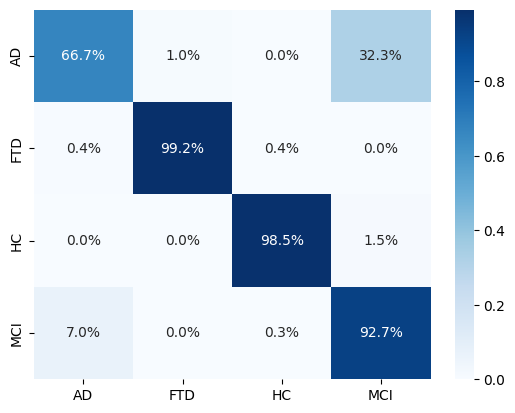

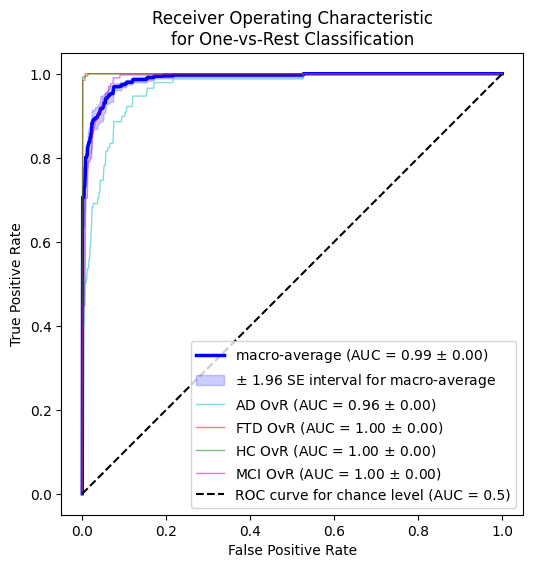

Combo 1/60


Features: True; Clinical: ['age', 'cdr_total_score', 'boston_naming_test_total', 'letter_verbal_fluency_test', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.2}, {'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.1}]

Spread of balanced accuracies:
[0.8271771771771772, 0.8862390350877193, 0.9098173515981735, 0.9055068718870539, 0.9130952380952381]
mean:  0.8883671347690724
95% confidence interval:  (0.8439696105954918, 0.9327646589426529)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
12__cid_ce__normalize_True                        5       4.20   
125__spkt_welch_density__coeff_2                  5       5.40   
14__spkt_welch_density__coeff_2                   5       5.40   
age                  

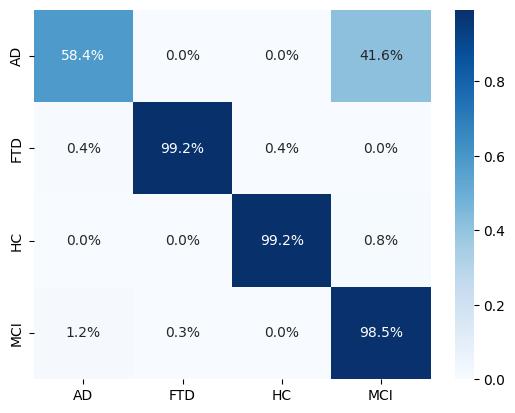

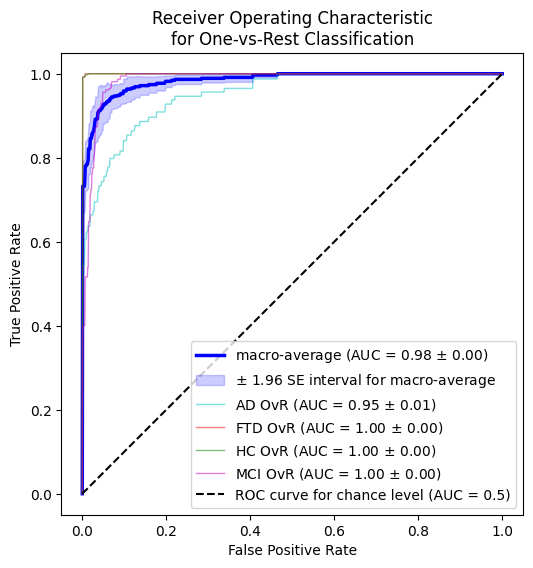

Combo 2/60


Features: True; Clinical: ['biological_sex', 'education', 'mmse_total_score', 'cdr_total_score', 'boston_naming_test_total']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.001, 'gamma': 0.4}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.8646771771771772, 0.9443530701754386, 0.9080336757990868, 0.8946235198035826, 0.9028985507246376]
mean:  0.9029171987359845
95% confidence interval:  (0.8673928332339791, 0.93844156423799)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5   3.400000   
12__cid_ce__normalize_True                        5   4.400000   
84__fft_coefficient__attr_"abs"__coeff_0          5   7.400000   
14__spkt_welch_densi

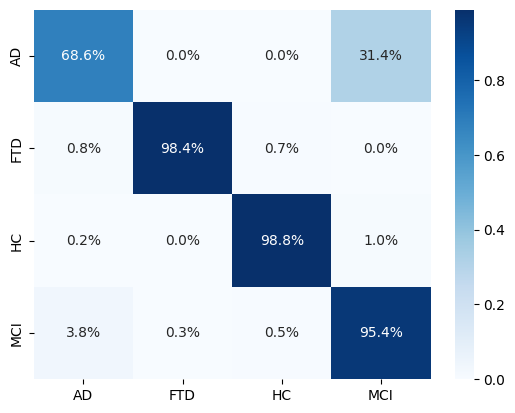

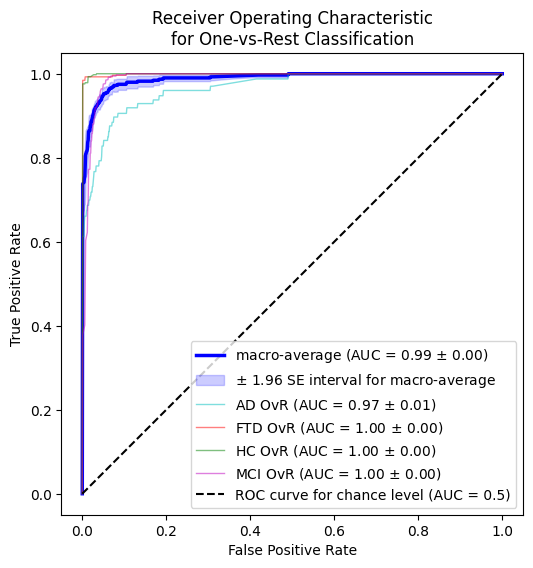

Combo 3/60


Features: True; Clinical: ['biological_sex', 'education', 'mmse_total_score', 'cdr_total_score', 'letter_verbal_fluency_test']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3}, {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3}, {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 1, 'gamma': 0.4}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}]

Spread of balanced accuracies:
[0.8521771771771771, 0.9155701754385965, 0.9010878915042768, 0.909527122035952, 0.8826604554865424]
mean:  0.892204564328509
95% confidence interval:  (0.8604375062075136, 0.9239716224495045)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5        3.6   
14__spkt_welch_density__coeff_2                   5        5.2   
12__cid_ce__normalize_True                        5        6.6   
84__fft_coefficient__att

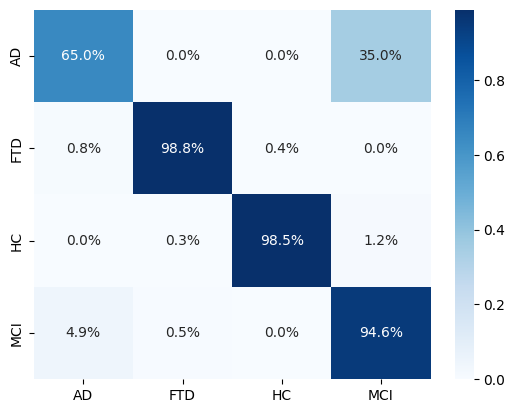

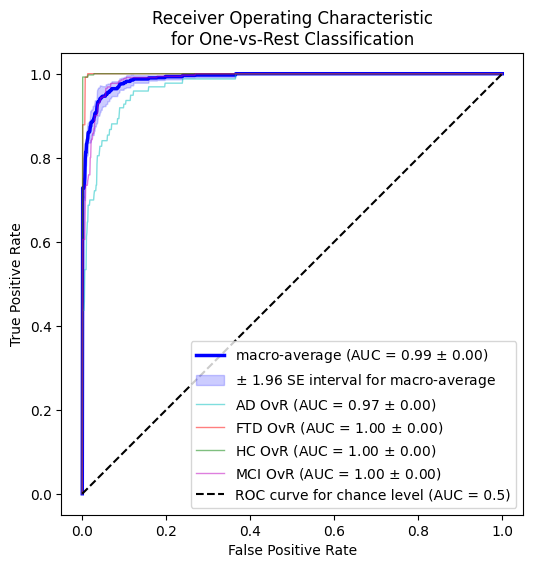

Combo 4/60


Features: True; Clinical: ['biological_sex', 'education', 'mmse_total_score', 'cdr_total_score', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 1, 'gamma': 0.4}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}]

Spread of balanced accuracies:
[0.8521771771771771, 0.9355811403508771, 0.8958795581709434, 0.9203966872533433, 0.8898033126293995]
mean:  0.8987675751163481
95% confidence interval:  (0.8591002438756727, 0.9384349063570234)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5   4.200000   
12__cid_ce__normalize_True                        5   4.600000   
14__spkt_welch_density__coeff_2                   5   6.000000   
199__fft_coefficient__

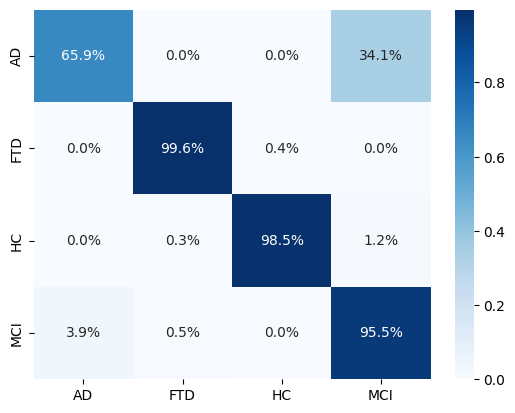

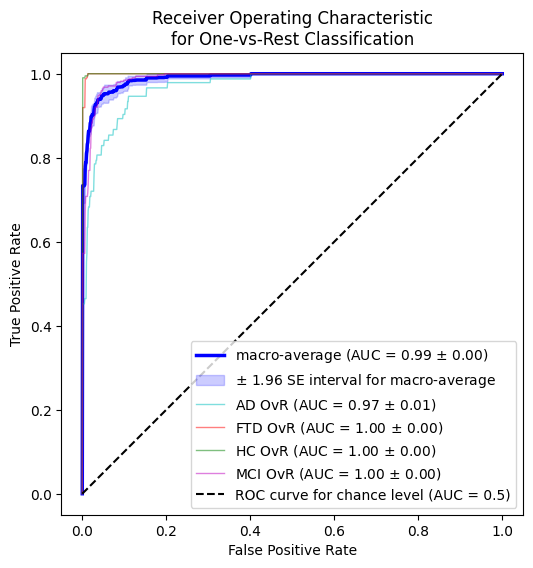

Combo 5/60


Features: True; Clinical: ['biological_sex', 'education', 'mmse_total_score', 'boston_naming_test_total', 'letter_verbal_fluency_test']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.9237987987987988, 0.9067982456140351, 0.9133847031963471, 0.9346909100049813, 0.8421842650103519]
mean:  0.9041713845249028
95% confidence interval:  (0.8591841249761318, 0.9491586440736737)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
12__cid_ce__normalize_True                        5       4.20   
125__spkt_welch_density__coeff_2                  5       4.40   
14__spkt_welch_density__coeff_2                   5       4.60   
100__spkt_welch_densit

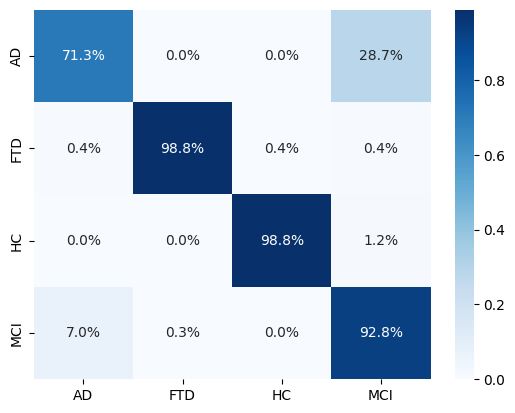

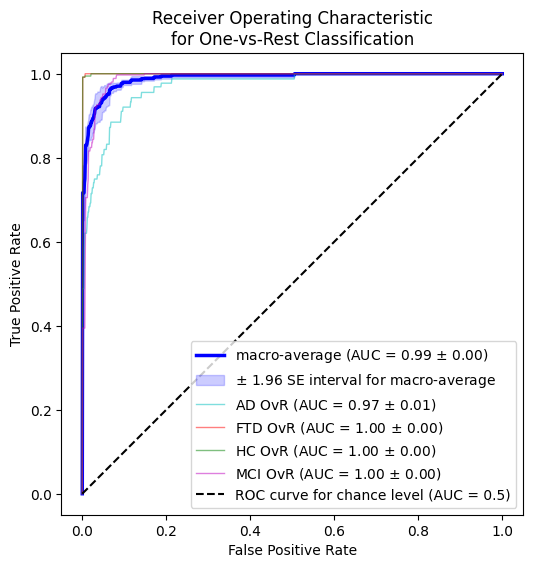

Combo 6/60


Features: True; Clinical: ['biological_sex', 'education', 'mmse_total_score', 'boston_naming_test_total', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.9146771771771771, 0.8955592105263158, 0.9011843607305936, 0.9129517795701986, 0.8695652173913043]
mean:  0.898787549079118
95% confidence interval:  (0.8762041312065827, 0.9213709669516532)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5   3.800000   
12__cid_ce__normalize_True                        5   3.800000   
14__spkt_welch_density__coeff_2                   5   5.000000   
84__fft_coefficient__att

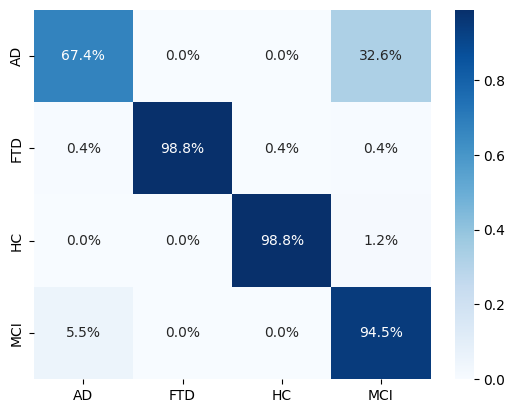

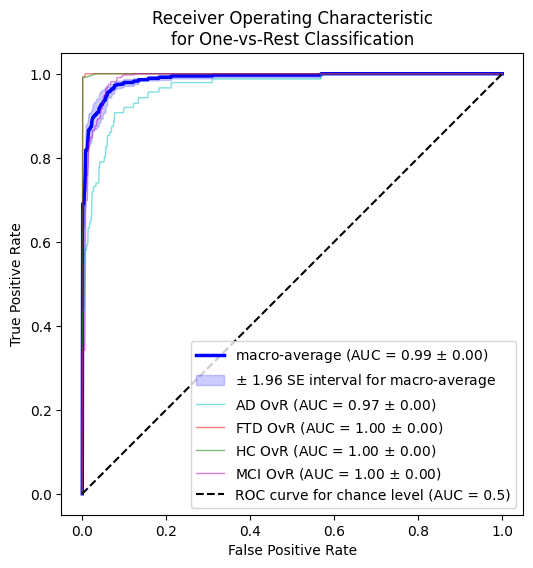

Combo 7/60


Features: True; Clinical: ['biological_sex', 'education', 'mmse_total_score', 'letter_verbal_fluency_test', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 1, 'gamma': 0.4}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 1, 'gamma': 0.4}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}]

Spread of balanced accuracies:
[0.9146771771771771, 0.8597637559808613, 0.8769725947006238, 0.9238213447875899, 0.8659937888198758]
mean:  0.8882457322932256
95% confidence interval:  (0.8520575576708728, 0.9244339069155784)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5        4.8   
14__spkt_welch_density__coeff_2                   5        4.8   
12__cid_ce__normalize_True                        5        5.8   
199__fft_coefficient__at

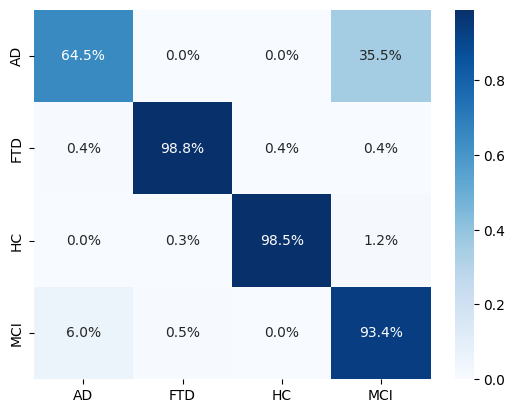

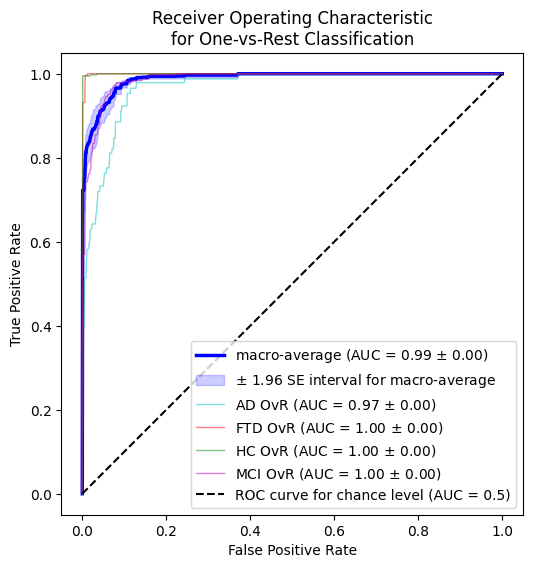

Combo 8/60


Features: True; Clinical: ['biological_sex', 'education', 'cdr_total_score', 'boston_naming_test_total', 'letter_verbal_fluency_test']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3}]

Spread of balanced accuracies:
[0.8271771771771772, 0.9331140350877193, 0.8958795581709434, 0.8952328992843142, 0.9374223602484473]
mean:  0.8977652059937202
95% confidence interval:  (0.8428825769409521, 0.9526478350464883)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
12__cid_ce__normalize_True                        5   5.400000   
125__spkt_welch_density__coeff_2                  5   5.800000   
14__spkt_welch_density__coeff_2                   5   6.200000   
164__spkt_welch_dens

/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply


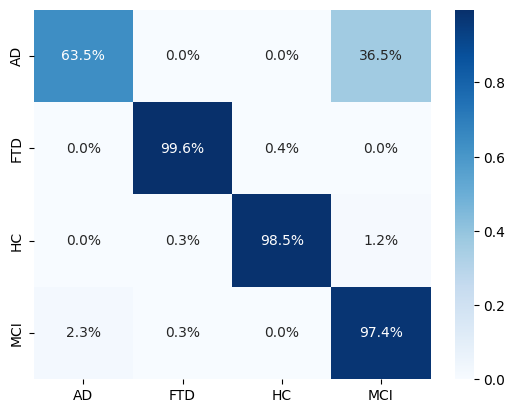

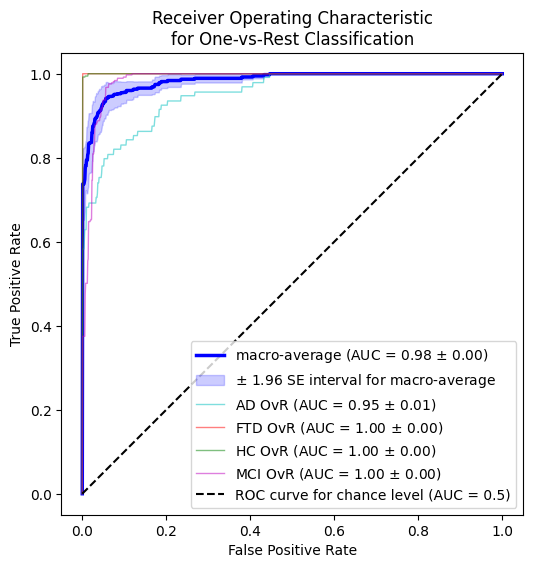

Combo 9/60


Features: True; Clinical: ['biological_sex', 'education', 'cdr_total_score', 'boston_naming_test_total', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3}, {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.8271771771771772, 0.9174890350877193, 0.8924086757990868, 0.9129517795701986, 0.9270445134575569]
mean:  0.8954142362183479
95% confidence interval:  (0.845512834393891, 0.9453156380428048)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
12__cid_ce__normalize_True                        5       3.80   
125__spkt_welch_density__coeff_2                  5       5.80   
14__spkt_welch_density__coeff_2                   5       6.20   
biological_sex         

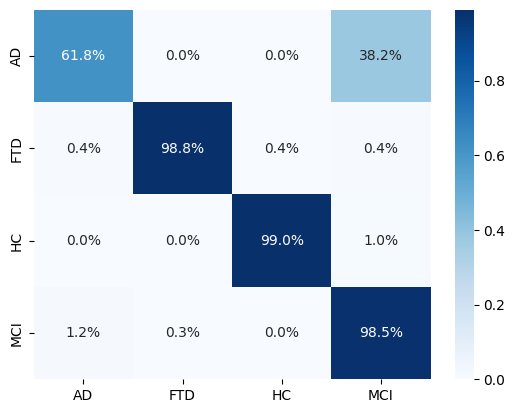

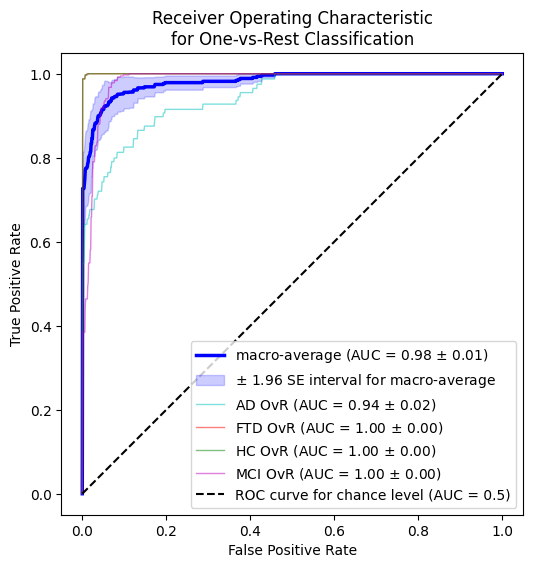

Combo 10/60


Features: True; Clinical: ['biological_sex', 'education', 'cdr_total_score', 'letter_verbal_fluency_test', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.1}, {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.0}, {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 1, 'gamma': 0.4}, {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0}]

Spread of balanced accuracies:
[0.806396838014485, 0.9243421052631579, 0.8821347031963471, 0.8986575568185607, 0.9267080745341616]
mean:  0.8876478555653424
95% confidence interval:  (0.8267382407817397, 0.9485574703489451)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5   4.200000   
84__fft_coefficient__attr_"abs"__coeff_0          5   6.000000   
12__cid_ce__normalize_True                        5   6.200000   
14__spkt_welch_density_

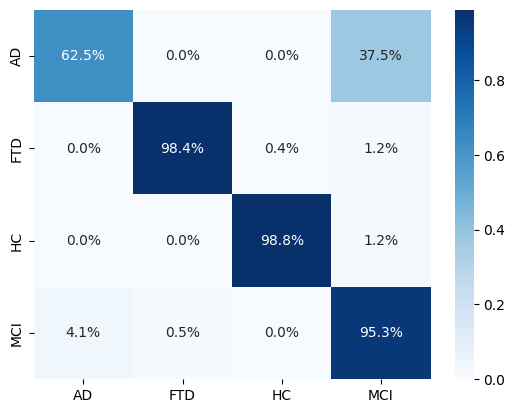

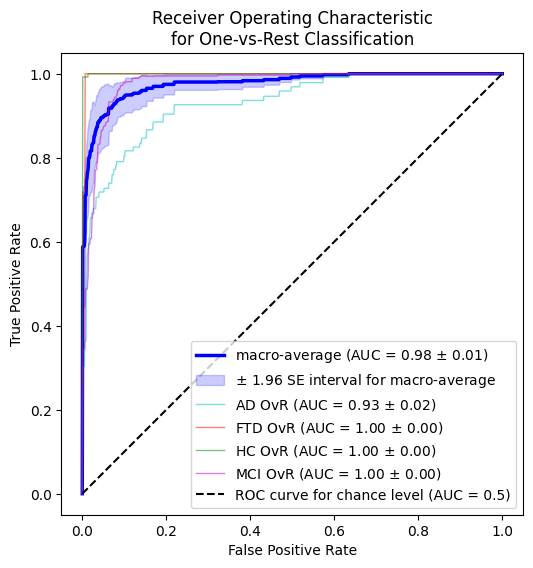

Combo 11/60


Features: True; Clinical: ['biological_sex', 'education', 'boston_naming_test_total', 'letter_verbal_fluency_test', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.0}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.2}, {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.001, 'gamma': 0.4}]

Spread of balanced accuracies:
[0.7831081081081082, 0.7436951754385965, 0.7746860730593608, 0.7362096711723427, 0.7758540372670807]
mean:  0.7627106130090978
95% confidence interval:  (0.7363994493932713, 0.7890217766249243)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
12__cid_ce__normalize_True                        5       2.40   
125__spkt_welch_density__coeff_2                  5       4.80   
14__spkt_welch_density__coeff_2                   5       6.00   
199__fft_coeffic

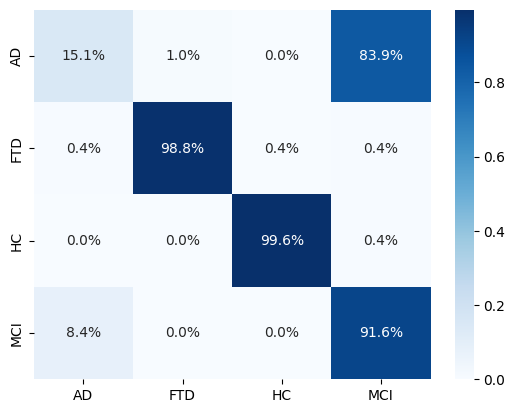

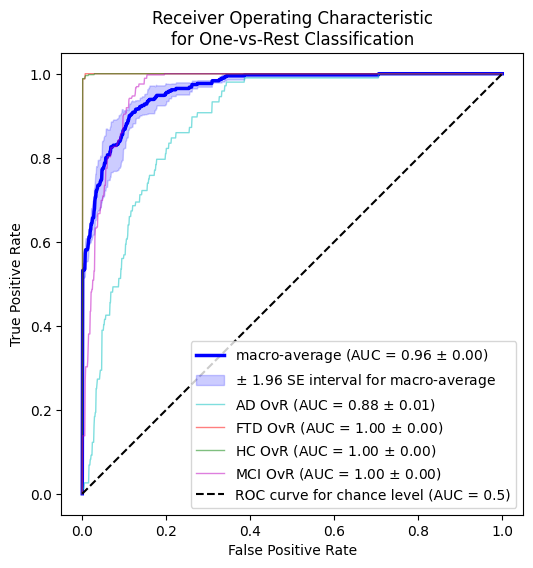

Combo 12/60


Features: True; Clinical: ['biological_sex', 'mmse_total_score', 'cdr_total_score', 'boston_naming_test_total', 'letter_verbal_fluency_test']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 1, 'gamma': 0.4}, {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 1, 'gamma': 0.4}]

Spread of balanced accuracies:
[0.8771771771771771, 0.9311951754385965, 0.9011843607305936, 0.909527122035952, 0.9010704874835309]
mean:  0.9040308645731701
95% confidence interval:  (0.8799373387142273, 0.9281243904321128)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
12__cid_ce__normalize_True                        5       3.20   
125__spkt_welch_density__coeff_2                  5       3.40   
14__spkt_welch_density__coeff_2                   5       7.40   
164__spkt_welch_density__coe

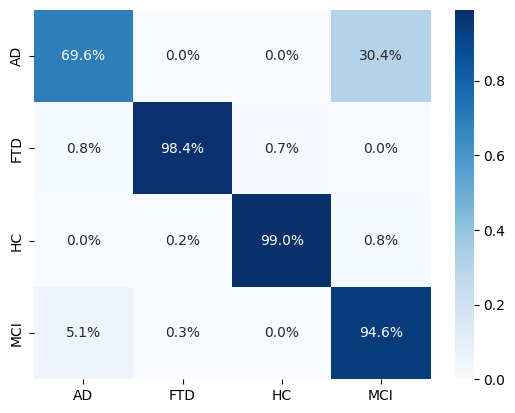

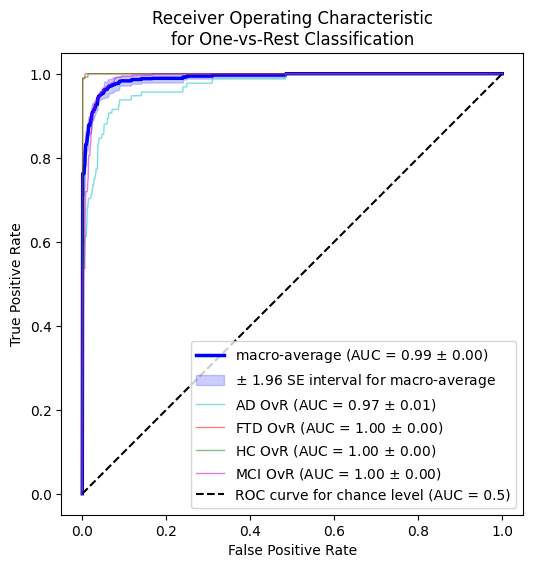

Combo 13/60


Features: True; Clinical: ['biological_sex', 'mmse_total_score', 'cdr_total_score', 'boston_naming_test_total', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 1, 'gamma': 0.4}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}]

Spread of balanced accuracies:
[0.8896771771771772, 0.9355811403508771, 0.8977597031963471, 0.9129517795701986, 0.9028985507246376]
mean:  0.9077736702038475
95% confidence interval:  (0.8858099221238116, 0.9297374182838833)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5       4.00   
12__cid_ce__normalize_True                        5       4.60   
14__spkt_welch_density__coeff_2                   5       6.60   
199__fft_coefficient

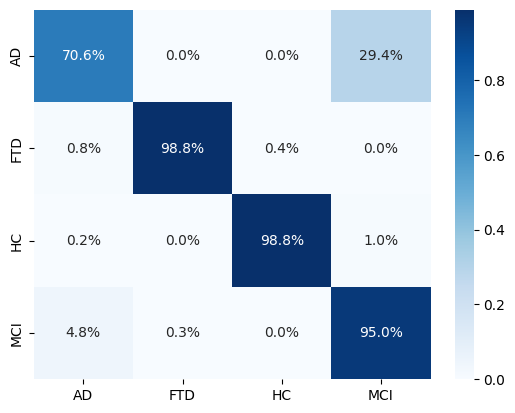

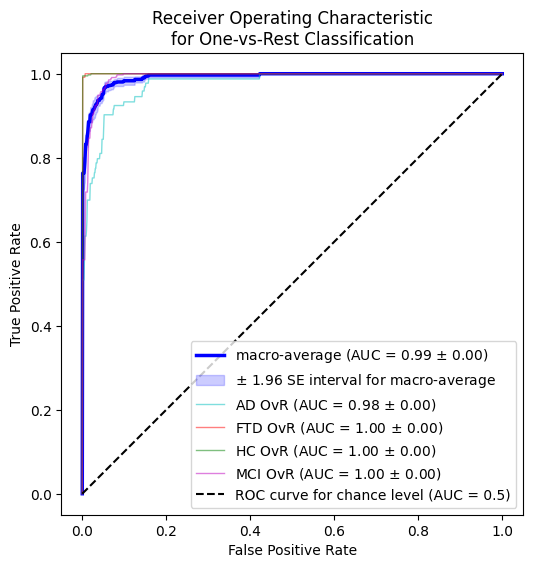

Combo 14/60


Features: True; Clinical: ['biological_sex', 'mmse_total_score', 'cdr_total_score', 'letter_verbal_fluency_test', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.8347752163928635, 0.9043311403508771, 0.8977597031963471, 0.9387111601538793, 0.8862318840579709]
mean:  0.8923618208303876
95% confidence interval:  (0.8455951758483632, 0.939128465812412)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
12__cid_ce__normalize_True                        5   4.200000   
125__spkt_welch_density__coeff_2                  5   4.400000   
199__fft_coefficient__attr_"abs"__coeff_0         5   5.800000   
84__fft_coefficient__

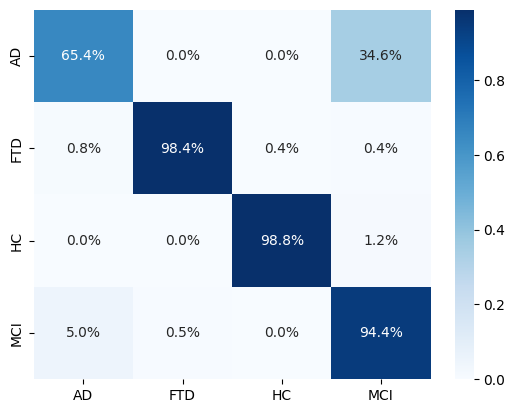

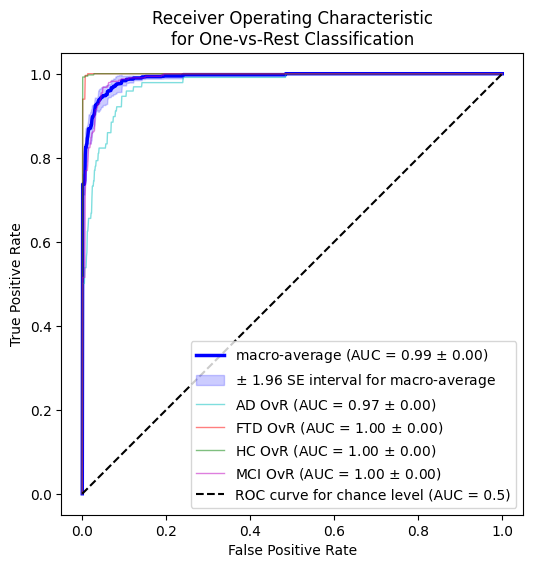

Combo 15/60


Features: True; Clinical: ['biological_sex', 'mmse_total_score', 'boston_naming_test_total', 'letter_verbal_fluency_test', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.0}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 1, 'gamma': 0.4}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.8762575075075075, 0.8887061403508771, 0.9133847031963471, 0.909527122035952, 0.8421842650103519]
mean:  0.8860119476202071
95% confidence interval:  (0.8502103112410813, 0.9218135839993329)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5   2.800000   
12__cid_ce__normalize_True                        5   4.600000   
14__spkt_welch_density__coeff_2                   5   6.000000   
84__fft_coefficient__at

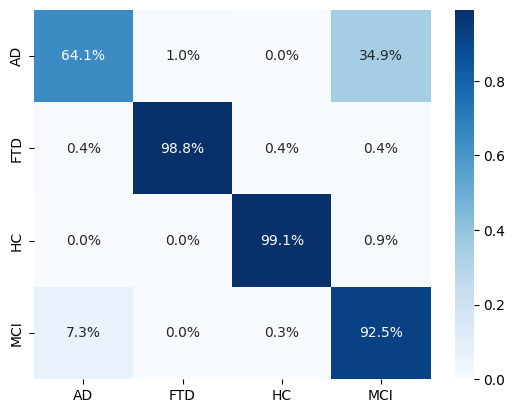

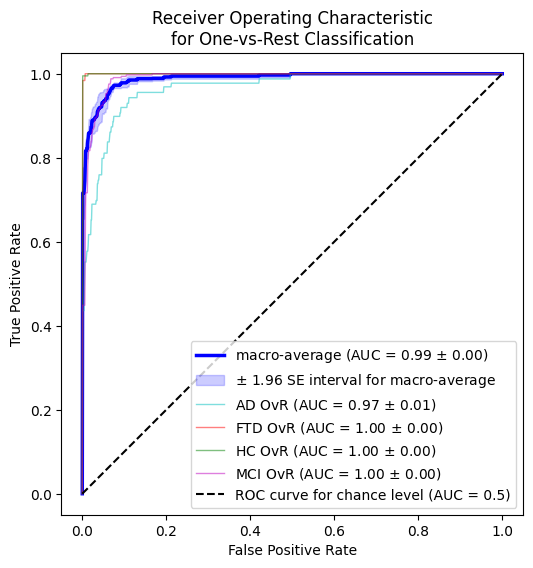

Combo 16/60


Features: True; Clinical: ['biological_sex', 'cdr_total_score', 'boston_naming_test_total', 'letter_verbal_fluency_test', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.8271771771771772, 0.9047488512949039, 0.8975205399061033, 0.9129517795701986, 0.9130952380952381]
mean:  0.8910987172087242
95% confidence interval:  (0.8460084771790753, 0.9361889572383731)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
12__cid_ce__normalize_True                        5        3.6   
14__spkt_welch_density__coeff_2                   5        5.4   
125__spkt_welch_density__coeff_2                  5        5.8   
biological_sex        

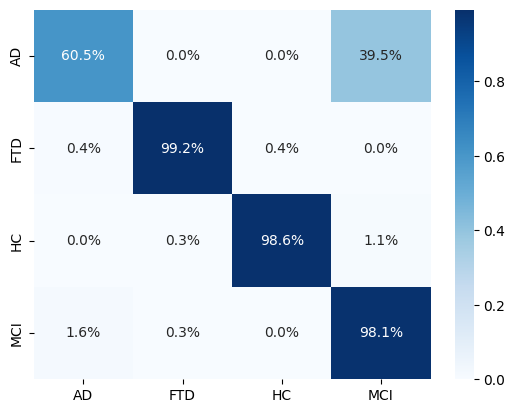

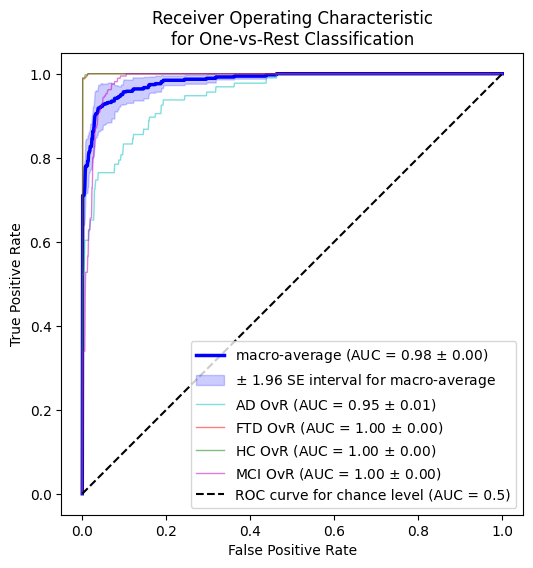

Combo 17/60


Features: True; Clinical: ['education', 'mmse_total_score', 'cdr_total_score', 'boston_naming_test_total', 'letter_verbal_fluency_test']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.001, 'gamma': 0.4}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.8771771771771771, 0.9399671052631579, 0.9236586757990868, 0.9054930850209739, 0.8826604554865424]
mean:  0.9057912997493875
95% confidence interval:  (0.8726996047693705, 0.9388829947294046)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5   3.400000   
12__cid_ce__normalize_True                        5   4.800000   
100__spkt_welch_density__coeff_2                  5   7.600000   
14__spkt_welch_den

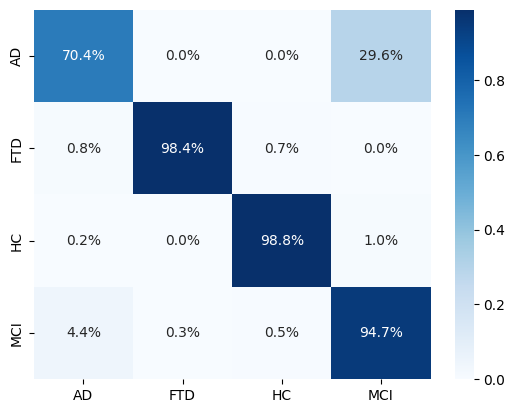

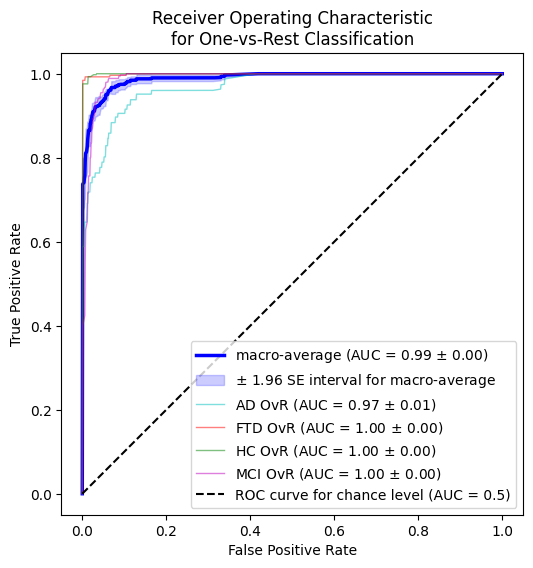

Combo 18/60


Features: True; Clinical: ['education', 'mmse_total_score', 'cdr_total_score', 'boston_naming_test_total', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 1, 'gamma': 0.4}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.8771771771771771, 0.9512061403508771, 0.8907676940639269, 0.909527122035952, 0.9195652173913044]
mean:  0.9096486702038474
95% confidence interval:  (0.8743306671284355, 0.9449666732792593)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5        2.6   
12__cid_ce__normalize_True                        5        5.0   
14__spkt_welch_density__coeff_2                   5        5.6   
67__fft_coefficient__attr_

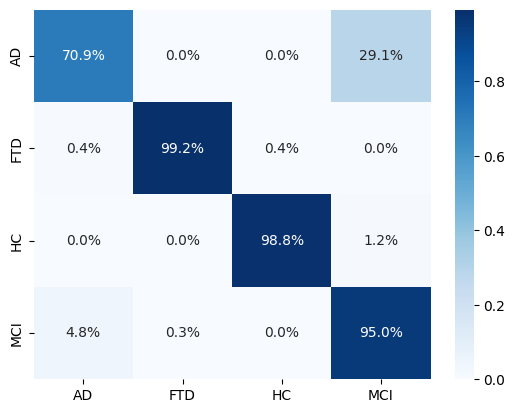

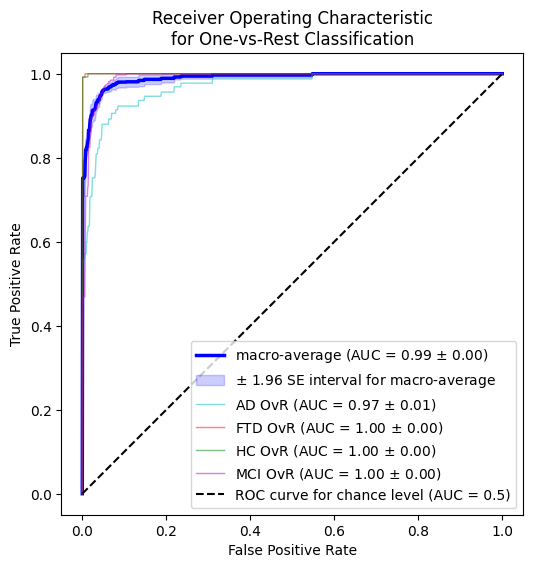

Combo 19/60


Features: True; Clinical: ['education', 'mmse_total_score', 'cdr_total_score', 'letter_verbal_fluency_test', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.0}, {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.8472752163928634, 0.9222637559808613, 0.8958795581709434, 0.9203966872533433, 0.8862318840579709]
mean:  0.8944094203711964
95% confidence interval:  (0.8564326208331291, 0.9323862199092637)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5   4.200000   
14__spkt_welch_density__coeff_2                   5   5.200000   
12__cid_ce__normalize_True                        5   6.200000   
84__fft_coefficient_

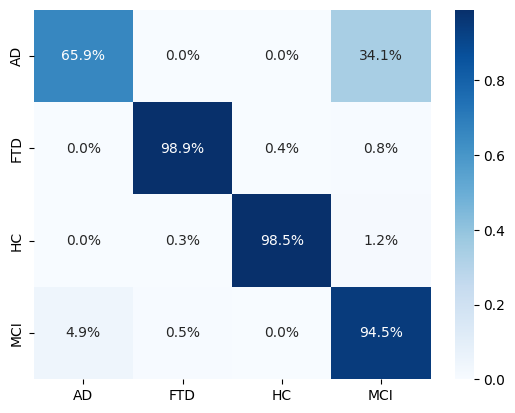

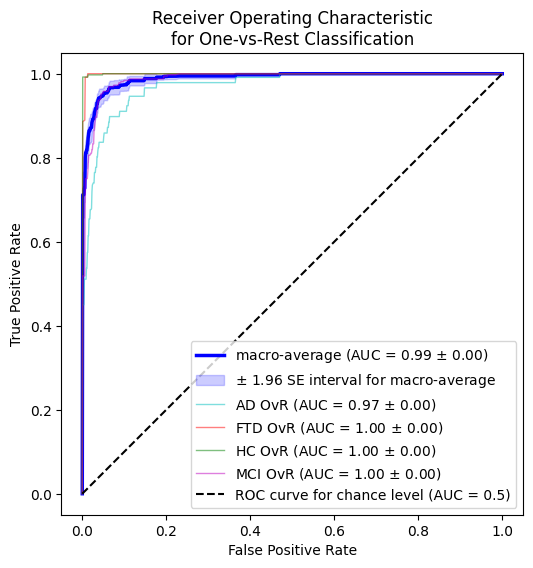

Combo 20/60


Features: True; Clinical: ['education', 'mmse_total_score', 'boston_naming_test_total', 'letter_verbal_fluency_test', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.9079204204204203, 0.8911732456140351, 0.9099600456621004, 0.9020822143528073, 0.849327122153209]
mean:  0.8920926096405145
95% confidence interval:  (0.8610554227697977, 0.9231297965112313)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5        3.6   
12__cid_ce__normalize_True                        5        4.8   
14__spkt_welch_density__coeff_2                   5        5.6   
164__spkt_welch_density_

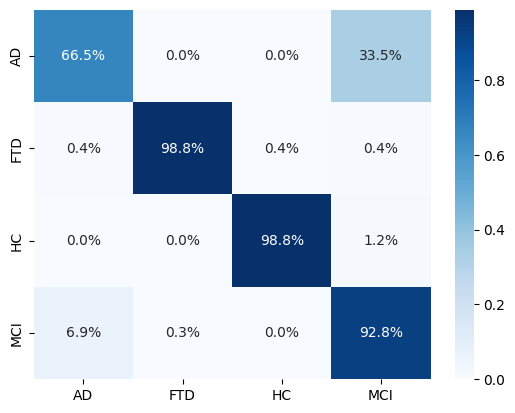

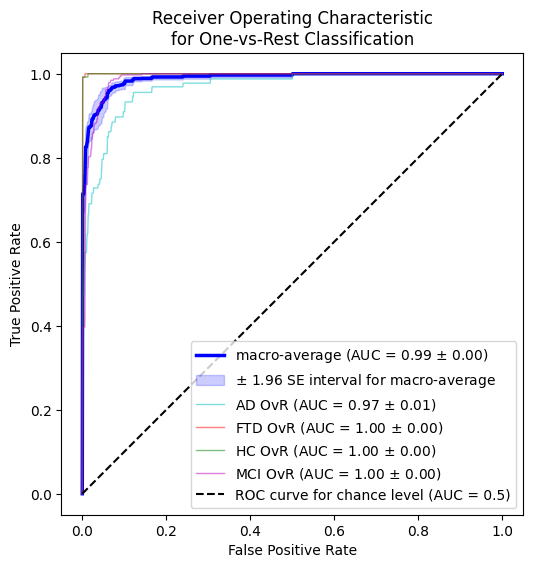

Combo 21/60


Features: True; Clinical: ['education', 'cdr_total_score', 'boston_naming_test_total', 'letter_verbal_fluency_test', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.1}, {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3}]

Spread of balanced accuracies:
[0.8271771771771772, 0.921875, 0.89761700913242, 0.891212649135416, 0.9374223602484473]
mean:  0.8950608391386922
95% confidence interval:  (0.8425903169988399, 0.9475313612785444)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
12__cid_ce__normalize_True                        5        4.6   
14__spkt_welch_density__coeff_2                   5        6.0   
125__spkt_welch_density__coeff_2                  5        6.2   
100__spkt_welch_density__coeff_2   

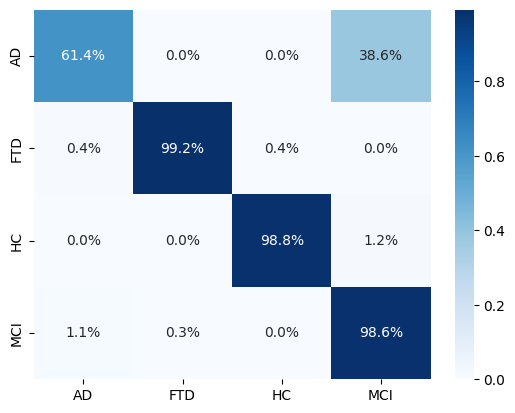

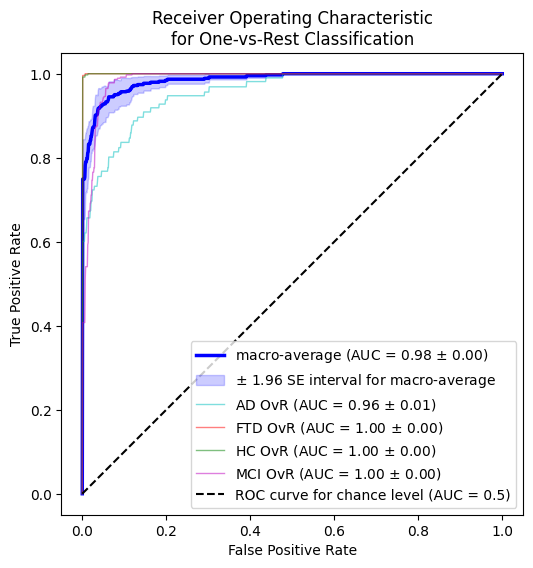

Combo 22/60


Features: True; Clinical: ['mmse_total_score', 'cdr_total_score', 'boston_naming_test_total', 'letter_verbal_fluency_test', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 1, 'gamma': 0.4}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}]

Spread of balanced accuracies:
[0.8771771771771771, 0.9555921052631579, 0.9168093607305936, 0.9203966872533433, 0.8790890269151138]
mean:  0.9098128714678773
95% confidence interval:  (0.8692646542702894, 0.9503610886654651)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5        4.2   
12__cid_ce__normalize_True                        5        5.4   
14__spkt_welch_density__coeff_2                   5        7.0   
164__spkt_welch_densit

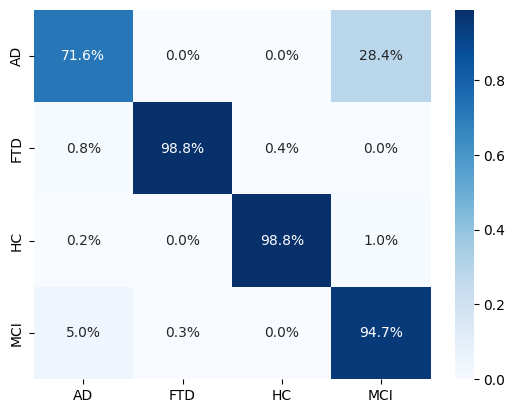

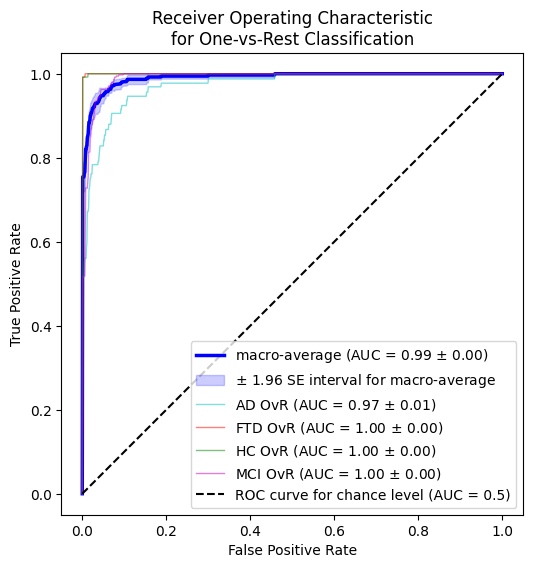

Combo 23/60


Features: True; Clinical: ['age', 'biological_sex', 'education', 'mmse_total_score', 'cdr_total_score', 'boston_naming_test_total']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.0}, {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 1, 'gamma': 0.4}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.8646771771771772, 0.9512061403508771, 0.9115045581709434, 0.9129517795701986, 0.8898033126293995]
mean:  0.9060285935797193
95% confidence interval:  (0.8663141360436808, 0.9457430511157578)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5   2.400000   
12__cid_ce__normalize_True                        5   4.200000   
164__spkt_welch_density__coeff_2                  5   7.000000   
84__fft_coefficient__at

/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply


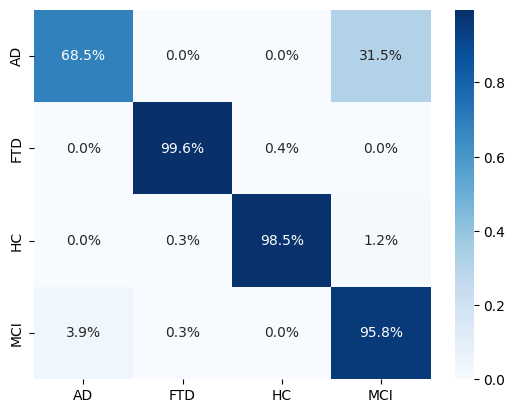

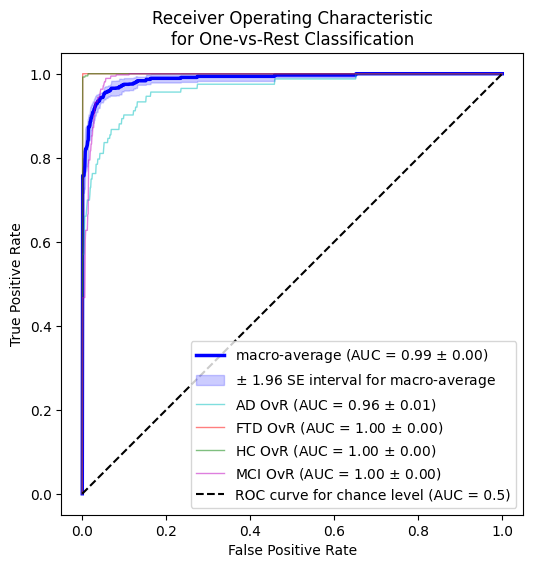

Combo 24/60


Features: True; Clinical: ['age', 'biological_sex', 'education', 'mmse_total_score', 'cdr_total_score', 'letter_verbal_fluency_test']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.001, 'gamma': 0.4}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.8646771771771772, 0.9111842105263158, 0.8820382339700302, 0.9129517795701986, 0.8790890269151138]
mean:  0.8899880856317672
95% confidence interval:  (0.8636539856371558, 0.9163221856263787)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5   4.000000   
164__spkt_welch_density__coeff_2                  5   4.600000   
12__cid_ce__normalize_True                        5   4.800000   
14__spkt_welch_den

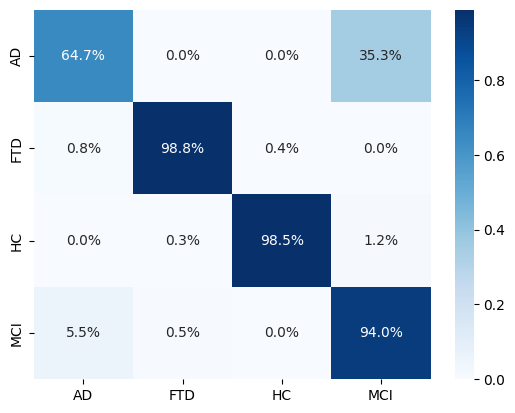

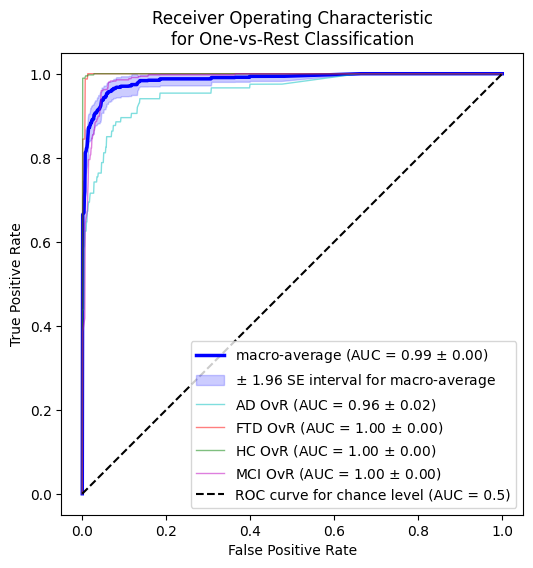

Combo 25/60


Features: True; Clinical: ['age', 'biological_sex', 'education', 'mmse_total_score', 'cdr_total_score', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.0}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.2}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}]

Spread of balanced accuracies:
[0.806396838014485, 0.9110247208931419, 0.8994006849315068, 0.9346909100049813, 0.8898033126293995]
mean:  0.8882632932947029
95% confidence interval:  (0.8277452732983235, 0.9487813132910823)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
199__fft_coefficient__attr_"abs"__coeff_0         5   5.400000   
12__cid_ce__normalize_True                        5   5.600000   
84__fft_coefficient__attr_"abs"__coeff_0          5   6.400000   
164__spkt_welch_d

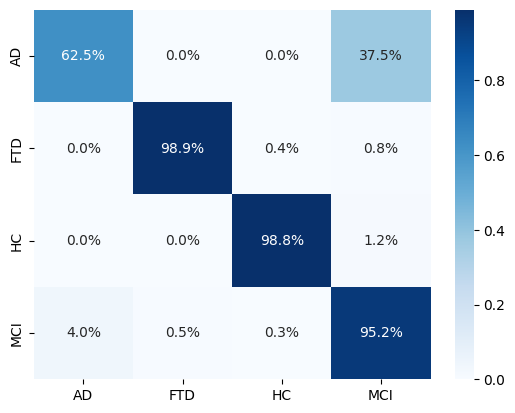

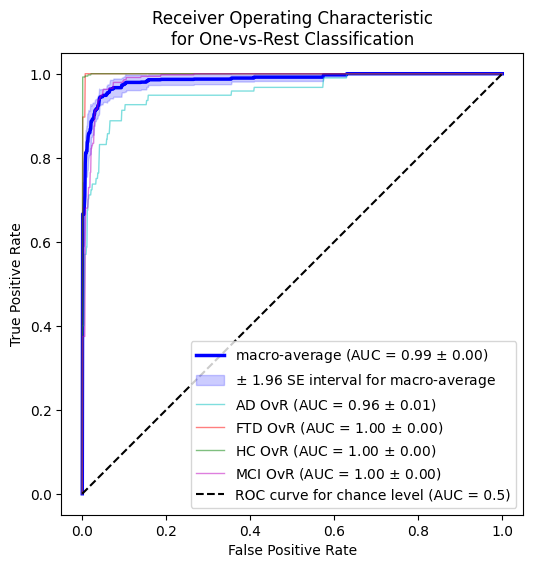

Combo 26/60


Features: True; Clinical: ['age', 'biological_sex', 'education', 'mmse_total_score', 'boston_naming_test_total', 'letter_verbal_fluency_test']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.0}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 1, 'gamma': 0.4}, {'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.0}]

Spread of balanced accuracies:
[0.8862987987987989, 0.9111842105263158, 0.8977597031963471, 0.8877879916011694, 0.8678571428571429]
mean:  0.8901775693959548
95% confidence interval:  (0.8703719182733342, 0.9099832205185755)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5   4.400000   
12__cid_ce__normalize_True                        5   5.000000   
14__spkt_welch_density__coeff_2                   5   5.200000   
199__fft_coefficient_

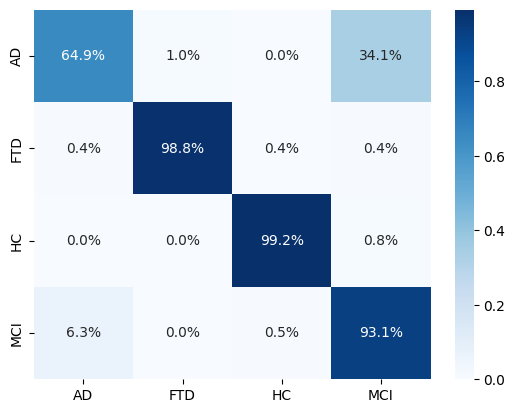

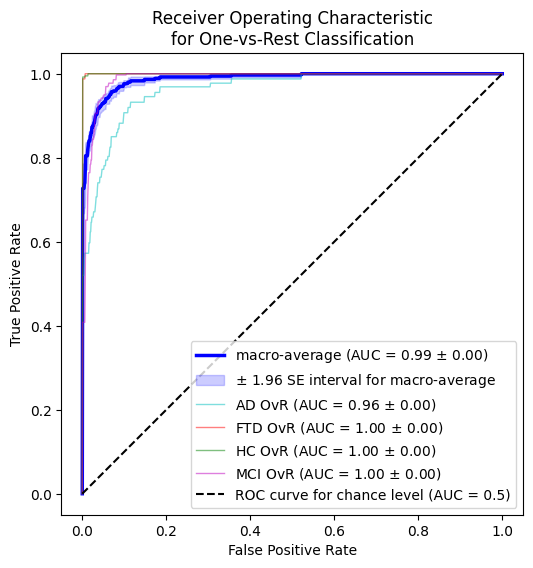

Combo 27/60


Features: True; Clinical: ['age', 'biological_sex', 'education', 'mmse_total_score', 'boston_naming_test_total', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 1, 'gamma': 0.4}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.9112987987987988, 0.8686951754385965, 0.8787100456621004, 0.8952328992843142, 0.8731366459627329]
mean:  0.8854147130293086
95% confidence interval:  (0.8635386061557111, 0.9072908199029062)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5   2.400000   
12__cid_ce__normalize_True                        5   4.600000   
84__fft_coefficient__attr_"abs"__coeff_0          5   6.200000   
14__spkt_welch_density_

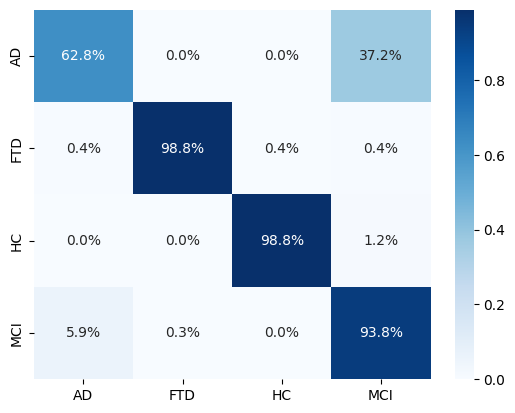

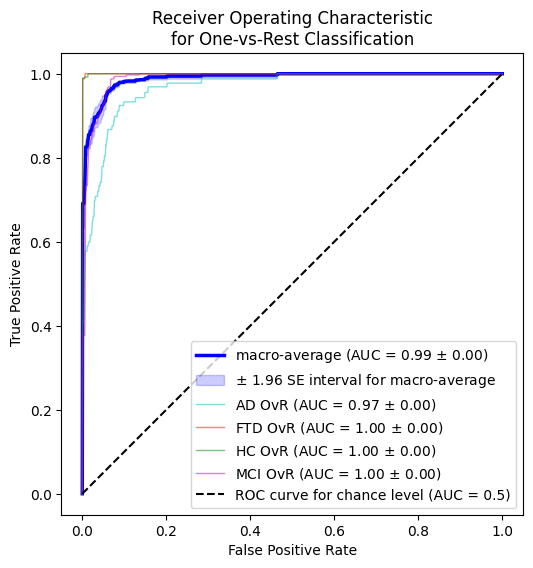

Combo 28/60


Features: True; Clinical: ['age', 'biological_sex', 'education', 'mmse_total_score', 'letter_verbal_fluency_test', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.8938968380144852, 0.8618421052631579, 0.873644406392694, 0.9163764371044452, 0.8659937888198758]
mean:  0.8823507151189316
95% confidence interval:  (0.8542069917560466, 0.9104944384818165)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5   3.600000   
12__cid_ce__normalize_True                        5   4.400000   
14__spkt_welch_density__coeff_2                   5   6.000000   
84__fft_coefficient__a

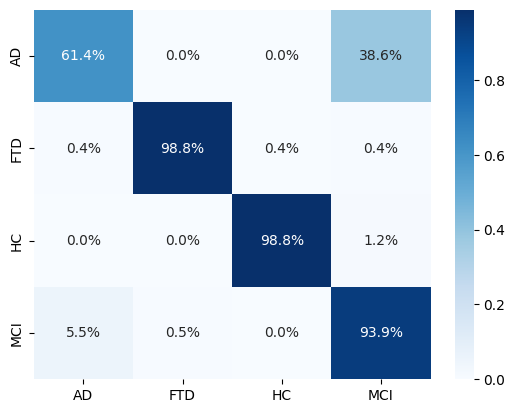

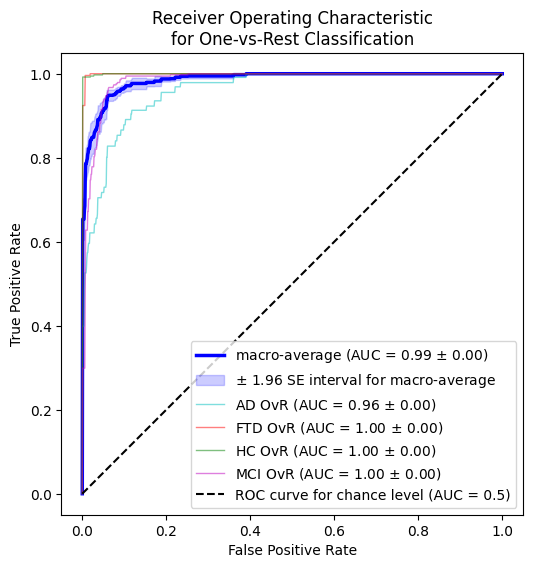

Combo 29/60


Features: True; Clinical: ['age', 'biological_sex', 'education', 'cdr_total_score', 'boston_naming_test_total', 'letter_verbal_fluency_test']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.0}, {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.001, 'gamma': 0.4}, {'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.1}]

Spread of balanced accuracies:
[0.8271771771771772, 0.9287280701754386, 0.9028253424657534, 0.8848672279909034, 0.9297619047619048]
mean:  0.8946719445142355
95% confidence interval:  (0.8423255381716891, 0.9470183508567819)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
12__cid_ce__normalize_True                        5   4.400000   
125__spkt_welch_density__coeff_2                  5   5.000000   
14__spkt_welch_density__coeff_2                   5   5.200000   
164__spkt_welch_d

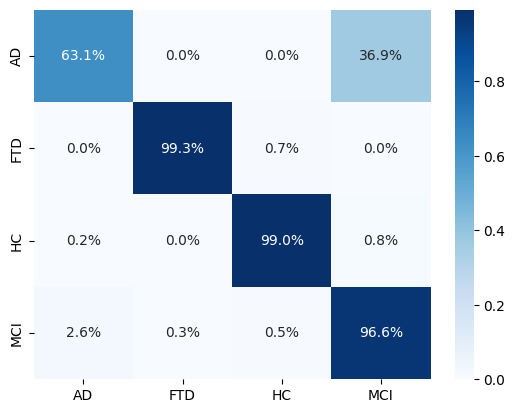

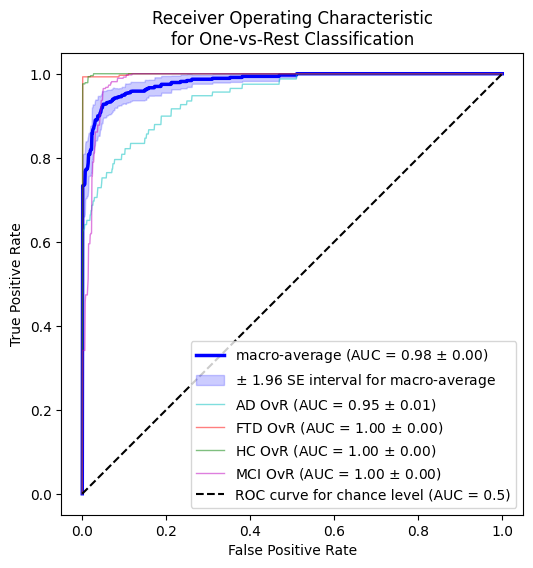

Combo 30/60


Features: True; Clinical: ['age', 'biological_sex', 'education', 'cdr_total_score', 'boston_naming_test_total', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3}, {'n_estimators': 1800, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.2}, {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.001, 'gamma': 0.4}, {'n_estimators': 1800, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.8271771771771772, 0.9174890350877193, 0.9027288732394366, 0.88829188552515, 0.9333333333333333]
mean:  0.8938040608725633
95% confidence interval:  (0.8430903344466342, 0.9445177872984923)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
12__cid_ce__normalize_True                        5        4.2   
125__spkt_welch_density__coeff_2                  5        4.4   
14__spkt_welch_density__coeff_2                   5        6.2   
164__spkt_welch_den

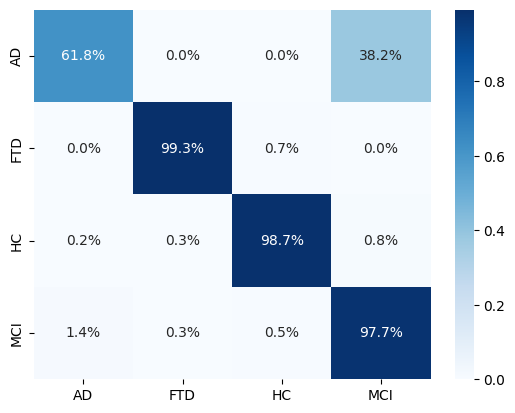

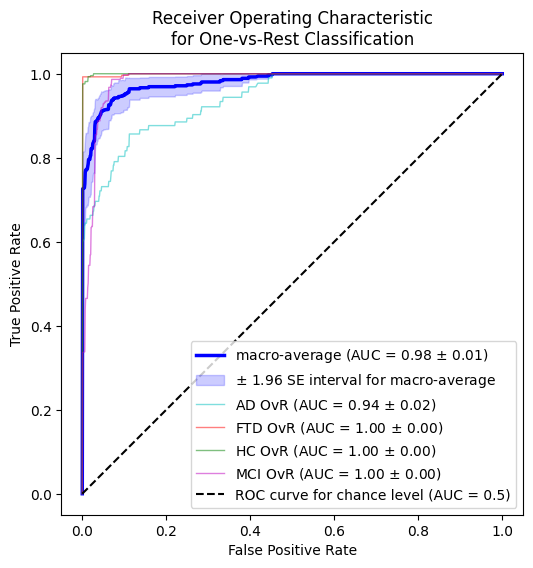

Combo 31/60


Features: True; Clinical: ['age', 'biological_sex', 'education', 'cdr_total_score', 'letter_verbal_fluency_test', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.1}, {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 1, 'gamma': 0.4}, {'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.1}]

Spread of balanced accuracies:
[0.8014948772301713, 0.8529106858054227, 0.9028253424657534, 0.8449053233462558, 0.9285714285714285]
mean:  0.8661415314838063
95% confidence interval:  (0.8039082227854122, 0.9283748401822005)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
12__cid_ce__normalize_True                        5   4.600000   
125__spkt_welch_density__coeff_2                  5   6.000000   
84__fft_coefficient__attr_"abs"__coeff_0          5   6.000000   
14__spkt_welch_density

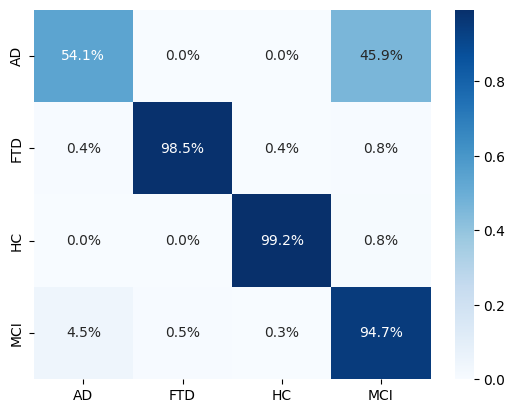

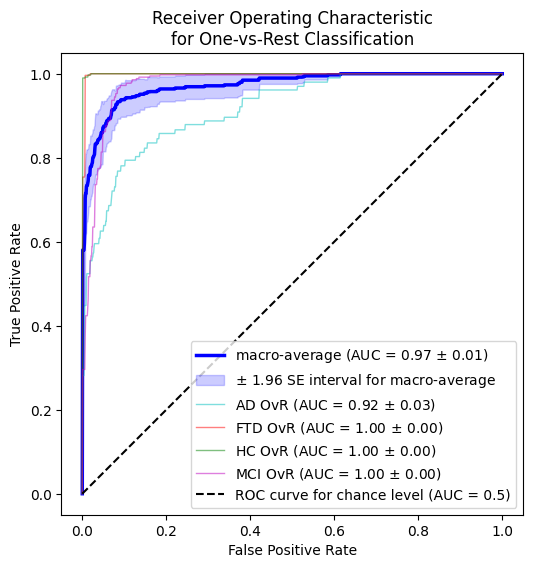

Combo 32/60


Features: True; Clinical: ['age', 'biological_sex', 'education', 'boston_naming_test_total', 'letter_verbal_fluency_test', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.0}, {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.001, 'gamma': 0.4}, {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3}, {'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.1}]

Spread of balanced accuracies:
[0.7921358858858859, 0.7261513157894737, 0.8025114155251142, 0.7722430243587632, 0.7460921325051759]
mean:  0.7678267548128825
95% confidence interval:  (0.7284506400322787, 0.8072028695934864)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
12__cid_ce__normalize_True                        5   2.800000   
125__spkt_welch_density__coeff_2                  5   4.200000   
14__spkt_welch_density__coeff_2                   5   5.200000   
199__fft_coefficie

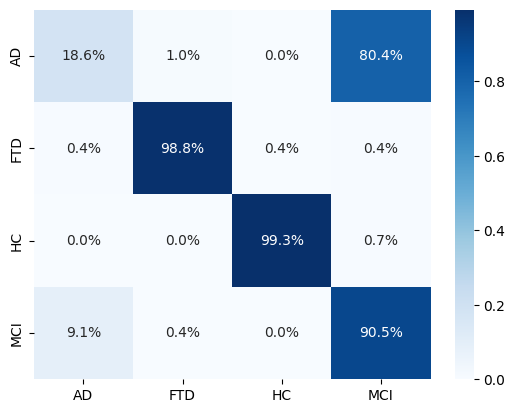

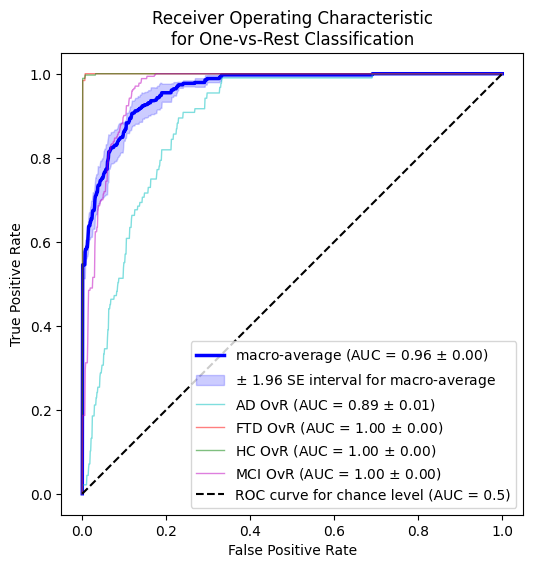

Combo 33/60


Features: True; Clinical: ['age', 'biological_sex', 'mmse_total_score', 'cdr_total_score', 'boston_naming_test_total', 'letter_verbal_fluency_test']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.001, 'gamma': 0.4}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}]

Spread of balanced accuracies:
[0.8771771771771771, 0.9199561403508771, 0.9168093607305936, 0.9054930850209739, 0.8719461697722567]
mean:  0.8982763866103758
95% confidence interval:  (0.8704840425106157, 0.9260687307101358)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5   4.400000   
12__cid_ce__normalize_True                        5   5.200000   
164__spkt_welch_density__coeff_2                  5   6.000000   
14__spkt_welch_de

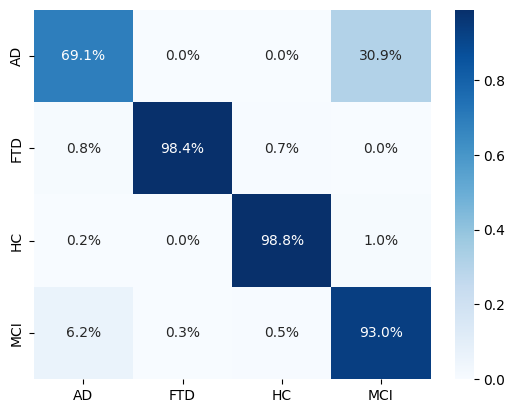

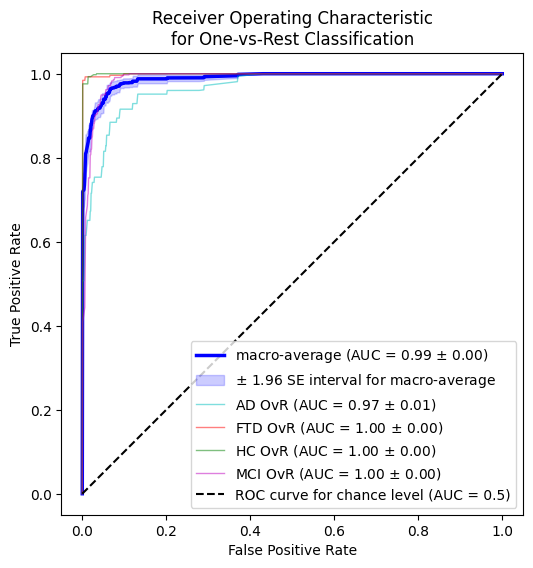

Combo 34/60


Features: True; Clinical: ['age', 'biological_sex', 'mmse_total_score', 'cdr_total_score', 'boston_naming_test_total', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.8771771771771771, 0.9512061403508771, 0.9011843607305936, 0.9129517795701986, 0.9100414078674948]
mean:  0.9105121731392682
95% confidence interval:  (0.8773083835434875, 0.943715962735049)


Feature importances:
                                            feature  rank_mean  \
feature                                                          
125__spkt_welch_density__coeff_2                  5       4.20   
12__cid_ce__normalize_True                        5       6.00   
14__spkt_welch_density__coeff_2                   5       6.80   
84__fft_coefficient__a

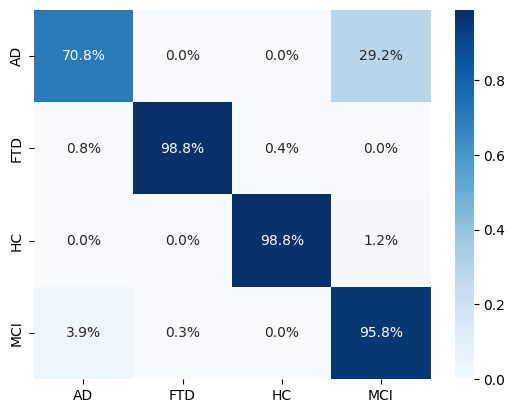

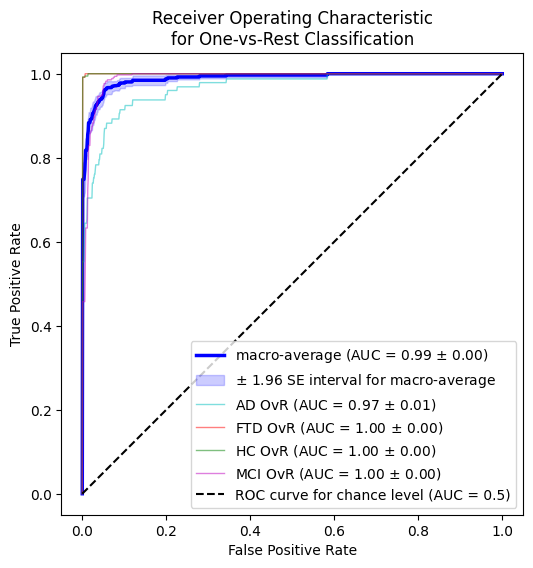

Combo 35/60


Features: True; Clinical: ['age', 'biological_sex', 'mmse_total_score', 'cdr_total_score', 'letter_verbal_fluency_test', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
all_model_results = []

for i, combo in enumerate(all_combos):

  print(f'Combo {i}/{len(all_combos)}')

  clinical_features = combo[0]
  include_features = combo[1]

  output = run_pipeline(include_features = include_features,
                        include_clinical = True,
                        clinical_features = clinical_features,
                        splits = scan_splits,
                        params = params,
                        n_folds = n_folds,
                        random_state = random_state,
                        plot_results = True,
                        save_image = False,
                        draw_dtreeviz = False,
                        image_name = '')

  all_model_results.append({
      'include_features': output[0], # include_features in run_pipeline output
      'include_clinical': output[1], # include_clinical in run_pipeline output
      'clinical_features': ', '.join(output[2]), # clinical_features in run_pipeline output
      'test_set_balanced_accuracy_mean': output[3], # mean_balanced_accuracies in run_pipeline output
      'test_set_balanced_accuracy_95%_confidence_interval_lower_bound': output[4], # balanced_accuracies_interval[0] in run_pipeline output
      'test_set_balanced_accuracy_95%_confidence_interval_upper_bound': output[5], # balanced_accuracies_interval[1] in run_pipeline output
      'test_set_accuracy_in_ad_group_mean': output[6], # average_cm[0,0] in run_pipeline output
      'test_set_macro_average_auc_mean': output[7], # mean_macro_auc in run_pipeline output
      'test_set_macro_average_auc_95%_confidence_interval_lower_bound': output[8], # macro_auc_interval[0] in run_pipeline output
      'test_set_macro_average_auc_95%_confidence_interval_upper_bound': output[9] # macro_auc_interval[1] in run_pipeline output
  })

In [ ]:
all_model_results_df = pd.DataFrame.from_dict(all_model_results)

all_model_results_df.to_csv('./paper_absolute_final/data/S2.csv', index = False)

## Paper results and figures

### Only features



Features: True; Clinical: False



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.0}, {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.0}, {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3}]

Spread of balanced accuracies:
[0.7142857142857143, 0.75, 0.756547619047619, 0.7836021505376345, 0.7261904761904762]
mean:  0.7461251920122888
95% confidence interval:  (0.712466541530602, 0.7797838424939756)

Spread of Required Criteria:
mean: 
array([[ 0.27,  0.93,  0.06,  0.98,  0.1 ,  1.14,  0.96],
       [ 0.99,  0.99,  0.99,  1.  ,  0.99, 11.99,  0.01],
       [ 0.99,  1.  ,  0.99,  1.  ,  0.99, 11.6 ,  0.01],
       [ 0.76,  0.98,  0.94,  0.91,  0.84, 10.52,  0.06]])
95% confidence interval negative: 
array([[ -0.27,   0.92,  -0.04,   0.96,  -0.07,  -2.03,   0.84],
       [  0.97,  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ad aucs:
[0.7492492492492493, 0.9071214071214071, 0.8393393393393394, 0.8580246913580247, 0.8918918918918919]
mean:  0.8491253157919825
95% confidence interval:  (0.7722255058605382, 0.9260251257234268)


ftd aucs:
[0.9994994994994995, 0.9994994994994995, 0.998365031698365, 0.9994994994994995, 0.9994994994994995]
mean:  0.9992726059392727
95% confidence interval:  (0.9986426484245798, 0.9999025634539656)


hc aucs:
[0.9994994994994995, 0.9994994994994995, 0.9994994994994995, 0.9994994994994995, 0.9994994994994995]
mean:  0.9994994994994995
95% confidence interval:  (nan, nan)


mci aucs:
[0.9430144430144429, 0.9635635635635635, 0.9418918918918919, 0.9673244673244673, 0.962414795748129]
mean:  0.9556418323084989
95% confidence interval:  (0.9405156502826794, 0.9707680143343184)


macro:
[0.9228156728156729, 0.9674209924209924, 0.9447739406072739, 0.9560870394203727, 0.963326421659755]
mean:  0.9508848133848133
95% confidence interval:  (0.9286687290667731, 0.9731008977028536)




/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

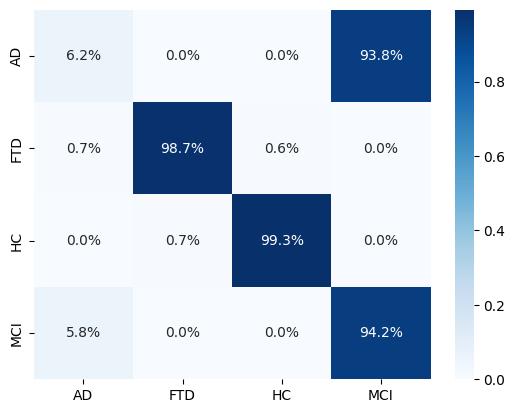

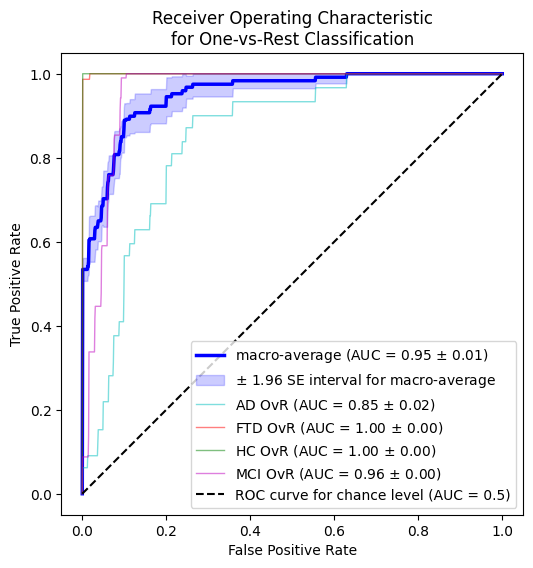

(True,
 False,
 [],
 0.7461251920122888,
 0.712466541530602,
 0.7797838424939756,
 0.06190476190476191,
 0.9508848133848133,
 0.9286687290667731,
 0.9731008977028536,
 [])

In [ ]:
run_pipeline(include_features = True,
             include_clinical = False,
             clinical_features = [],
             splits = mod_scan_splits,
             params = params,
             n_folds = n_folds,
             random_state = random_state,
             plot_results = True,
             save_image = True,
            #  feature_importance_table_name = '1_only_features',
             image_name = '1_only_features_mod_splits')

### All clinical features



Features: False; Clinical: ['age', 'biological_sex', 'education', 'mmse_total_score', 'cdr_total_score', 'boston_naming_test_total', 'letter_verbal_fluency_test', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.1}, {'n_estimators': 1800, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.2}, {'n_estimators': 1800, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.2}, {'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.0}]

Spread of balanced accuracies:
[0.7321428571428571, 0.7202380952380952, 0.8178571428571428, 0.7095317548598973, 0.7474548440065681]
mean:  0.7454449388209121
95% confidence interval:  (0.6922209346496764, 0.7986689429921479)

Spread of Required Criteria:
mean: 
array([[ 0.96,  0.98,  0.69,  1.  ,  0.8 ,  9.14,  0.31],
       [ 0.87,  0.91,  0.81,  0.94,  0.84, 19.56,  0.2 ],
       [ 0.69,  0.85,  0.7 ,  0.84,  0.69,  5.5 ,  0.36],
       [ 0.67,  0.93,  0.78,  0.88,  0.72,  7.15,  0.25]])
95% confidence interval negative: 
array([[  0.85,   0.97,   0.57,   0.99,   0.69, -16.24,   0.19],
 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ad aucs:
[0.9873206539873206, 0.9977834977834978, 0.9623194623194623, 0.9564564564564564, 0.9954954954954955]
mean:  0.9798751132084466
95% confidence interval:  (0.9560172493342605, 1.0037329770826326)


ftd aucs:
[0.9663782902021141, 0.911478144811478, 0.9616616616616616, 0.9610093964932674, 0.9246853460066673]
mean:  0.9450425678350376
95% confidence interval:  (0.9138317314933886, 0.9762534041766866)


hc aucs:
[0.872392562732903, 0.8303303303303304, 0.939406072739406, 0.8762728245486866, 0.8112105063539257]
mean:  0.8659224593410503
95% confidence interval:  (0.8044349146902837, 0.9274100039918168)


mci aucs:
[0.9154154154154155, 0.9097597597597598, 0.9693693693693693, 0.9110777444110778, 0.927455698226469]
mean:  0.9266155974364183
95% confidence interval:  (0.895701037534635, 0.9575301573382016)


macro:
[0.9353767305844383, 0.9123379331712665, 0.9581891415224748, 0.9262041054773721, 0.9147117615206394]
mean:  0.9293639344552382
95% confidence interval:  (0.9062876692582386, 0.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

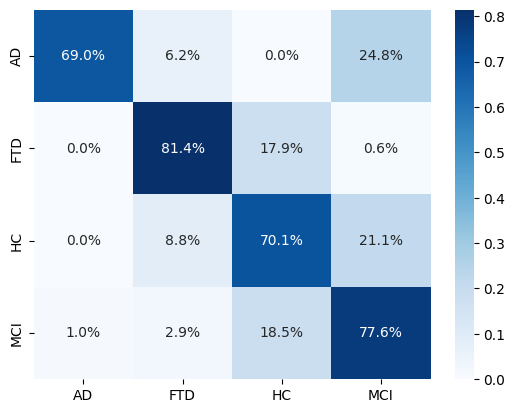

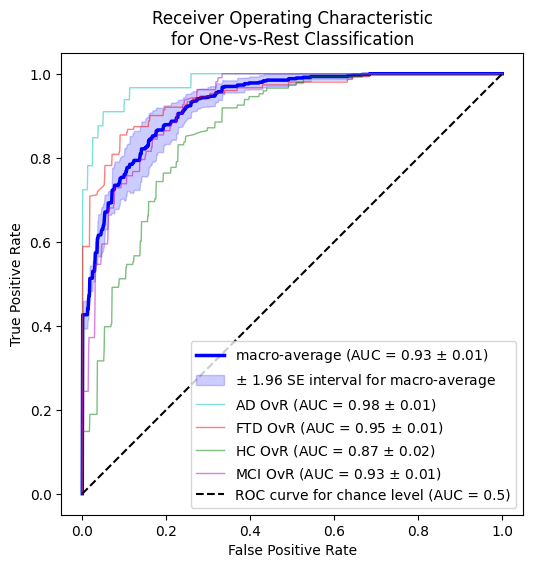

In [ ]:
output = run_pipeline(
    include_features = False,
    include_clinical = True,
    clinical_features = list(clinical_data.columns),
    splits = mod_scan_splits,
    params = params,
    n_folds = n_folds,
    random_state = random_state,
    plot_results = True,
    save_image = True,
    # feature_importance_table_name = '2_all_clinical',
    image_name = '2_all_clinical_mod_splits'
    )

### MMSE + CDR + BNT + letter verbal fluency + GDS (best clinical)



Features: False; Clinical: ['mmse_total_score', 'cdr_total_score', 'boston_naming_test_total', 'letter_verbal_fluency_test', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.769047619047619, 0.7202380952380952, 0.8494047619047619, 0.6917871709306637, 0.7673645320197044]
mean:  0.7595684358281688
95% confidence interval:  (0.6851659877499489, 0.8339708839063887)

Spread of Required Criteria:
mean: 
array([[ 0.9 ,  0.98,  0.79,  0.99,  0.83, 38.23,  0.22],
       [ 0.87,  0.9 ,  0.8 ,  0.94,  0.83, 14.58,  0.21],
       [ 0.68,  0.85,  0.72,  0.82,  0.7 ,  5.89,  0.35],
       [ 0.7 ,  0.91,  0.73,  0.9 ,  0.71,  8.89,  0.3 ]])
95% confidence interval negative: 
array([[ 0.78,  0.97,  0.62,  0.98,  0.73, -6.86,  0.05],
       [ 0.8

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ad aucs:
[0.9934934934934935, 0.9977834977834978, 0.9676104676104675, 0.9831498164831498, 0.9934934934934935]
mean:  0.9871061537728203
95% confidence interval:  (0.9720091294610876, 1.0022031780845528)


ftd aucs:
[0.9517228940652364, 0.924393562731901, 0.9785482178875573, 0.9479640931253834, 0.9261853445036629]
mean:  0.9457628224627482
95% confidence interval:  (0.9183112832462114, 0.9732143616792851)


hc aucs:
[0.8327738900061222, 0.859560436312188, 0.9602652702752803, 0.8727298801338359, 0.808414736575656]
mean:  0.8667488426606166
95% confidence interval:  (0.7949093420729678, 0.9385883432482653)


mci aucs:
[0.9068354068354068, 0.9306549104159214, 0.9812312312312312, 0.911998442028472, 0.9198539666507635]
mean:  0.930114791432359
95% confidence interval:  (0.8929239048866292, 0.9673056779780888)


macro:
[0.9212064211000648, 0.928098101810877, 0.9719137967511341, 0.9289605579427103, 0.9119868853058939]
mean:  0.9324331525821361
95% confidence interval:  (0.903755940788206, 0.96

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

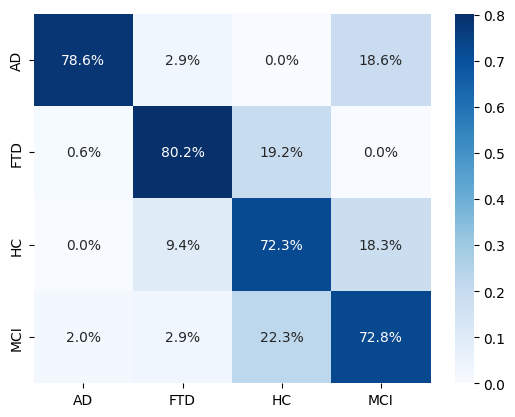

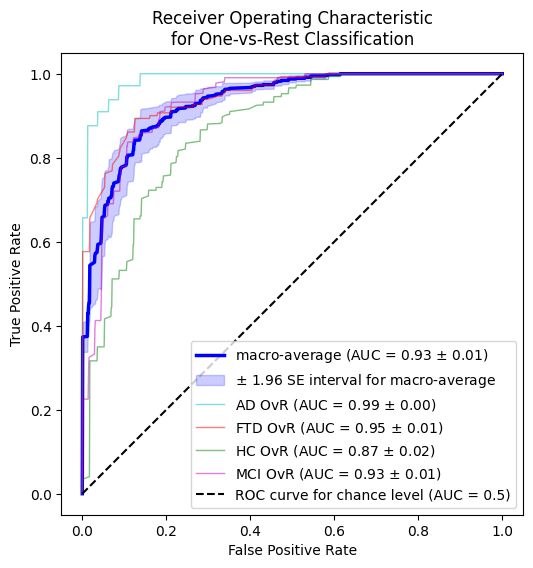

(False,
 True,
 ['mmse_total_score',
  'cdr_total_score',
  'boston_naming_test_total',
  'letter_verbal_fluency_test',
  'gds_score'],
 0.7595684358281688,
 0.6851659877499489,
 0.8339708839063887,
 0.7857142857142857,
 0.9324331525821361,
 0.903755940788206,
 0.9611103643760662,
 [])

In [ ]:
run_pipeline(params = params,
             splits = mod_scan_splits,
             include_features = False,
             include_clinical = True,
             clinical_features = ['mmse_total_score', 'cdr_total_score', 'boston_naming_test_total', 'letter_verbal_fluency_test', 'gds_score'],
             plot_results = True,
             save_image = True,
             draw_dtreeviz = False,
            #  feature_importance_table_name = '3_best_clinical',
             image_name = '3_best_clinical_mod_splits')

### Imaging features + MMSE

In [ ]:
# scan_splits_reversed = [scan_splits[i] for i in range(4, -1, -1)]
# selected_features = [selected_features[i] for i in range(4, -1, -1)]
# selected_features_names = [selected_features_names[i] for i in range(4, -1, -1)]



Features: True; Clinical: ['mmse_total_score']



  0%|          | 0/5 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.2}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 1, 'gamma': 0.4}, {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0}]

Spread of balanced accuracies:
[0.8666666666666667, 0.8803571428571428, 0.8761904761904762, 0.9383640552995391, 0.875]
mean:  0.887315668202765
95% confidence interval:  (0.851349258461831, 0.923282077943699)

Spread of Required Criteria:
mean: 
array([[ 0.89,  0.97,  0.6 ,  0.99,  0.7 , 31.79,  0.41],
       [ 0.99,  0.99,  0.99,  1.  ,  0.99, 11.6 ,  0.01],
       [ 0.99,  0.99,  0.99,  1.  ,  0.99, 11.6 ,  0.01],
       [ 0.88,  0.99,  0.98,  0.96,  0.93, 28.91,  0.02]])
95% confidence interval negative: 
array([[  0.76,   0.96,   0.42,   0.98,   0.61,  -5.9 ,   0.24],
       [  0.97,   0.98

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ad aucs:
[0.9647981314647982, 0.9836264836264836, 0.9872014872014871, 0.9359359359359359, 0.9706373039706373]
mean:  0.9684398684398685
95% confidence interval:  (0.9431663763620807, 0.9937133605176564)


ftd aucs:
[0.9994994994994995, 0.9994994994994995, 0.9989322655989322, 0.9983693370790145, 0.9994994994994995]
mean:  0.999160020235289
95% confidence interval:  (0.998532153543095, 0.9997878869274831)


hc aucs:
[0.9989322655989322, 0.9994994994994995, 0.9994994994994995, 0.9989127058092575, 0.9994994994994995]
mean:  0.9992686939813377
95% confidence interval:  (0.9988761802485957, 0.9996612077140796)


mci aucs:
[0.9859144859144859, 0.9928928928928928, 0.9965965965965966, 0.9894894894894894, 0.989298822632156]
mean:  0.9908384575051242
95% confidence interval:  (0.9858019617088065, 0.9958749533014419)


macro:
[0.9872860956194289, 0.9938795938795939, 0.9955574622241289, 0.9806768670784243, 0.9897337814004481]
mean:  0.989426760040405
95% confidence interval:  (0.9821164646589953, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

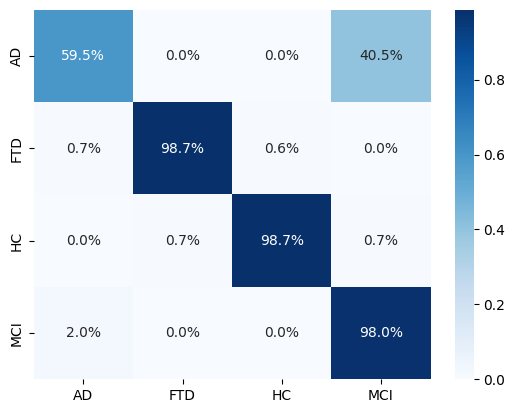

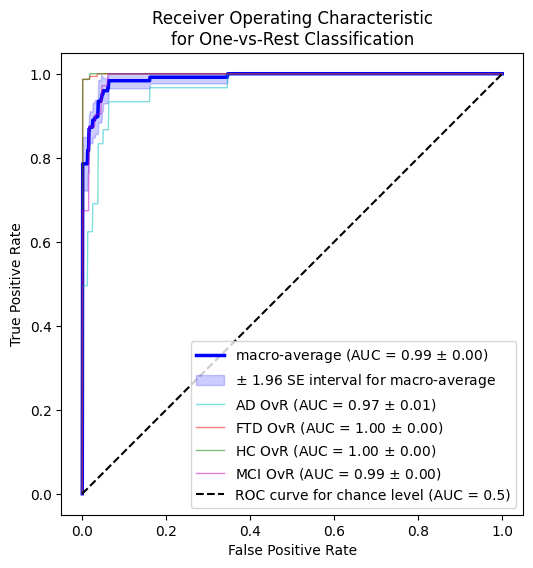

In [ ]:
output = run_pipeline(params = params,
                      # splits = scan_splits_reversed,
                      splits = mod_scan_splits,
                      include_features = True,
                      include_clinical = True,
                      clinical_features = ['mmse_total_score'],
                      plot_results = True,
                      save_image = True,
                      draw_dtreeviz = True,
                      # feature_importance_table_name = '4_features_mmse',
                      image_name = '4_features_mmse_mod_splits')

### All imaging features + all clinical features



Features: True; Clinical: ['age', 'biological_sex', 'education', 'mmse_total_score', 'cdr_total_score', 'boston_naming_test_total', 'letter_verbal_fluency_test', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.8666666666666667, 0.9160714285714286, 0.9035714285714286, 0.8966973886328724, 0.9464285714285714]
mean:  0.9058870967741935
95% confidence interval:  (0.8698179492263562, 0.9419562443220308)

Spread of Required Criteria:
mean: 
array([[ 0.84,  0.98,  0.69,  0.99,  0.74, 41.28,  0.32],
       [ 1.  ,  1.  ,  0.99,  1.  ,  1.  ,  0.  ,  0.01],
       [ 0.99,  1.  ,  0.99,  1.  ,  0.99, 11.6 ,  0.01],
       [ 0.9 ,  0.98,  0.95,  0.97,  0.92, 34.36,  0.05]])
95% confidence interval negative: 
array([[  0.71,   0.97,   0.54,   0.98,   0.66,   7.71,   0.17],
   

/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ad aucs:
[0.9708041374708041, 0.9907764907764908, 0.9676104676104675, 0.9502836169502835, 0.9954954954954955]
mean:  0.9749940416607081
95% confidence interval:  (0.9521657116957642, 0.997822371625652)


ftd aucs:
[0.9994994994994995, 0.9994994994994995, 0.9994994994994995, 0.9994994994994995, 0.9994994994994995]
mean:  0.9994994994994995
95% confidence interval:  (nan, nan)


hc aucs:
[0.9994994994994995, 0.9994994994994995, 0.9994994994994995, 0.9994994994994995, 0.9994994994994995]
mean:  0.9994994994994995
95% confidence interval:  (nan, nan)


mci aucs:
[0.9930644930644931, 0.9966466466466466, 0.9936936936936936, 0.9887744887744887, 0.9980694980694981]
mean:  0.994049764049764
95% confidence interval:  (0.9895802852228651, 0.9985192428766628)


macro:
[0.990716907383574, 0.9966055341055341, 0.99007579007579, 0.9845142761809428, 0.9981409981409981]
mean:  0.9920107011773679
95% confidence interval:  (0.9852011277717834, 0.9988202745829524)




/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

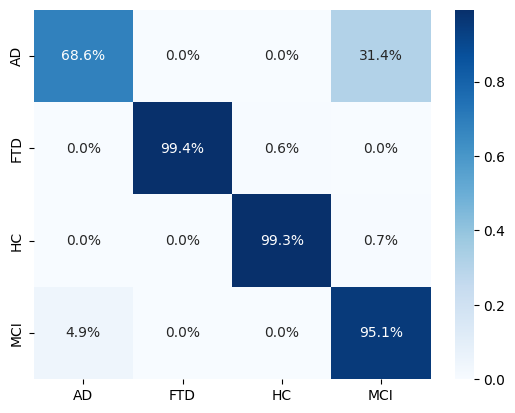

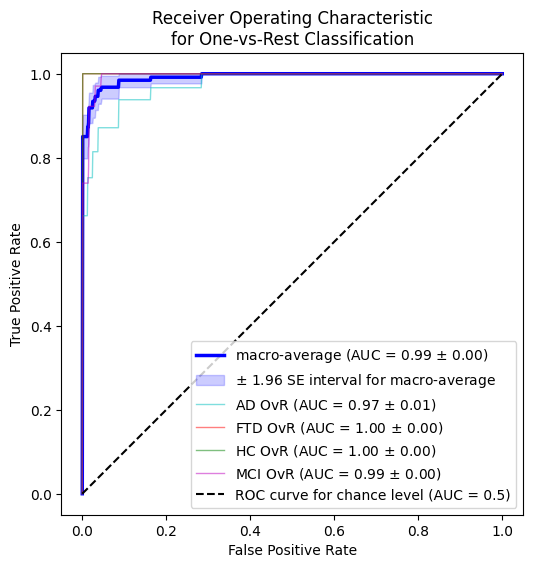

(True,
 True,
 ['age',
  'biological_sex',
  'education',
  'mmse_total_score',
  'cdr_total_score',
  'boston_naming_test_total',
  'letter_verbal_fluency_test',
  'gds_score'],
 0.9058870967741935,
 0.8698179492263562,
 0.9419562443220308,
 0.6857142857142857,
 0.9920107011773679,
 0.9852011277717834,
 0.9988202745829524,
 [])

In [ ]:
run_pipeline(params = params,
             splits = mod_scan_splits,
             include_features = True,
             include_clinical = True,
             clinical_features = list(clinical_data.columns),
             plot_results = True,
             save_image = True,
             draw_dtreeviz = False,
            #  feature_importance_table_name = '7_features_all_clinical',
             image_name = '7_features_all_clinical_mod_splits')

### All imaging features + CDR



Features: True; Clinical: ['cdr_total_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0}]

Spread of balanced accuracies:
[0.825, 0.9642857142857143, 0.8845238095238095, 0.8966973886328724, 0.8928571428571428]
mean:  0.8926728110599079
95% confidence interval:  (0.8312428895766284, 0.9541027325431874)

Spread of Required Criteria:
mean: 
array([[ 0.89,  0.97,  0.62,  0.99,  0.71, 16.13,  0.38],
       [ 0.99,  1.  ,  0.99,  1.  ,  0.99, 12.  ,  0.01],
       [ 0.99,  0.99,  0.99,  1.  ,  0.99, 11.6 ,  0.01],
       [ 0.89,  0.99,  0.97,  0.96,  0.93, 32.67,  0.03]])
95% confidence interval negative: 
array([[  0.7 ,   0.95,   0.38,   0.98,   0.52, -13.81,   0.15],
       [  0.98,  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ad aucs:
[0.8251584918251584, 0.9906334906334906, 0.9694694694694694, 0.8578578578578578, 0.9684684684684685]
mean:  0.9223175556508888
95% confidence interval:  (0.8289546337822875, 1.01568047751949)


ftd aucs:
[0.9994994994994995, 0.9994994994994995, 0.998365031698365, 0.9983693370790145, 0.9994994994994995]
mean:  0.9990465734551757
95% confidence interval:  (0.9982764979179695, 0.9998166489923819)


hc aucs:
[0.9994994994994995, 0.9994994994994995, 0.9994994994994995, 0.9983259121190156, 0.9994994994994995]
mean:  0.9992647820234026
95% confidence interval:  (0.9986131018357893, 0.9999164622110159)


mci aucs:
[0.9501644501644502, 0.9973973973973974, 0.9937937937937937, 0.9716144716144717, 0.9887744887744887]
mean:  0.9803489203489203
95% confidence interval:  (0.9560665448663024, 1.0046312958315382)


macro:
[0.9435804852471519, 0.9967574717574718, 0.990281948615282, 0.9565418946675899, 0.989060489060489]
mean:  0.9752444578695968
95% confidence interval:  (0.9459124509981206, 1.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

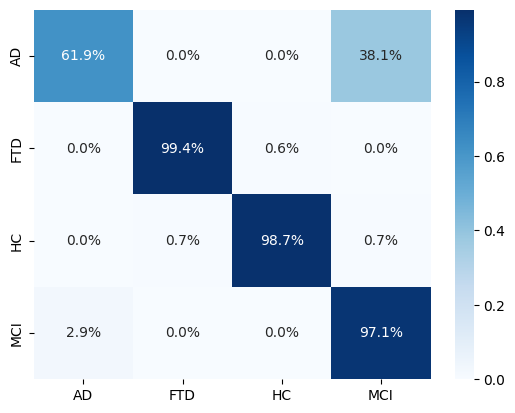

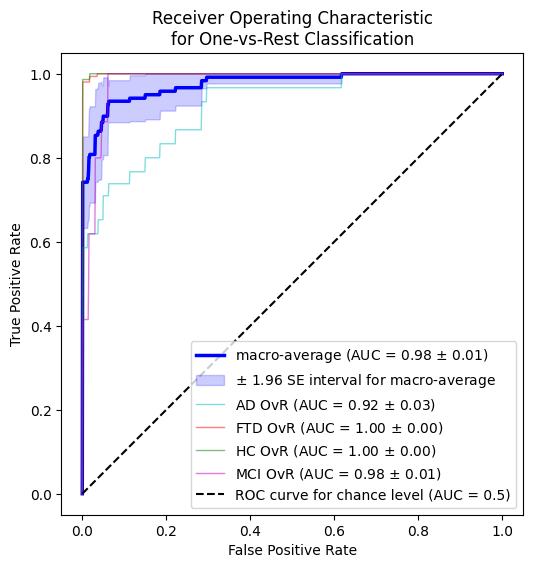

(True,
 True,
 ['cdr_total_score'],
 0.8926728110599079,
 0.8312428895766284,
 0.9541027325431874,
 0.619047619047619,
 0.9752444578695968,
 0.9459124509981206,
 1.004576464741073,
 [])

In [ ]:
run_pipeline(params = params,
             splits = mod_scan_splits,
             include_features = True,
             include_clinical = True,
             clinical_features = ['cdr_total_score'],
             plot_results = True,
             save_image = True,
             draw_dtreeviz = False,
            #  feature_importance_table_name = '8_features_cdr',
             image_name = '8_features_cdr_mod_splits')

### All imaging features + all clinical features except for age (best combination)



Features: True; Clinical: ['biological_sex', 'education', 'mmse_total_score', 'cdr_total_score', 'boston_naming_test_total', 'letter_verbal_fluency_test', 'gds_score']



  0%|          | 0/5 [00:00<?, ?it/s]



Best parameters:
[{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.0}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.0}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}, {'n_estimators': 1800, 'max_depth': 2, 'learning_rate': 0.3, 'gamma': 0.2}]

Spread of balanced accuracies:
[0.8771771771771771, 0.9555921052631579, 0.9168093607305936, 0.9238213447875899, 0.8826604554865424]
mean:  0.9112120886890122
95% confidence interval:  (0.8712974691521949, 0.9511267082258295)

Spread of Required Criteria:
mean: 
array([[ 0.81,  0.97,  0.72,  0.98,  0.74, 51.07,  0.29],
       [ 1.  ,  1.  ,  0.99,  1.  ,  0.99, 35.  ,  0.01],
       [ 1.  ,  0.99,  0.99,  1.  ,  0.99, 29.65,  0.01],
       [ 0.92,  0.98,  0.95,  0.96,  0.93, 30.43,  0.05]])
95% confidence interval negative: 
array([[  0.58,   0.96,   0.57,   0.96,   0.62, -26.24,   0.14],
   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ad aucs:
[0.9691691691691692, 0.986986986986987, 0.9543918918918919, 0.9798711755233496, 0.9747414080747414]
mean:  0.9730321263292279
95% confidence interval:  (0.9577388130212994, 0.9883254396371564)


ftd aucs:
[0.9994994994994995, 0.9994994994994995, 0.9992492492492493, 0.9994994994994995, 0.9994994994994995]
mean:  0.9994494494494495
95% confidence interval:  (0.9993104882329732, 0.9995884106659257)


hc aucs:
[0.9991380269158047, 0.9994994994994995, 0.9994994994994995, 0.999348185394697, 0.9994994994994995]
mean:  0.9993969421618001
95% confidence interval:  (0.9991996695829837, 0.9995942147406165)


mci aucs:
[0.9874874874874875, 0.9946349858630561, 0.9893797907496538, 0.9919988481632317, 0.9888745888745889]
mean:  0.9904751402276035
95% confidence interval:  (0.9869460160684095, 0.9940042643867976)


macro:
[0.9888235457679901, 0.9951552429622605, 0.9856301078475737, 0.9926794271451944, 0.9906537489870824]
mean:  0.9905884145420203
95% confidence interval:  (0.986071585852328, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

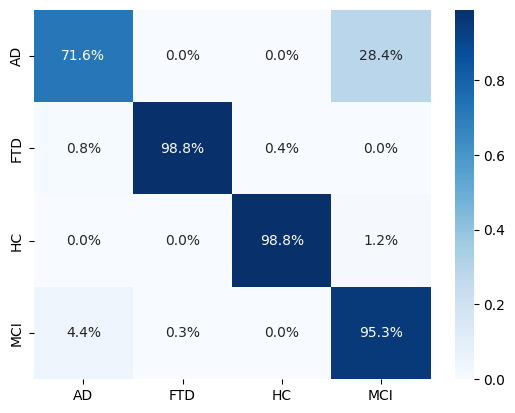

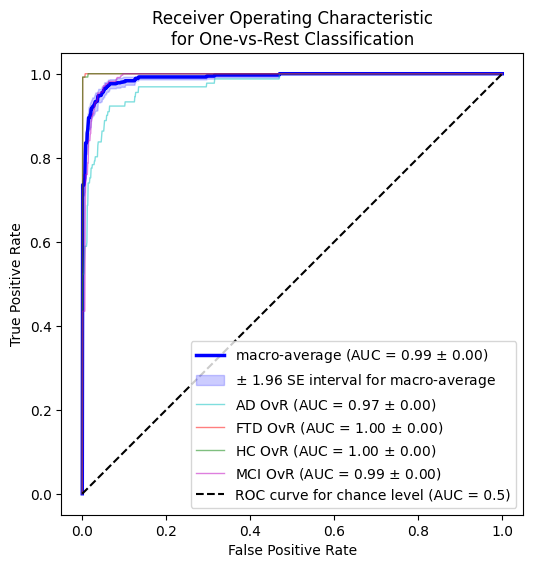

(True,
 True,
 ['biological_sex',
  'education',
  'mmse_total_score',
  'cdr_total_score',
  'boston_naming_test_total',
  'letter_verbal_fluency_test',
  'gds_score'],
 0.9112120886890122,
 0.8712974691521949,
 0.9511267082258295,
 0.7161594202898549,
 0.9905884145420203,
 0.986071585852328,
 0.9951052432317126,
 [])

In [ ]:
run_pipeline(params = params,
             splits = scan_splits,
             include_features = True,
             include_clinical = True,
             clinical_features = ['biological_sex', 'education', 'mmse_total_score', 'cdr_total_score', 'boston_naming_test_total', 'letter_verbal_fluency_test', 'gds_score'],
             plot_results = True,
             save_image = True,
             draw_dtreeviz = False,
            #  feature_importance_table_name = '10_best_combo',
             image_name = '10_best_combo_mod_splits')

#### Viztree - The figure was further modified and corrected using InkScape to yield the final paper figure

In [ ]:
# Initialize data for dtreeviz
i = 0 # The number of the split
save_image = False
image_name = 'features_all_clinical'
train_index = list(cv_splitter.split(X, y))[i][0]
test_index = list(cv_splitter.split(X, y))[i][1]
clinical_features = list(clinical_data.columns)


# Create datasets
## target data
y_train = y[train_index]
y_test = y[test_index]

## Features data
### Choose features for this fold as determined by the pipeline on features-only data
X_train_features = X[train_index, :]
X_train_features = X_train_features[:, selected_features[i]]
X_test_features = X[test_index, :]
X_test_features = X_test_features[:, selected_features[i]]
### Standardize data
scaler = StandardScaler()
scaler.fit(X_train_features)
X_train_features = scaler.transform(X_train_features)
X_test_features = scaler.transform(X_test_features)

## Clinical data
X_train_clinical = clinical_data.loc[train_index, clinical_features]
X_test_clinical = clinical_data.loc[test_index, clinical_features]
### Perform imputation based on training data in each fold
#### Numerical data
X_train_clinical_n = X_train_clinical.drop('biological_sex', axis = 1)
X_test_clinical_n = X_test_clinical.drop('biological_sex', axis = 1)
numeric_columns = X_train_clinical_n.columns
imputer = SimpleImputer(strategy = 'mean')
imputer.fit(X_train_clinical_n)
X_train_clinical_n = imputer.transform(X_train_clinical_n).astype(np.int64)
X_test_clinical_n = imputer.transform(X_test_clinical_n).astype(np.int64)
#### Categorical data
X_train_clinical_c = np.array(X_train_clinical['biological_sex']).reshape(-1, 1)
X_test_clinical_c = np.array(X_test_clinical['biological_sex']).reshape(-1, 1)
imputer = SimpleImputer(strategy = 'most_frequent')
imputer.fit(X_train_clinical_c)
X_train_clinical_c = imputer.transform(X_train_clinical_c)
X_test_clinical_c = imputer.transform(X_test_clinical_c)
### Standardize data (Don't standardize biological sex which is one-hot encoded)
scaler = StandardScaler()
scaler.fit(X_train_clinical_n)
X_train_clinical_n = scaler.transform(X_train_clinical_n)
X_test_clinical_n = scaler.transform(X_test_clinical_n)
### Combine numerical and categorical data
X_train_clinical = np.hstack((X_train_clinical_n, X_train_clinical_c))
X_test_clinical = np.hstack((X_test_clinical_n, X_test_clinical_c))

## Combine features and clinical data
X_train = np.hstack((X_train_features, X_train_clinical))
X_test = np.hstack((X_test_features, X_test_clinical))
final_feature_names = selected_features_names[i] + clinical_features


# Create model and generate predictions
clf = xgb.XGBClassifier(random_state = random_state, n_estimators = 1600, max_depth = 2, learning_rate = 0.01, gamma = 0.0)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print("Balanced accuracy in test set: ", balanced_accuracy_score(y_test, y_test_pred))


# Create tree
tree_friendly_names = [f'ROI: {selected_features_names[i][item][0]}; Feature: {selected_features_names[i][item][1]}' for item in range(len(selected_features_names[i]))] + [clinical_tree_friendly_names[item] for item in clinical_features]

viz_model = dtreeviz.model(
    clf,
    tree_index = 1,
    X_train = X_train,
    y_train = y_train.astype(int),
    feature_names = tree_friendly_names,
    target_name = 'class',
    class_names = ['AD', 'FTD', 'HC', 'MCI'],
    )

### Show tree
viz_tree = viz_model.view()
### Save tree
if save_image:
  viz_tree.save("./paper_absolute_final/figures/" + image_name + f"fold_{i}_dtreeviz.svg")
  files.download("./paper_absolute_final/figures/" + image_name + f"fold_{i}_dtreeviz.svg")

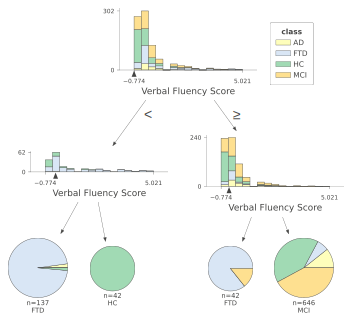

In [ ]:
viz_tree

In [ ]:
tree_friendly_names

['ROI: 83; Feature: fft_coefficient',
 'ROI: 93; Feature: spkt_welch_density',
 'ROI: 107; Feature: cid_ce',
 'ROI: 125; Feature: spkt_welch_density',
 'ROI: 136; Feature: spkt_welch_density',
 'ROI: 164; Feature: spkt_welch_density',
 'ROI: 178; Feature: cid_ce',
 'ROI: 196; Feature: fft_coefficient',
 'ROI: 12; Feature: cid_ce',
 'ROI: 27; Feature: spkt_welch_density',
 'ROI: 43; Feature: spkt_welch_density',
 'Age',
 'Sex',
 'Education',
 'MMSE Total Score',
 'CDR Total Score',
 'BNT Total Score',
 'Verbal Fluency Score',
 'GDS Score']

# Statistical comparison of models

## Models repeat vs. no repeat

In [ ]:
print('imaging features only: ')
print('balanced accuracy:')
print('t, p, d:', perform_t_test(0.746, (0.712, 0.780), 5, 0.744, (0.721, 0.767), 5))
print('f1 score:')
print('t, p, d:', perform_t_test(0.73, (0.69, 0.78), 5, 0.73, (0.69, 0.77), 5))

print('\n clinical only: ')
print('balanced accuracy:')
print('t, p, d:', perform_t_test(0.745, (0.692, 0.799), 5, 0.706, (0.636, 0.777), 5))
print('f1 score:')
print('t, p, d:', perform_t_test(0.760, (0.72, 0.81), 5, 0.72, (0.62, 0.81), 5))

print('\n best clinical: ')
print('balanced accuracy:')
print('t, p, d:', perform_t_test(0.759, (0.685, 0.834), 5, 0.716, (0.649, 0.782), 5))
# print('f1 score:')
# print('t, p, d:', perform_t_test(0.760, (0.72, 0.81), 5, 0.72, (0.62, 0.81), 5))

print('\n all imaging features and clinical: ')
print('balanced accuracy:')
print('t, p, d:', perform_t_test(0.906, (0.870, 0.942), 5, 0.904, (0.876, 0.932), 5))

print('\n best combined: ')
print('balanced accuracy:')
print('t, p, d:', perform_t_test(0.911, (0.871, 0.951), 5, 0.911, (0.871, 0.951), 5))
print('f1 score:')
print('t, p, d:', perform_t_test(0.92, (0.88, 0.95), 5, 0.92, (0.87, 0.96), 5))

print('\n imaging features + cdr: ')
print('balanced accuracy:')
print('t, p, d:', perform_t_test(0.893, (0.831, 0.954), 5, 0.907, (0.842, 0.972), 5))

print('\n imaging features + mmse: ')
print('balanced accuracy:')
print('t, p, d:', perform_t_test(0.887, (0.851, 0.923), 5, 0.887, (0.863, 0.911), 5))


imaging features only: 
balanced accuracy:
t, p, d: (0.3024852042324497, 0.7699975548017799, 0.19130844077514902)
f1 score:
t, p, d: (0.0, 1.0, 0.0)

 clinical only: 
balanced accuracy:
t, p, d: (2.735826164060122, 0.025613987033014318, 1.7302883921422947)
f1 score:
t, p, d: (2.3623973439338593, 0.045786561998291786, 1.494111269032632)

 best clinical: 
balanced accuracy:
t, p, d: (2.673255853479504, 0.02821945258087699, 1.6907154530745179)

 all imaging features and clinical: 
balanced accuracy:
t, p, d: (0.2722528417273608, 0.7923224004628557, 0.17218781586235812)

 best combined: 
balanced accuracy:
t, p, d: (0.0, 1.0, 0.0)
f1 score:
t, p, d: (0.0, 1.0, 0.0)

 imaging features + cdr: 
balanced accuracy:
t, p, d: (-0.9713157590371344, 0.35983865389580894, 0.6143140251545245)

 imaging features + mmse: 
balanced accuracy:
t, p, d: (0.0, 1.0, 0.0)


## pairwise 5 models

In [ ]:
n1 = 5
n2 = 5

feat_ba = 0.74
feat_ba_ci = (0.72,0.77)
feat_roc_auc = 0.94
feat_roc_auc_ci = (0.92,0.95)
feat_f1 = 0.73
feat_f1_ci = (0.69, 0.77)

best_clin_ba = 0.72
best_clin_ba_ci = (0.65, 0.78)
best_clin_roc_auc = 0.92
best_clin_roc_auc_ci = (0.90, 0.94)
best_clin_f1 = 0.72
best_clin_f1_ci = (0.63, 0.81)

best_comb_ba = 0.91
best_comb_ba_ci = (0.87, 0.95)
best_comb_roc_auc = 0.99
best_comb_roc_auc_ci = (0.99, 0.99)
best_comb_f1 = 0.92
best_comb_f1_ci = (0.87, 0.96)

comb_cdr_ba = 0.91
comb_cdr_ba_ci = (0.83, 0.98)
comb_cdr_roc_auc = 0.97
comb_cdr_roc_auc_ci = (0.94, 1.00)
comb_cdr_f1 = 0.92
comb_cdr_f1_ci = (0.86, 0.97)

comb_mmse_ba = 0.89
comb_mmse_ba_ci = (0.86, 0.91)
comb_mmse_roc_auc = 0.99
comb_mmse_roc_auc_ci = (0.98, 0.99)
comb_mmse_f1 = 0.90
comb_mmse_f1_ci = (0.85, 0.93)

In [ ]:
model_list = ['feat', 'best_clin', 'best_comb', 'comb_cdr', 'comb_mmse']

model_pairs = list(combinations(model_list, 2))

In [ ]:
model_pairs

[('feat', 'best_clin'),
 ('feat', 'best_comb'),
 ('feat', 'comb_cdr'),
 ('feat', 'comb_mmse'),
 ('best_clin', 'best_comb'),
 ('best_clin', 'comb_cdr'),
 ('best_clin', 'comb_mmse'),
 ('best_comb', 'comb_cdr'),
 ('best_comb', 'comb_mmse'),
 ('comb_cdr', 'comb_mmse')]

In [ ]:
for pair in model_pairs:

  t_ba, p_ba, cohen_ba = perform_t_test(eval(f'{pair[0]}_ba'), eval(f'{pair[0]}_ba_ci'), n1, eval(f'{pair[1]}_ba'), eval(f'{pair[1]}_ba_ci'), n2)
  t_f1, p_f1, cohen_f1 = perform_t_test(eval(f'{pair[0]}_f1'), eval(f'{pair[0]}_f1_ci'), n1, eval(f'{pair[1]}_f1'), eval(f'{pair[1]}_f1_ci'), n2)
  t_roc_auc, p_roc_auc, cohen_roc_auc = perform_t_test(eval(f'{pair[0]}_roc_auc'), eval(f'{pair[0]}_roc_auc_ci'), n1, eval(f'{pair[1]}_roc_auc'), eval(f'{pair[1]}_roc_auc_ci'), n2)

  print(f"\n\nPair: {pair[0]}, {pair[1]}")
  print("\nT-statistic (BA):", t_ba)
  print("P-value (BA):", p_ba * 10)
  print("Cohen's d effect size (BA):", cohen_ba)
  print("\nT-statistic (F1):", t_f1)
  print("P-value (F1):", p_f1 * 10)
  print("Cohen's d effect size (F1):", cohen_f1)
  print("\nT-statistic (ROC AUC):", t_roc_auc)
  print("P-value (ROC AUC):", p_roc_auc * 10)
  print("Cohen's d effect size (ROC AUC):", cohen_roc_auc)



Pair: feat, best_clin

T-statistic (BA): 1.7829255955446306
P-value (BA): 1.1244736946035983
Cohen's d effect size (BA): 1.1276211561066378

T-statistic (F1): 0.6303593894803359
P-value (F1): 5.460398082163924
Cohen's d effect size (F1): 0.39867428304620894

T-statistic (ROC AUC): 4.966655992815054
P-value (ROC AUC): 0.010976936588118491
Cohen's d effect size (ROC AUC): 3.14118905836409


Pair: feat, best_comb

T-statistic (BA): -22.37474049819563
P-value (BA): 1.6840860261879698e-07
Cohen's d effect size (BA): 14.151028405901753

T-statistic (F1): -19.591770684109573
P-value (F1): 4.790402563514817e-07
Cohen's d effect size (F1): 12.390923751500294

T-statistic (ROC AUC): -20.69439997006285
P-value (ROC AUC): 3.11497341254352e-07
Cohen's d effect size (ROC AUC): 13.088287743183788


Pair: feat, comb_cdr

T-statistic (BA): -13.350053498047414
P-value (BA): 9.477169118365936e-06
Cohen's d effect size (BA): 8.443315187785613

T-statistic (F1): -17.344901016930507
P-value (F1): 1.243948

# Model PRC AUCs

In [ ]:
print('\nModel 1:')
precision = [0.16, 0.99, 0.99, 0.79]
recall = [0.05, 0.99, 0.99, 0.94]
precision_ci = [(0.00, 0.45), (0.97, 1.00), (0.99, 1.00), (0.75, 0.83)]
recall_ci = [(0.00, 0.16), (0.98, 1.00), (0.98, 1.00), (0.88, 1.00)]

auc_pr, auc_pr_ci = bootstrap_auc_pr(precision, recall, precision_ci, recall_ci)
print("AUC-PR:", auc_pr)
print("95% Confidence Interval:", auc_pr_ci)


print('\nModel 2:')
precision = [0.80, 0.80, 0.70, 0.69]
recall = [0.61, 0.78, 0.66, 0.77]
precision_ci = [(0.59, 1.00), (0.72, 0.88), (0.59, 0.80), (0.57, 0.80)]
recall_ci = [(0.51, 0.72), (0.69, 0.87), (0.51, 0.82), (0.64, 0.90)]

auc_pr, auc_pr_ci = bootstrap_auc_pr(precision, recall, precision_ci, recall_ci)
print("AUC-PR:", auc_pr)
print("95% Confidence Interval:", auc_pr_ci)


print('\nModel 3:')
precision = [0.78, 0.80, 0.69, 0.70]
recall = [0.66, 0.77, 0.69, 0.75]
precision_ci = [(0.60, 0.97), (0.72, 0.87), (0.62, 0.76), (0.61, 0.80)]
recall_ci = [(0.52, 0.80), (0.66, 0.88), (0.55, 0.83), (0.63, 0.87)]

auc_pr, auc_pr_ci = bootstrap_auc_pr(precision, recall, precision_ci, recall_ci)
print("AUC-PR:", auc_pr)
print("95% Confidence Interval:", auc_pr_ci)


print('\nModel 4:')
precision = [0.82, 1.00, 1.00, 0.91]
recall = [0.68, 1.00, 0.99, 0.95]
precision_ci = [(0.60, 1.00), (0.99, 1.00), (0.99, 1.00), (0.88, 0.94)]
recall_ci = [(0.58, 0.78), (0.99, 1.00), (0.97, 1.00), (0.90, 1.00)]

auc_pr, auc_pr_ci = bootstrap_auc_pr(precision, recall, precision_ci, recall_ci)
print("AUC-PR:", auc_pr)
print("95% Confidence Interval:", auc_pr_ci)


print('\nModel 5:')
precision = [0.81, 1.00, 1.00, 0.92]
recall = [0.72, 0.99, 0.99, 0.95]
precision_ci = [(0.58, 1.00), (0.99, 1.00), (0.99, 1.00), (0.87, 0.96)]
recall_ci = [(0.57, 0.86), (0.97, 1.00), (0.97, 1.00), (0.90, 1.00)]

auc_pr, auc_pr_ci = bootstrap_auc_pr(precision, recall, precision_ci, recall_ci)
print("AUC-PR:", auc_pr)
print("95% Confidence Interval:", auc_pr_ci)


print('\nModel 6:')
precision = [0.86, 0.99, 1.00, 0.91]
recall = [0.68, 1.00, 0.99, 0.96]
precision_ci = [(0.75, 0.97), (0.97, 1.00), (0.99, 1.00), (0.85, 0.98)]
recall_ci = [(0.42, 0.95), (1.00, 1.00), (0.97, 1.00), (0.94, 0.98)]

auc_pr, auc_pr_ci = bootstrap_auc_pr(precision, recall, precision_ci, recall_ci)
print("AUC-PR:", auc_pr)
print("95% Confidence Interval:", auc_pr_ci)


print('\nModel 7:')
precision = [0.76, 0.99, 1.00, 0.89]
recall = [0.63, 0.99, 0.98, 0.94]
precision_ci = [(0.59, 0.93), (0.97, 1.00), (0.99, 1.00), (0.87, 0.92)]
recall_ci = [(0.56, 0.70), (0.98, 1.00), (0.97, 1.00), (0.91, 0.98)]

auc_pr, auc_pr_ci = bootstrap_auc_pr(precision, recall, precision_ci, recall_ci)
print("AUC-PR:", auc_pr)
print("95% Confidence Interval:", auc_pr_ci)


Model 1:
AUC-PR: 0.46725
95% Confidence Interval: (0.0, 0.5405)

Model 2:
AUC-PR: 0.12140000000000004
95% Confidence Interval: (0.007450000000000007, 0.13600000000000004)

Model 3:
AUC-PR: 0.07874999999999999
95% Confidence Interval: (0.015000000000000013, 0.08689999999999999)

Model 4:
AUC-PR: 0.28174999999999994
95% Confidence Interval: (0.010000000000000009, 0.2920999999999999)

Model 5:
AUC-PR: 0.23735
95% Confidence Interval: (0.0, 0.24435)

Model 6:
AUC-PR: 0.2864
95% Confidence Interval: (0.00995000000000001, 0.29824999999999996)

Model 7:
AUC-PR: 0.3035
95% Confidence Interval: (0.00995000000000001, 0.31795)
